# Import Common Package

In [117]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import random

seed = 42
np.random.seed = seed

# Import Dataset

In [118]:
IMG_WIDTH = 384
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [119]:
TRAIN_PATH = "/content/drive/MyDrive/GITHUB BARU/upper arm segmentation/dataset/train/"
TEST_PATH = "/content/drive/MyDrive/GITHUB BARU/upper arm segmentation/dataset/test/"

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

# Resizing Train Images

In [120]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/'+ id_ + '.jpg')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #Fill empty X_train with values from img

    mask = imread(path + '/masks/'+ id_ + '.jpg')[:,:,:1]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    y_train[n] = mask #Fill empty X_train with values from img

Resizing training images and masks


100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


# Resizing Test images

In [121]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images


100%|██████████| 1/1 [00:02<00:00,  2.63s/it]

Done!


# Show Random Train Image

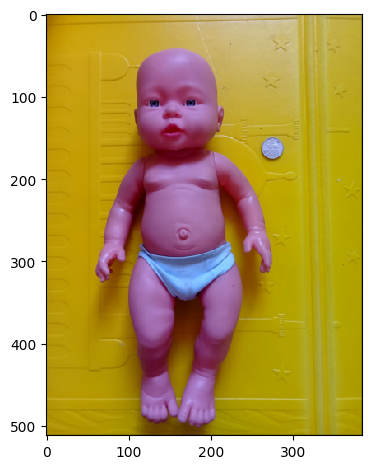

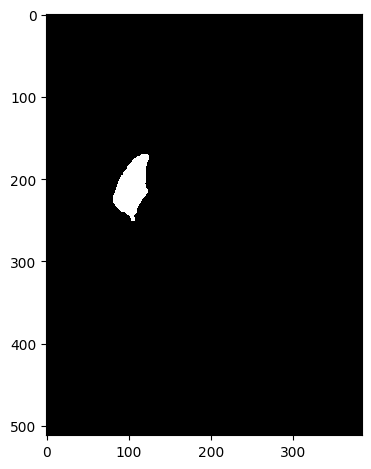

In [126]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()

## Build the model

In [127]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

## Contraction path

In [128]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

## Expansive path

In [129]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [130]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.MeanIoU(num_classes=2)])

## Model Checkpoint

In [132]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_head.keras', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=None, monitor='val_mean_io_u', mode='max'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.History()]

## Training

In [133]:
result = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=1000, callbacks=callbacks)

Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 1.2365 - mean_io_u_5: 0.4944

2/2 [==============================] - 8s 637ms/step - loss: 1.2365 - mean_io_u_5: 0.4944 - val_loss: 0.8464 - val_mean_io_u_5: 0.4946
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 0.9125 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 128ms/step - loss: 0.9125 - mean_io_u_5: 0.4944 - val_loss: 0.7527 - val_mean_io_u_5: 0.4946
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 0.7342 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 131ms/step - loss: 0.7342 - mean_io_u_5: 0.4944 - val_loss: 0.6620 - val_mean_io_u_5: 0.4946
Epoch 4/1000
2/2 [==============================] - ETA: 0s - loss: 0.6369 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 130ms/step - loss: 0.6369 - mean_io_u_5: 0.4944 - val_loss: 0.5547 - val_mean_io_u_5: 0.4946
Epoch 5/1000
2/2 [==============================] - ETA: 0s - loss: 0.4764 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 127ms/step - loss: 0.4764 - mean_io_u_5: 0.4944 - val_loss: 0.2520 - val_mean_io_u_5: 0.4946
Epoch 6/1000
2/2 [==============================] - ETA: 0s - loss: 0.1280 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 131ms/step - loss: 0.1280 - mean_io_u_5: 0.4944 - val_loss: 0.0779 - val_mean_io_u_5: 0.4946
Epoch 7/1000
2/2 [==============================] - ETA: 0s - loss: 0.1752 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 183ms/step - loss: 0.1752 - mean_io_u_5: 0.4944 - val_loss: 0.0665 - val_mean_io_u_5: 0.4946
Epoch 8/1000
2/2 [==============================] - ETA: 0s - loss: 0.1203 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 155ms/step - loss: 0.1203 - mean_io_u_5: 0.4944 - val_loss: 0.0530 - val_mean_io_u_5: 0.4946
Epoch 9/1000
2/2 [==============================] - ETA: 0s - loss: 0.0769 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 158ms/step - loss: 0.0769 - mean_io_u_5: 0.4944 - val_loss: 0.0533 - val_mean_io_u_5: 0.4946
Epoch 10/1000
2/2 [==============================] - ETA: 0s - loss: 0.0588 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 196ms/step - loss: 0.0588 - mean_io_u_5: 0.4944 - val_loss: 0.0685 - val_mean_io_u_5: 0.4946
Epoch 11/1000
2/2 [==============================] - ETA: 0s - loss: 0.0557 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 160ms/step - loss: 0.0557 - mean_io_u_5: 0.4944 - val_loss: 0.0839 - val_mean_io_u_5: 0.4946
Epoch 12/1000
2/2 [==============================] - ETA: 0s - loss: 0.0592 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 169ms/step - loss: 0.0592 - mean_io_u_5: 0.4944 - val_loss: 0.0817 - val_mean_io_u_5: 0.4946
Epoch 13/1000
2/2 [==============================] - ETA: 0s - loss: 0.0575 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 136ms/step - loss: 0.0575 - mean_io_u_5: 0.4944 - val_loss: 0.0655 - val_mean_io_u_5: 0.4946
Epoch 14/1000
2/2 [==============================] - ETA: 0s - loss: 0.0518 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 136ms/step - loss: 0.0518 - mean_io_u_5: 0.4944 - val_loss: 0.0514 - val_mean_io_u_5: 0.4946
Epoch 15/1000
2/2 [==============================] - ETA: 0s - loss: 0.0493 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 131ms/step - loss: 0.0493 - mean_io_u_5: 0.4944 - val_loss: 0.0463 - val_mean_io_u_5: 0.4946
Epoch 16/1000
2/2 [==============================] - ETA: 0s - loss: 0.0505 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 132ms/step - loss: 0.0505 - mean_io_u_5: 0.4944 - val_loss: 0.0454 - val_mean_io_u_5: 0.4946
Epoch 17/1000
2/2 [==============================] - ETA: 0s - loss: 0.0491 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 141ms/step - loss: 0.0491 - mean_io_u_5: 0.4944 - val_loss: 0.0471 - val_mean_io_u_5: 0.4946
Epoch 18/1000
2/2 [==============================] - ETA: 0s - loss: 0.0460 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 170ms/step - loss: 0.0460 - mean_io_u_5: 0.4944 - val_loss: 0.0508 - val_mean_io_u_5: 0.4946
Epoch 19/1000
2/2 [==============================] - ETA: 0s - loss: 0.0449 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 173ms/step - loss: 0.0449 - mean_io_u_5: 0.4944 - val_loss: 0.0524 - val_mean_io_u_5: 0.4946
Epoch 20/1000
2/2 [==============================] - ETA: 0s - loss: 0.0443 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 174ms/step - loss: 0.0443 - mean_io_u_5: 0.4944 - val_loss: 0.0489 - val_mean_io_u_5: 0.4946
Epoch 21/1000
2/2 [==============================] - ETA: 0s - loss: 0.0422 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 135ms/step - loss: 0.0422 - mean_io_u_5: 0.4944 - val_loss: 0.0431 - val_mean_io_u_5: 0.4946
Epoch 22/1000
2/2 [==============================] - ETA: 0s - loss: 0.0407 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 130ms/step - loss: 0.0407 - mean_io_u_5: 0.4944 - val_loss: 0.0394 - val_mean_io_u_5: 0.4946
Epoch 23/1000
2/2 [==============================] - ETA: 0s - loss: 0.0399 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 135ms/step - loss: 0.0399 - mean_io_u_5: 0.4944 - val_loss: 0.0383 - val_mean_io_u_5: 0.4946
Epoch 24/1000
2/2 [==============================] - ETA: 0s - loss: 0.0381 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 131ms/step - loss: 0.0381 - mean_io_u_5: 0.4944 - val_loss: 0.0386 - val_mean_io_u_5: 0.4946
Epoch 25/1000
2/2 [==============================] - ETA: 0s - loss: 0.0364 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 177ms/step - loss: 0.0364 - mean_io_u_5: 0.4944 - val_loss: 0.0386 - val_mean_io_u_5: 0.4946
Epoch 26/1000
2/2 [==============================] - ETA: 0s - loss: 0.0349 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 175ms/step - loss: 0.0349 - mean_io_u_5: 0.4944 - val_loss: 0.0358 - val_mean_io_u_5: 0.4946
Epoch 27/1000
2/2 [==============================] - ETA: 0s - loss: 0.0329 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 189ms/step - loss: 0.0329 - mean_io_u_5: 0.4944 - val_loss: 0.0316 - val_mean_io_u_5: 0.4946
Epoch 28/1000
2/2 [==============================] - ETA: 0s - loss: 0.0309 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 191ms/step - loss: 0.0309 - mean_io_u_5: 0.4944 - val_loss: 0.0291 - val_mean_io_u_5: 0.4946
Epoch 29/1000
2/2 [==============================] - ETA: 0s - loss: 0.0290 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 190ms/step - loss: 0.0290 - mean_io_u_5: 0.4944 - val_loss: 0.0276 - val_mean_io_u_5: 0.4946
Epoch 30/1000
2/2 [==============================] - ETA: 0s - loss: 0.0270 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 190ms/step - loss: 0.0270 - mean_io_u_5: 0.4944 - val_loss: 0.0248 - val_mean_io_u_5: 0.4946
Epoch 31/1000
2/2 [==============================] - ETA: 0s - loss: 0.0244 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 170ms/step - loss: 0.0244 - mean_io_u_5: 0.4944 - val_loss: 0.0218 - val_mean_io_u_5: 0.4946
Epoch 32/1000
2/2 [==============================] - ETA: 0s - loss: 0.0216 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 129ms/step - loss: 0.0216 - mean_io_u_5: 0.4944 - val_loss: 0.0188 - val_mean_io_u_5: 0.4946
Epoch 33/1000
2/2 [==============================] - ETA: 0s - loss: 0.0187 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 131ms/step - loss: 0.0187 - mean_io_u_5: 0.4944 - val_loss: 0.0201 - val_mean_io_u_5: 0.4946
Epoch 34/1000
2/2 [==============================] - ETA: 0s - loss: 0.0218 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 133ms/step - loss: 0.0218 - mean_io_u_5: 0.4944 - val_loss: 0.0185 - val_mean_io_u_5: 0.4946
Epoch 35/1000
2/2 [==============================] - ETA: 0s - loss: 0.0179 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 133ms/step - loss: 0.0179 - mean_io_u_5: 0.4944 - val_loss: 0.0185 - val_mean_io_u_5: 0.4946
Epoch 36/1000
2/2 [==============================] - ETA: 0s - loss: 0.0192 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 131ms/step - loss: 0.0192 - mean_io_u_5: 0.4944 - val_loss: 0.0163 - val_mean_io_u_5: 0.4946
Epoch 37/1000
2/2 [==============================] - ETA: 0s - loss: 0.0154 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 140ms/step - loss: 0.0154 - mean_io_u_5: 0.4944 - val_loss: 0.0151 - val_mean_io_u_5: 0.4946
Epoch 38/1000
2/2 [==============================] - ETA: 0s - loss: 0.0141 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 142ms/step - loss: 0.0141 - mean_io_u_5: 0.4944 - val_loss: 0.0150 - val_mean_io_u_5: 0.4946
Epoch 39/1000
2/2 [==============================] - ETA: 0s - loss: 0.0144 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 133ms/step - loss: 0.0144 - mean_io_u_5: 0.4944 - val_loss: 0.0132 - val_mean_io_u_5: 0.4946
Epoch 40/1000
2/2 [==============================] - ETA: 0s - loss: 0.0126 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 132ms/step - loss: 0.0126 - mean_io_u_5: 0.4944 - val_loss: 0.0136 - val_mean_io_u_5: 0.4946
Epoch 41/1000
2/2 [==============================] - ETA: 0s - loss: 0.0132 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 131ms/step - loss: 0.0132 - mean_io_u_5: 0.4944 - val_loss: 0.0121 - val_mean_io_u_5: 0.4946
Epoch 42/1000
2/2 [==============================] - ETA: 0s - loss: 0.0118 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 127ms/step - loss: 0.0118 - mean_io_u_5: 0.4944 - val_loss: 0.0127 - val_mean_io_u_5: 0.4946
Epoch 43/1000
2/2 [==============================] - ETA: 0s - loss: 0.0122 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 169ms/step - loss: 0.0122 - mean_io_u_5: 0.4944 - val_loss: 0.0115 - val_mean_io_u_5: 0.4946
Epoch 44/1000
2/2 [==============================] - ETA: 0s - loss: 0.0116 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 169ms/step - loss: 0.0116 - mean_io_u_5: 0.4944 - val_loss: 0.0113 - val_mean_io_u_5: 0.4946
Epoch 45/1000
2/2 [==============================] - ETA: 0s - loss: 0.0114 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 170ms/step - loss: 0.0114 - mean_io_u_5: 0.4944 - val_loss: 0.0113 - val_mean_io_u_5: 0.4946
Epoch 46/1000
2/2 [==============================] - ETA: 0s - loss: 0.0117 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 189ms/step - loss: 0.0117 - mean_io_u_5: 0.4944 - val_loss: 0.0107 - val_mean_io_u_5: 0.4946
Epoch 47/1000
2/2 [==============================] - ETA: 0s - loss: 0.0106 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 153ms/step - loss: 0.0106 - mean_io_u_5: 0.4944 - val_loss: 0.0105 - val_mean_io_u_5: 0.4946
Epoch 48/1000
2/2 [==============================] - ETA: 0s - loss: 0.0104 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 148ms/step - loss: 0.0104 - mean_io_u_5: 0.4944 - val_loss: 0.0101 - val_mean_io_u_5: 0.4946
Epoch 49/1000
2/2 [==============================] - ETA: 0s - loss: 0.0098 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 189ms/step - loss: 0.0098 - mean_io_u_5: 0.4944 - val_loss: 0.0090 - val_mean_io_u_5: 0.4946
Epoch 50/1000
2/2 [==============================] - ETA: 0s - loss: 0.0084 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 157ms/step - loss: 0.0084 - mean_io_u_5: 0.4944 - val_loss: 0.0080 - val_mean_io_u_5: 0.4946
Epoch 51/1000
2/2 [==============================] - ETA: 0s - loss: 0.0079 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 127ms/step - loss: 0.0079 - mean_io_u_5: 0.4944 - val_loss: 0.0065 - val_mean_io_u_5: 0.4946
Epoch 52/1000
2/2 [==============================] - ETA: 0s - loss: 0.0060 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 126ms/step - loss: 0.0060 - mean_io_u_5: 0.4944 - val_loss: 0.0060 - val_mean_io_u_5: 0.4946
Epoch 53/1000
2/2 [==============================] - ETA: 0s - loss: 0.0055 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 129ms/step - loss: 0.0055 - mean_io_u_5: 0.4944 - val_loss: 0.0049 - val_mean_io_u_5: 0.4946
Epoch 54/1000
2/2 [==============================] - ETA: 0s - loss: 0.0050 - mean_io_u_5: 0.4945

2/2 [==============================] - 1s 125ms/step - loss: 0.0050 - mean_io_u_5: 0.4945 - val_loss: 0.0043 - val_mean_io_u_5: 0.4946
Epoch 55/1000
2/2 [==============================] - ETA: 0s - loss: 0.0078 - mean_io_u_5: 0.5070

2/2 [==============================] - 1s 193ms/step - loss: 0.0078 - mean_io_u_5: 0.5070 - val_loss: 0.0049 - val_mean_io_u_5: 0.4946
Epoch 56/1000
2/2 [==============================] - ETA: 0s - loss: 0.0053 - mean_io_u_5: 0.4964

2/2 [==============================] - 1s 274ms/step - loss: 0.0053 - mean_io_u_5: 0.4964 - val_loss: 0.0045 - val_mean_io_u_5: 0.4946
Epoch 57/1000
2/2 [==============================] - ETA: 0s - loss: 0.0044 - mean_io_u_5: 0.4947

2/2 [==============================] - 1s 135ms/step - loss: 0.0044 - mean_io_u_5: 0.4947 - val_loss: 0.0045 - val_mean_io_u_5: 0.4946
Epoch 58/1000
2/2 [==============================] - ETA: 0s - loss: 0.0044 - mean_io_u_5: 0.4945

2/2 [==============================] - 1s 131ms/step - loss: 0.0044 - mean_io_u_5: 0.4945 - val_loss: 0.0047 - val_mean_io_u_5: 0.4946
Epoch 59/1000
2/2 [==============================] - ETA: 0s - loss: 0.0044 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 130ms/step - loss: 0.0044 - mean_io_u_5: 0.4944 - val_loss: 0.0072 - val_mean_io_u_5: 0.4946
Epoch 60/1000
2/2 [==============================] - ETA: 0s - loss: 0.0049 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 129ms/step - loss: 0.0049 - mean_io_u_5: 0.4944 - val_loss: 0.0059 - val_mean_io_u_5: 0.4946
Epoch 61/1000
2/2 [==============================] - ETA: 0s - loss: 0.0043 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 173ms/step - loss: 0.0043 - mean_io_u_5: 0.4944 - val_loss: 0.0052 - val_mean_io_u_5: 0.4946
Epoch 62/1000
2/2 [==============================] - ETA: 0s - loss: 0.0047 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 130ms/step - loss: 0.0047 - mean_io_u_5: 0.4944 - val_loss: 0.0057 - val_mean_io_u_5: 0.4946
Epoch 63/1000
2/2 [==============================] - ETA: 0s - loss: 0.0040 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 176ms/step - loss: 0.0040 - mean_io_u_5: 0.4944 - val_loss: 0.0060 - val_mean_io_u_5: 0.4946
Epoch 64/1000
2/2 [==============================] - ETA: 0s - loss: 0.0041 - mean_io_u_5: 0.4944

2/2 [==============================] - 1s 129ms/step - loss: 0.0041 - mean_io_u_5: 0.4944 - val_loss: 0.0038 - val_mean_io_u_5: 0.4946
Epoch 65/1000
2/2 [==============================] - ETA: 0s - loss: 0.0042 - mean_io_u_5: 0.4953

2/2 [==============================] - 1s 130ms/step - loss: 0.0042 - mean_io_u_5: 0.4953 - val_loss: 0.0053 - val_mean_io_u_5: 0.4946
Epoch 66/1000
2/2 [==============================] - ETA: 0s - loss: 0.0036 - mean_io_u_5: 0.4947

2/2 [==============================] - 1s 151ms/step - loss: 0.0036 - mean_io_u_5: 0.4947 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 67/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_5: 0.4987

2/2 [==============================] - 1s 191ms/step - loss: 0.0033 - mean_io_u_5: 0.4987 - val_loss: 0.0034 - val_mean_io_u_5: 0.4946
Epoch 68/1000
2/2 [==============================] - ETA: 0s - loss: 0.0038 - mean_io_u_5: 0.5144

2/2 [==============================] - 1s 165ms/step - loss: 0.0038 - mean_io_u_5: 0.5144 - val_loss: 0.0052 - val_mean_io_u_5: 0.4946
Epoch 69/1000
2/2 [==============================] - ETA: 0s - loss: 0.0036 - mean_io_u_5: 0.4988

2/2 [==============================] - 1s 168ms/step - loss: 0.0036 - mean_io_u_5: 0.4988 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 70/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_5: 0.5119

2/2 [==============================] - 1s 184ms/step - loss: 0.0034 - mean_io_u_5: 0.5119 - val_loss: 0.0038 - val_mean_io_u_5: 0.4946
Epoch 71/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_5: 0.5085

2/2 [==============================] - 1s 133ms/step - loss: 0.0032 - mean_io_u_5: 0.5085 - val_loss: 0.0041 - val_mean_io_u_5: 0.4946
Epoch 72/1000
2/2 [==============================] - ETA: 0s - loss: 0.0035 - mean_io_u_5: 0.5031

2/2 [==============================] - 1s 133ms/step - loss: 0.0035 - mean_io_u_5: 0.5031 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 73/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_5: 0.5118

2/2 [==============================] - 1s 139ms/step - loss: 0.0031 - mean_io_u_5: 0.5118 - val_loss: 0.0041 - val_mean_io_u_5: 0.4946
Epoch 74/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_5: 0.5025

2/2 [==============================] - 1s 133ms/step - loss: 0.0029 - mean_io_u_5: 0.5025 - val_loss: 0.0040 - val_mean_io_u_5: 0.4946
Epoch 75/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_5: 0.5028

2/2 [==============================] - 1s 130ms/step - loss: 0.0030 - mean_io_u_5: 0.5028 - val_loss: 0.0039 - val_mean_io_u_5: 0.4946
Epoch 76/1000
2/2 [==============================] - ETA: 0s - loss: 0.0032 - mean_io_u_5: 0.5035

2/2 [==============================] - 1s 133ms/step - loss: 0.0032 - mean_io_u_5: 0.5035 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 77/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_5: 0.5065

2/2 [==============================] - 1s 174ms/step - loss: 0.0030 - mean_io_u_5: 0.5065 - val_loss: 0.0044 - val_mean_io_u_5: 0.4946
Epoch 78/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_5: 0.4996

2/2 [==============================] - 1s 130ms/step - loss: 0.0031 - mean_io_u_5: 0.4996 - val_loss: 0.0045 - val_mean_io_u_5: 0.4946
Epoch 79/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_5: 0.4998

2/2 [==============================] - 1s 130ms/step - loss: 0.0029 - mean_io_u_5: 0.4998 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 80/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_5: 0.5112

2/2 [==============================] - 1s 136ms/step - loss: 0.0030 - mean_io_u_5: 0.5112 - val_loss: 0.0045 - val_mean_io_u_5: 0.4946
Epoch 81/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_5: 0.5028

2/2 [==============================] - 1s 132ms/step - loss: 0.0031 - mean_io_u_5: 0.5028 - val_loss: 0.0041 - val_mean_io_u_5: 0.4946
Epoch 82/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_5: 0.5135

2/2 [==============================] - 1s 128ms/step - loss: 0.0029 - mean_io_u_5: 0.5135 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 83/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_5: 0.5232

2/2 [==============================] - 1s 129ms/step - loss: 0.0031 - mean_io_u_5: 0.5232 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 84/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_5: 0.5210

2/2 [==============================] - 1s 131ms/step - loss: 0.0029 - mean_io_u_5: 0.5210 - val_loss: 0.0043 - val_mean_io_u_5: 0.4946
Epoch 85/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.5104

2/2 [==============================] - 1s 127ms/step - loss: 0.0028 - mean_io_u_5: 0.5104 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 86/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_5: 0.5376

2/2 [==============================] - 1s 158ms/step - loss: 0.0033 - mean_io_u_5: 0.5376 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 87/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.5155

2/2 [==============================] - 1s 159ms/step - loss: 0.0028 - mean_io_u_5: 0.5155 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 88/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.5158

2/2 [==============================] - 1s 152ms/step - loss: 0.0028 - mean_io_u_5: 0.5158 - val_loss: 0.0039 - val_mean_io_u_5: 0.4946
Epoch 89/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.5183

2/2 [==============================] - 1s 158ms/step - loss: 0.0028 - mean_io_u_5: 0.5183 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 90/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_5: 0.5178

2/2 [==============================] - 1s 195ms/step - loss: 0.0027 - mean_io_u_5: 0.5178 - val_loss: 0.0036 - val_mean_io_u_5: 0.4946
Epoch 91/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_5: 0.5236

2/2 [==============================] - 1s 133ms/step - loss: 0.0026 - mean_io_u_5: 0.5236 - val_loss: 0.0041 - val_mean_io_u_5: 0.4946
Epoch 92/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_5: 0.5216

2/2 [==============================] - 1s 131ms/step - loss: 0.0027 - mean_io_u_5: 0.5216 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 93/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_5: 0.5231

2/2 [==============================] - 1s 132ms/step - loss: 0.0027 - mean_io_u_5: 0.5231 - val_loss: 0.0034 - val_mean_io_u_5: 0.4946
Epoch 94/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_5: 0.5461

2/2 [==============================] - 1s 129ms/step - loss: 0.0027 - mean_io_u_5: 0.5461 - val_loss: 0.0044 - val_mean_io_u_5: 0.4946
Epoch 95/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.5312

2/2 [==============================] - 1s 132ms/step - loss: 0.0028 - mean_io_u_5: 0.5312 - val_loss: 0.0035 - val_mean_io_u_5: 0.4946
Epoch 96/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.5681

2/2 [==============================] - 1s 150ms/step - loss: 0.0028 - mean_io_u_5: 0.5681 - val_loss: 0.0048 - val_mean_io_u_5: 0.4946
Epoch 97/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_5: 0.5390

2/2 [==============================] - 1s 133ms/step - loss: 0.0029 - mean_io_u_5: 0.5390 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 98/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_5: 0.5469

2/2 [==============================] - 1s 172ms/step - loss: 0.0029 - mean_io_u_5: 0.5469 - val_loss: 0.0033 - val_mean_io_u_5: 0.4946
Epoch 99/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_5: 0.5566

2/2 [==============================] - 1s 178ms/step - loss: 0.0029 - mean_io_u_5: 0.5566 - val_loss: 0.0046 - val_mean_io_u_5: 0.4946
Epoch 100/1000
2/2 [==============================] - ETA: 0s - loss: 0.0029 - mean_io_u_5: 0.5131

2/2 [==============================] - 1s 134ms/step - loss: 0.0029 - mean_io_u_5: 0.5131 - val_loss: 0.0029 - val_mean_io_u_5: 0.4946
Epoch 101/1000
2/2 [==============================] - ETA: 0s - loss: 0.0034 - mean_io_u_5: 0.5620

2/2 [==============================] - 1s 130ms/step - loss: 0.0034 - mean_io_u_5: 0.5620 - val_loss: 0.0051 - val_mean_io_u_5: 0.4946
Epoch 102/1000
2/2 [==============================] - ETA: 0s - loss: 0.0031 - mean_io_u_5: 0.5021

2/2 [==============================] - 1s 129ms/step - loss: 0.0031 - mean_io_u_5: 0.5021 - val_loss: 0.0052 - val_mean_io_u_5: 0.4946
Epoch 103/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_5: 0.5095

2/2 [==============================] - 1s 132ms/step - loss: 0.0030 - mean_io_u_5: 0.5095 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 104/1000
2/2 [==============================] - ETA: 0s - loss: 0.0033 - mean_io_u_5: 0.5432

2/2 [==============================] - 1s 132ms/step - loss: 0.0033 - mean_io_u_5: 0.5432 - val_loss: 0.0046 - val_mean_io_u_5: 0.4946
Epoch 105/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.4980

2/2 [==============================] - 1s 130ms/step - loss: 0.0028 - mean_io_u_5: 0.4980 - val_loss: 0.0048 - val_mean_io_u_5: 0.4946
Epoch 106/1000
2/2 [==============================] - ETA: 0s - loss: 0.0030 - mean_io_u_5: 0.4974

2/2 [==============================] - 1s 192ms/step - loss: 0.0030 - mean_io_u_5: 0.4974 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 107/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.5229

2/2 [==============================] - 1s 150ms/step - loss: 0.0028 - mean_io_u_5: 0.5229 - val_loss: 0.0034 - val_mean_io_u_5: 0.4946
Epoch 108/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_5: 0.5211

2/2 [==============================] - 1s 194ms/step - loss: 0.0026 - mean_io_u_5: 0.5211 - val_loss: 0.0044 - val_mean_io_u_5: 0.4946
Epoch 109/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_5: 0.5123

2/2 [==============================] - 1s 192ms/step - loss: 0.0025 - mean_io_u_5: 0.5123 - val_loss: 0.0031 - val_mean_io_u_5: 0.4946
Epoch 110/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_5: 0.5550

2/2 [==============================] - 1s 162ms/step - loss: 0.0027 - mean_io_u_5: 0.5550 - val_loss: 0.0041 - val_mean_io_u_5: 0.4946
Epoch 111/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_5: 0.5228

2/2 [==============================] - 1s 179ms/step - loss: 0.0026 - mean_io_u_5: 0.5228 - val_loss: 0.0043 - val_mean_io_u_5: 0.4946
Epoch 112/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_5: 0.5245

2/2 [==============================] - 1s 132ms/step - loss: 0.0027 - mean_io_u_5: 0.5245 - val_loss: 0.0029 - val_mean_io_u_5: 0.4946
Epoch 113/1000
2/2 [==============================] - ETA: 0s - loss: 0.0028 - mean_io_u_5: 0.5693

2/2 [==============================] - 1s 131ms/step - loss: 0.0028 - mean_io_u_5: 0.5693 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 114/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_5: 0.5144

2/2 [==============================] - 1s 129ms/step - loss: 0.0027 - mean_io_u_5: 0.5144 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 115/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.5354

2/2 [==============================] - 1s 170ms/step - loss: 0.0024 - mean_io_u_5: 0.5354 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 116/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_5: 0.5530

2/2 [==============================] - 1s 129ms/step - loss: 0.0025 - mean_io_u_5: 0.5530 - val_loss: 0.0035 - val_mean_io_u_5: 0.4946
Epoch 117/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.5439

2/2 [==============================] - 1s 130ms/step - loss: 0.0023 - mean_io_u_5: 0.5439 - val_loss: 0.0033 - val_mean_io_u_5: 0.4946
Epoch 118/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.5628

2/2 [==============================] - 1s 174ms/step - loss: 0.0023 - mean_io_u_5: 0.5628 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 119/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.5834

2/2 [==============================] - 1s 178ms/step - loss: 0.0023 - mean_io_u_5: 0.5834 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 120/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.6000

2/2 [==============================] - 1s 131ms/step - loss: 0.0024 - mean_io_u_5: 0.6000 - val_loss: 0.0031 - val_mean_io_u_5: 0.4946
Epoch 121/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.6123

2/2 [==============================] - 1s 129ms/step - loss: 0.0023 - mean_io_u_5: 0.6123 - val_loss: 0.0035 - val_mean_io_u_5: 0.4946
Epoch 122/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6049

2/2 [==============================] - 1s 129ms/step - loss: 0.0022 - mean_io_u_5: 0.6049 - val_loss: 0.0034 - val_mean_io_u_5: 0.4946
Epoch 123/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.6224

2/2 [==============================] - 1s 130ms/step - loss: 0.0023 - mean_io_u_5: 0.6224 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 124/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.6488

2/2 [==============================] - 1s 133ms/step - loss: 0.0024 - mean_io_u_5: 0.6488 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 125/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.6406

2/2 [==============================] - 1s 130ms/step - loss: 0.0024 - mean_io_u_5: 0.6406 - val_loss: 0.0036 - val_mean_io_u_5: 0.4946
Epoch 126/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.6296

2/2 [==============================] - 1s 187ms/step - loss: 0.0023 - mean_io_u_5: 0.6296 - val_loss: 0.0033 - val_mean_io_u_5: 0.4946
Epoch 127/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.6369

2/2 [==============================] - 1s 191ms/step - loss: 0.0023 - mean_io_u_5: 0.6369 - val_loss: 0.0034 - val_mean_io_u_5: 0.4946
Epoch 128/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_5: 0.6201

2/2 [==============================] - 1s 185ms/step - loss: 0.0026 - mean_io_u_5: 0.6201 - val_loss: 0.0035 - val_mean_io_u_5: 0.4946
Epoch 129/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.6212

2/2 [==============================] - 1s 190ms/step - loss: 0.0024 - mean_io_u_5: 0.6212 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 130/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.6193

2/2 [==============================] - 1s 194ms/step - loss: 0.0023 - mean_io_u_5: 0.6193 - val_loss: 0.0044 - val_mean_io_u_5: 0.4946
Epoch 131/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_5: 0.5741

2/2 [==============================] - 1s 134ms/step - loss: 0.0026 - mean_io_u_5: 0.5741 - val_loss: 0.0038 - val_mean_io_u_5: 0.4946
Epoch 132/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.6076

2/2 [==============================] - 1s 139ms/step - loss: 0.0024 - mean_io_u_5: 0.6076 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 133/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.6277

2/2 [==============================] - 1s 133ms/step - loss: 0.0024 - mean_io_u_5: 0.6277 - val_loss: 0.0044 - val_mean_io_u_5: 0.4946
Epoch 134/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.5868

2/2 [==============================] - 1s 134ms/step - loss: 0.0024 - mean_io_u_5: 0.5868 - val_loss: 0.0035 - val_mean_io_u_5: 0.4946
Epoch 135/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6000

2/2 [==============================] - 1s 141ms/step - loss: 0.0022 - mean_io_u_5: 0.6000 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 136/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.6127

2/2 [==============================] - 1s 130ms/step - loss: 0.0023 - mean_io_u_5: 0.6127 - val_loss: 0.0040 - val_mean_io_u_5: 0.4946
Epoch 137/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.5730

2/2 [==============================] - 1s 129ms/step - loss: 0.0022 - mean_io_u_5: 0.5730 - val_loss: 0.0035 - val_mean_io_u_5: 0.4946
Epoch 138/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6014

2/2 [==============================] - 1s 131ms/step - loss: 0.0022 - mean_io_u_5: 0.6014 - val_loss: 0.0028 - val_mean_io_u_5: 0.4946
Epoch 139/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.6315

2/2 [==============================] - 1s 130ms/step - loss: 0.0024 - mean_io_u_5: 0.6315 - val_loss: 0.0041 - val_mean_io_u_5: 0.4946
Epoch 140/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.5814

2/2 [==============================] - 1s 130ms/step - loss: 0.0024 - mean_io_u_5: 0.5814 - val_loss: 0.0034 - val_mean_io_u_5: 0.4946
Epoch 141/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6094

2/2 [==============================] - 1s 128ms/step - loss: 0.0022 - mean_io_u_5: 0.6094 - val_loss: 0.0026 - val_mean_io_u_5: 0.4946
Epoch 142/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_5: 0.6650

2/2 [==============================] - 1s 129ms/step - loss: 0.0025 - mean_io_u_5: 0.6650 - val_loss: 0.0048 - val_mean_io_u_5: 0.4946
Epoch 143/1000
2/2 [==============================] - ETA: 0s - loss: 0.0027 - mean_io_u_5: 0.5742

2/2 [==============================] - 1s 134ms/step - loss: 0.0027 - mean_io_u_5: 0.5742 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 144/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_5: 0.6549

2/2 [==============================] - 1s 134ms/step - loss: 0.0025 - mean_io_u_5: 0.6549 - val_loss: 0.0031 - val_mean_io_u_5: 0.4946
Epoch 145/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.6261

2/2 [==============================] - 1s 134ms/step - loss: 0.0023 - mean_io_u_5: 0.6261 - val_loss: 0.0040 - val_mean_io_u_5: 0.4946
Epoch 146/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_5: 0.5922

2/2 [==============================] - 1s 191ms/step - loss: 0.0026 - mean_io_u_5: 0.5922 - val_loss: 0.0027 - val_mean_io_u_5: 0.4946
Epoch 147/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.6224

2/2 [==============================] - 1s 160ms/step - loss: 0.0024 - mean_io_u_5: 0.6224 - val_loss: 0.0040 - val_mean_io_u_5: 0.4946
Epoch 148/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.5695

2/2 [==============================] - 1s 192ms/step - loss: 0.0024 - mean_io_u_5: 0.5695 - val_loss: 0.0034 - val_mean_io_u_5: 0.4946
Epoch 149/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.5971

2/2 [==============================] - 1s 158ms/step - loss: 0.0023 - mean_io_u_5: 0.5971 - val_loss: 0.0028 - val_mean_io_u_5: 0.4946
Epoch 150/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6070

2/2 [==============================] - 1s 176ms/step - loss: 0.0022 - mean_io_u_5: 0.6070 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 151/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.5466

2/2 [==============================] - 1s 134ms/step - loss: 0.0024 - mean_io_u_5: 0.5466 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 152/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.5860

2/2 [==============================] - 1s 131ms/step - loss: 0.0022 - mean_io_u_5: 0.5860 - val_loss: 0.0025 - val_mean_io_u_5: 0.4946
Epoch 153/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_5: 0.6211

2/2 [==============================] - 1s 133ms/step - loss: 0.0026 - mean_io_u_5: 0.6211 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 154/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.5599

2/2 [==============================] - 1s 132ms/step - loss: 0.0023 - mean_io_u_5: 0.5599 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 155/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.6142

2/2 [==============================] - 1s 129ms/step - loss: 0.0021 - mean_io_u_5: 0.6142 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 156/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.6187

2/2 [==============================] - 1s 131ms/step - loss: 0.0021 - mean_io_u_5: 0.6187 - val_loss: 0.0044 - val_mean_io_u_5: 0.4946
Epoch 157/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.5751

2/2 [==============================] - 1s 127ms/step - loss: 0.0024 - mean_io_u_5: 0.5751 - val_loss: 0.0033 - val_mean_io_u_5: 0.4946
Epoch 158/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6351

2/2 [==============================] - 1s 132ms/step - loss: 0.0020 - mean_io_u_5: 0.6351 - val_loss: 0.0025 - val_mean_io_u_5: 0.4948
Epoch 159/1000
2/2 [==============================] - ETA: 0s - loss: 0.0025 - mean_io_u_5: 0.6728

2/2 [==============================] - 1s 132ms/step - loss: 0.0025 - mean_io_u_5: 0.6728 - val_loss: 0.0043 - val_mean_io_u_5: 0.4946
Epoch 160/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.5873

2/2 [==============================] - 1s 150ms/step - loss: 0.0023 - mean_io_u_5: 0.5873 - val_loss: 0.0040 - val_mean_io_u_5: 0.4946
Epoch 161/1000
2/2 [==============================] - ETA: 0s - loss: 0.0024 - mean_io_u_5: 0.5945

2/2 [==============================] - 1s 133ms/step - loss: 0.0024 - mean_io_u_5: 0.5945 - val_loss: 0.0025 - val_mean_io_u_5: 0.4946
Epoch 162/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6551

2/2 [==============================] - 1s 132ms/step - loss: 0.0022 - mean_io_u_5: 0.6551 - val_loss: 0.0035 - val_mean_io_u_5: 0.4946
Epoch 163/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.5868

2/2 [==============================] - 1s 135ms/step - loss: 0.0022 - mean_io_u_5: 0.5868 - val_loss: 0.0041 - val_mean_io_u_5: 0.4946
Epoch 164/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.5754

2/2 [==============================] - 1s 137ms/step - loss: 0.0023 - mean_io_u_5: 0.5754 - val_loss: 0.0026 - val_mean_io_u_5: 0.4946
Epoch 165/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.6430

2/2 [==============================] - 1s 156ms/step - loss: 0.0023 - mean_io_u_5: 0.6430 - val_loss: 0.0033 - val_mean_io_u_5: 0.4946
Epoch 166/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6116

2/2 [==============================] - 1s 187ms/step - loss: 0.0020 - mean_io_u_5: 0.6116 - val_loss: 0.0044 - val_mean_io_u_5: 0.4946
Epoch 167/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.5716

2/2 [==============================] - 1s 193ms/step - loss: 0.0023 - mean_io_u_5: 0.5716 - val_loss: 0.0027 - val_mean_io_u_5: 0.4946
Epoch 168/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6513

2/2 [==============================] - 1s 195ms/step - loss: 0.0022 - mean_io_u_5: 0.6513 - val_loss: 0.0028 - val_mean_io_u_5: 0.4946
Epoch 169/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6249

2/2 [==============================] - 1s 174ms/step - loss: 0.0020 - mean_io_u_5: 0.6249 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 170/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.5899

2/2 [==============================] - 1s 132ms/step - loss: 0.0021 - mean_io_u_5: 0.5899 - val_loss: 0.0027 - val_mean_io_u_5: 0.4946
Epoch 171/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6382

2/2 [==============================] - 1s 135ms/step - loss: 0.0020 - mean_io_u_5: 0.6382 - val_loss: 0.0029 - val_mean_io_u_5: 0.4946
Epoch 172/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6257

2/2 [==============================] - 1s 135ms/step - loss: 0.0020 - mean_io_u_5: 0.6257 - val_loss: 0.0040 - val_mean_io_u_5: 0.4946
Epoch 173/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.5868

2/2 [==============================] - 1s 134ms/step - loss: 0.0022 - mean_io_u_5: 0.5868 - val_loss: 0.0029 - val_mean_io_u_5: 0.4946
Epoch 174/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.6699

2/2 [==============================] - 1s 133ms/step - loss: 0.0021 - mean_io_u_5: 0.6699 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 175/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6653

2/2 [==============================] - 1s 133ms/step - loss: 0.0020 - mean_io_u_5: 0.6653 - val_loss: 0.0042 - val_mean_io_u_5: 0.4946
Epoch 176/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6220

2/2 [==============================] - 1s 132ms/step - loss: 0.0022 - mean_io_u_5: 0.6220 - val_loss: 0.0028 - val_mean_io_u_5: 0.4959
Epoch 177/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6880

2/2 [==============================] - 1s 133ms/step - loss: 0.0020 - mean_io_u_5: 0.6880 - val_loss: 0.0022 - val_mean_io_u_5: 0.5145
Epoch 178/1000
2/2 [==============================] - ETA: 0s - loss: 0.0023 - mean_io_u_5: 0.7151

2/2 [==============================] - 1s 132ms/step - loss: 0.0023 - mean_io_u_5: 0.7151 - val_loss: 0.0041 - val_mean_io_u_5: 0.4946
Epoch 179/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6411

2/2 [==============================] - 1s 139ms/step - loss: 0.0022 - mean_io_u_5: 0.6411 - val_loss: 0.0031 - val_mean_io_u_5: 0.4946
Epoch 180/1000
2/2 [==============================] - ETA: 0s - loss: 0.0022 - mean_io_u_5: 0.6774

2/2 [==============================] - 1s 177ms/step - loss: 0.0022 - mean_io_u_5: 0.6774 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 181/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6513

2/2 [==============================] - 1s 176ms/step - loss: 0.0019 - mean_io_u_5: 0.6513 - val_loss: 0.0043 - val_mean_io_u_5: 0.4946
Epoch 182/1000
2/2 [==============================] - ETA: 0s - loss: 0.0026 - mean_io_u_5: 0.5813

2/2 [==============================] - 1s 132ms/step - loss: 0.0026 - mean_io_u_5: 0.5813 - val_loss: 0.0028 - val_mean_io_u_5: 0.4946
Epoch 183/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6073

2/2 [==============================] - 1s 133ms/step - loss: 0.0020 - mean_io_u_5: 0.6073 - val_loss: 0.0027 - val_mean_io_u_5: 0.4946
Epoch 184/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.6201

2/2 [==============================] - 1s 178ms/step - loss: 0.0021 - mean_io_u_5: 0.6201 - val_loss: 0.0035 - val_mean_io_u_5: 0.4946
Epoch 185/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.5568

2/2 [==============================] - 1s 183ms/step - loss: 0.0021 - mean_io_u_5: 0.5568 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 186/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.6013

2/2 [==============================] - 1s 159ms/step - loss: 0.0021 - mean_io_u_5: 0.6013 - val_loss: 0.0026 - val_mean_io_u_5: 0.4946
Epoch 187/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6421

2/2 [==============================] - 1s 202ms/step - loss: 0.0020 - mean_io_u_5: 0.6421 - val_loss: 0.0033 - val_mean_io_u_5: 0.4946
Epoch 188/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6183

2/2 [==============================] - 1s 187ms/step - loss: 0.0019 - mean_io_u_5: 0.6183 - val_loss: 0.0038 - val_mean_io_u_5: 0.4946
Epoch 189/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.5949

2/2 [==============================] - 1s 145ms/step - loss: 0.0021 - mean_io_u_5: 0.5949 - val_loss: 0.0029 - val_mean_io_u_5: 0.4946
Epoch 190/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6483

2/2 [==============================] - 1s 135ms/step - loss: 0.0020 - mean_io_u_5: 0.6483 - val_loss: 0.0025 - val_mean_io_u_5: 0.4946
Epoch 191/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6722

2/2 [==============================] - 1s 133ms/step - loss: 0.0020 - mean_io_u_5: 0.6722 - val_loss: 0.0033 - val_mean_io_u_5: 0.4946
Epoch 192/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6143

2/2 [==============================] - 1s 172ms/step - loss: 0.0019 - mean_io_u_5: 0.6143 - val_loss: 0.0027 - val_mean_io_u_5: 0.4946
Epoch 193/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6727

2/2 [==============================] - 1s 132ms/step - loss: 0.0020 - mean_io_u_5: 0.6727 - val_loss: 0.0028 - val_mean_io_u_5: 0.4946
Epoch 194/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6609

2/2 [==============================] - 1s 133ms/step - loss: 0.0020 - mean_io_u_5: 0.6609 - val_loss: 0.0034 - val_mean_io_u_5: 0.4946
Epoch 195/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6487

2/2 [==============================] - 1s 136ms/step - loss: 0.0020 - mean_io_u_5: 0.6487 - val_loss: 0.0026 - val_mean_io_u_5: 0.4947
Epoch 196/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6940

2/2 [==============================] - 1s 134ms/step - loss: 0.0018 - mean_io_u_5: 0.6940 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 197/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6681

2/2 [==============================] - 1s 137ms/step - loss: 0.0018 - mean_io_u_5: 0.6681 - val_loss: 0.0031 - val_mean_io_u_5: 0.4946
Epoch 198/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6768

2/2 [==============================] - 1s 131ms/step - loss: 0.0018 - mean_io_u_5: 0.6768 - val_loss: 0.0026 - val_mean_io_u_5: 0.4967
Epoch 199/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7051

2/2 [==============================] - 1s 130ms/step - loss: 0.0018 - mean_io_u_5: 0.7051 - val_loss: 0.0036 - val_mean_io_u_5: 0.4946
Epoch 200/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6598

2/2 [==============================] - 1s 139ms/step - loss: 0.0019 - mean_io_u_5: 0.6598 - val_loss: 0.0030 - val_mean_io_u_5: 0.4950
Epoch 201/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6868

2/2 [==============================] - 1s 131ms/step - loss: 0.0019 - mean_io_u_5: 0.6868 - val_loss: 0.0022 - val_mean_io_u_5: 0.5199
Epoch 202/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.7247

2/2 [==============================] - 1s 132ms/step - loss: 0.0020 - mean_io_u_5: 0.7247 - val_loss: 0.0032 - val_mean_io_u_5: 0.4948
Epoch 203/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6825

2/2 [==============================] - 1s 134ms/step - loss: 0.0018 - mean_io_u_5: 0.6825 - val_loss: 0.0030 - val_mean_io_u_5: 0.4972
Epoch 204/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6913

2/2 [==============================] - 1s 190ms/step - loss: 0.0019 - mean_io_u_5: 0.6913 - val_loss: 0.0029 - val_mean_io_u_5: 0.4969
Epoch 205/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6950

2/2 [==============================] - 1s 151ms/step - loss: 0.0017 - mean_io_u_5: 0.6950 - val_loss: 0.0038 - val_mean_io_u_5: 0.4946
Epoch 206/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.6483

2/2 [==============================] - 1s 190ms/step - loss: 0.0021 - mean_io_u_5: 0.6483 - val_loss: 0.0028 - val_mean_io_u_5: 0.4948
Epoch 207/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6880

2/2 [==============================] - 1s 170ms/step - loss: 0.0018 - mean_io_u_5: 0.6880 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 208/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6687

2/2 [==============================] - 1s 185ms/step - loss: 0.0017 - mean_io_u_5: 0.6687 - val_loss: 0.0039 - val_mean_io_u_5: 0.4946
Epoch 209/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6310

2/2 [==============================] - 1s 133ms/step - loss: 0.0020 - mean_io_u_5: 0.6310 - val_loss: 0.0027 - val_mean_io_u_5: 0.4950
Epoch 210/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6916

2/2 [==============================] - 1s 132ms/step - loss: 0.0018 - mean_io_u_5: 0.6916 - val_loss: 0.0029 - val_mean_io_u_5: 0.4946
Epoch 211/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6688

2/2 [==============================] - 1s 132ms/step - loss: 0.0017 - mean_io_u_5: 0.6688 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 212/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6628

2/2 [==============================] - 1s 136ms/step - loss: 0.0018 - mean_io_u_5: 0.6628 - val_loss: 0.0026 - val_mean_io_u_5: 0.5009
Epoch 213/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7073

2/2 [==============================] - 1s 134ms/step - loss: 0.0017 - mean_io_u_5: 0.7073 - val_loss: 0.0030 - val_mean_io_u_5: 0.4972
Epoch 214/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6984

2/2 [==============================] - 1s 133ms/step - loss: 0.0017 - mean_io_u_5: 0.6984 - val_loss: 0.0036 - val_mean_io_u_5: 0.4948
Epoch 215/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6939

2/2 [==============================] - 1s 131ms/step - loss: 0.0018 - mean_io_u_5: 0.6939 - val_loss: 0.0027 - val_mean_io_u_5: 0.5153
Epoch 216/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7341

2/2 [==============================] - 1s 143ms/step - loss: 0.0018 - mean_io_u_5: 0.7341 - val_loss: 0.0036 - val_mean_io_u_5: 0.4973
Epoch 217/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6942

2/2 [==============================] - 1s 131ms/step - loss: 0.0018 - mean_io_u_5: 0.6942 - val_loss: 0.0039 - val_mean_io_u_5: 0.4952
Epoch 218/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6934

2/2 [==============================] - 1s 136ms/step - loss: 0.0020 - mean_io_u_5: 0.6934 - val_loss: 0.0023 - val_mean_io_u_5: 0.5447
Epoch 219/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.7508

2/2 [==============================] - 1s 177ms/step - loss: 0.0019 - mean_io_u_5: 0.7508 - val_loss: 0.0028 - val_mean_io_u_5: 0.5047
Epoch 220/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7143

2/2 [==============================] - 1s 131ms/step - loss: 0.0018 - mean_io_u_5: 0.7143 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 221/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6650

2/2 [==============================] - 1s 133ms/step - loss: 0.0019 - mean_io_u_5: 0.6650 - val_loss: 0.0025 - val_mean_io_u_5: 0.5071
Epoch 222/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.7109

2/2 [==============================] - 1s 149ms/step - loss: 0.0019 - mean_io_u_5: 0.7109 - val_loss: 0.0028 - val_mean_io_u_5: 0.4948
Epoch 223/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6756

2/2 [==============================] - 1s 191ms/step - loss: 0.0018 - mean_io_u_5: 0.6756 - val_loss: 0.0039 - val_mean_io_u_5: 0.4946
Epoch 224/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6204

2/2 [==============================] - 1s 195ms/step - loss: 0.0020 - mean_io_u_5: 0.6204 - val_loss: 0.0026 - val_mean_io_u_5: 0.4946
Epoch 225/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6691

2/2 [==============================] - 1s 154ms/step - loss: 0.0017 - mean_io_u_5: 0.6691 - val_loss: 0.0024 - val_mean_io_u_5: 0.4957
Epoch 226/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6857

2/2 [==============================] - 1s 186ms/step - loss: 0.0019 - mean_io_u_5: 0.6857 - val_loss: 0.0036 - val_mean_io_u_5: 0.4946
Epoch 227/1000
2/2 [==============================] - ETA: 0s - loss: 0.0020 - mean_io_u_5: 0.6016

2/2 [==============================] - 1s 168ms/step - loss: 0.0020 - mean_io_u_5: 0.6016 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 228/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6263

2/2 [==============================] - 1s 132ms/step - loss: 0.0018 - mean_io_u_5: 0.6263 - val_loss: 0.0022 - val_mean_io_u_5: 0.5003
Epoch 229/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6873

2/2 [==============================] - 1s 137ms/step - loss: 0.0018 - mean_io_u_5: 0.6873 - val_loss: 0.0027 - val_mean_io_u_5: 0.4946
Epoch 230/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6643

2/2 [==============================] - 1s 136ms/step - loss: 0.0017 - mean_io_u_5: 0.6643 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 231/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6657

2/2 [==============================] - 1s 135ms/step - loss: 0.0017 - mean_io_u_5: 0.6657 - val_loss: 0.0023 - val_mean_io_u_5: 0.5160
Epoch 232/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7091

2/2 [==============================] - 1s 172ms/step - loss: 0.0017 - mean_io_u_5: 0.7091 - val_loss: 0.0024 - val_mean_io_u_5: 0.5326
Epoch 233/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7102

2/2 [==============================] - 1s 134ms/step - loss: 0.0018 - mean_io_u_5: 0.7102 - val_loss: 0.0030 - val_mean_io_u_5: 0.5106
Epoch 234/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7045

2/2 [==============================] - 1s 131ms/step - loss: 0.0018 - mean_io_u_5: 0.7045 - val_loss: 0.0031 - val_mean_io_u_5: 0.5185
Epoch 235/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7190

2/2 [==============================] - 1s 131ms/step - loss: 0.0017 - mean_io_u_5: 0.7190 - val_loss: 0.0026 - val_mean_io_u_5: 0.5502
Epoch 236/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7365

2/2 [==============================] - 1s 135ms/step - loss: 0.0017 - mean_io_u_5: 0.7365 - val_loss: 0.0029 - val_mean_io_u_5: 0.5219
Epoch 237/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7218

2/2 [==============================] - 1s 130ms/step - loss: 0.0016 - mean_io_u_5: 0.7218 - val_loss: 0.0032 - val_mean_io_u_5: 0.5065
Epoch 238/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7002

2/2 [==============================] - 1s 135ms/step - loss: 0.0018 - mean_io_u_5: 0.7002 - val_loss: 0.0023 - val_mean_io_u_5: 0.5650
Epoch 239/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.7417

2/2 [==============================] - 1s 138ms/step - loss: 0.0019 - mean_io_u_5: 0.7417 - val_loss: 0.0027 - val_mean_io_u_5: 0.5147
Epoch 240/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7178

2/2 [==============================] - 1s 138ms/step - loss: 0.0016 - mean_io_u_5: 0.7178 - val_loss: 0.0037 - val_mean_io_u_5: 0.4946
Epoch 241/1000
2/2 [==============================] - ETA: 0s - loss: 0.0021 - mean_io_u_5: 0.6749

2/2 [==============================] - 1s 136ms/step - loss: 0.0021 - mean_io_u_5: 0.6749 - val_loss: 0.0025 - val_mean_io_u_5: 0.5089
Epoch 242/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.7220

2/2 [==============================] - 1s 177ms/step - loss: 0.0019 - mean_io_u_5: 0.7220 - val_loss: 0.0028 - val_mean_io_u_5: 0.4952
Epoch 243/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.6788

2/2 [==============================] - 1s 192ms/step - loss: 0.0016 - mean_io_u_5: 0.6788 - val_loss: 0.0033 - val_mean_io_u_5: 0.4946
Epoch 244/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6569

2/2 [==============================] - 1s 193ms/step - loss: 0.0019 - mean_io_u_5: 0.6569 - val_loss: 0.0026 - val_mean_io_u_5: 0.4959
Epoch 245/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6856

2/2 [==============================] - 1s 194ms/step - loss: 0.0018 - mean_io_u_5: 0.6856 - val_loss: 0.0029 - val_mean_io_u_5: 0.4946
Epoch 246/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.6590

2/2 [==============================] - 1s 193ms/step - loss: 0.0016 - mean_io_u_5: 0.6590 - val_loss: 0.0027 - val_mean_io_u_5: 0.4950
Epoch 247/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6721

2/2 [==============================] - 1s 187ms/step - loss: 0.0017 - mean_io_u_5: 0.6721 - val_loss: 0.0022 - val_mean_io_u_5: 0.5228
Epoch 248/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7250

2/2 [==============================] - 1s 132ms/step - loss: 0.0018 - mean_io_u_5: 0.7250 - val_loss: 0.0028 - val_mean_io_u_5: 0.5019
Epoch 249/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6934

2/2 [==============================] - 1s 180ms/step - loss: 0.0017 - mean_io_u_5: 0.6934 - val_loss: 0.0031 - val_mean_io_u_5: 0.4987
Epoch 250/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6898

2/2 [==============================] - 1s 140ms/step - loss: 0.0019 - mean_io_u_5: 0.6898 - val_loss: 0.0024 - val_mean_io_u_5: 0.5353
Epoch 251/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7263

2/2 [==============================] - 1s 137ms/step - loss: 0.0018 - mean_io_u_5: 0.7263 - val_loss: 0.0026 - val_mean_io_u_5: 0.5214
Epoch 252/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7152

2/2 [==============================] - 1s 136ms/step - loss: 0.0017 - mean_io_u_5: 0.7152 - val_loss: 0.0031 - val_mean_io_u_5: 0.5010
Epoch 253/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6937

2/2 [==============================] - 1s 136ms/step - loss: 0.0017 - mean_io_u_5: 0.6937 - val_loss: 0.0027 - val_mean_io_u_5: 0.5183
Epoch 254/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7211

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_5: 0.7211 - val_loss: 0.0024 - val_mean_io_u_5: 0.5476
Epoch 255/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7304

2/2 [==============================] - 1s 137ms/step - loss: 0.0017 - mean_io_u_5: 0.7304 - val_loss: 0.0025 - val_mean_io_u_5: 0.5452
Epoch 256/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7297

2/2 [==============================] - 1s 138ms/step - loss: 0.0017 - mean_io_u_5: 0.7297 - val_loss: 0.0032 - val_mean_io_u_5: 0.5114
Epoch 257/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7089

2/2 [==============================] - 1s 177ms/step - loss: 0.0017 - mean_io_u_5: 0.7089 - val_loss: 0.0027 - val_mean_io_u_5: 0.5366
Epoch 258/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7319

2/2 [==============================] - 1s 138ms/step - loss: 0.0016 - mean_io_u_5: 0.7319 - val_loss: 0.0025 - val_mean_io_u_5: 0.5462
Epoch 259/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7383

2/2 [==============================] - 1s 140ms/step - loss: 0.0018 - mean_io_u_5: 0.7383 - val_loss: 0.0035 - val_mean_io_u_5: 0.4981
Epoch 260/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7020

2/2 [==============================] - 1s 133ms/step - loss: 0.0017 - mean_io_u_5: 0.7020 - val_loss: 0.0030 - val_mean_io_u_5: 0.5048
Epoch 261/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7120

2/2 [==============================] - 1s 130ms/step - loss: 0.0015 - mean_io_u_5: 0.7120 - val_loss: 0.0025 - val_mean_io_u_5: 0.5339
Epoch 262/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7269

2/2 [==============================] - 1s 182ms/step - loss: 0.0018 - mean_io_u_5: 0.7269 - val_loss: 0.0029 - val_mean_io_u_5: 0.5091
Epoch 263/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7037

2/2 [==============================] - 1s 173ms/step - loss: 0.0016 - mean_io_u_5: 0.7037 - val_loss: 0.0026 - val_mean_io_u_5: 0.5204
Epoch 264/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7171

2/2 [==============================] - 1s 209ms/step - loss: 0.0017 - mean_io_u_5: 0.7171 - val_loss: 0.0022 - val_mean_io_u_5: 0.5289
Epoch 265/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7274

2/2 [==============================] - 1s 165ms/step - loss: 0.0017 - mean_io_u_5: 0.7274 - val_loss: 0.0029 - val_mean_io_u_5: 0.4959
Epoch 266/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6976

2/2 [==============================] - 1s 138ms/step - loss: 0.0017 - mean_io_u_5: 0.6976 - val_loss: 0.0032 - val_mean_io_u_5: 0.4946
Epoch 267/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6877

2/2 [==============================] - 1s 133ms/step - loss: 0.0017 - mean_io_u_5: 0.6877 - val_loss: 0.0023 - val_mean_io_u_5: 0.5152
Epoch 268/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7270

2/2 [==============================] - 1s 176ms/step - loss: 0.0018 - mean_io_u_5: 0.7270 - val_loss: 0.0030 - val_mean_io_u_5: 0.4946
Epoch 269/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6566

2/2 [==============================] - 1s 174ms/step - loss: 0.0018 - mean_io_u_5: 0.6566 - val_loss: 0.0031 - val_mean_io_u_5: 0.4946
Epoch 270/1000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mean_io_u_5: 0.6639

2/2 [==============================] - 1s 134ms/step - loss: 0.0019 - mean_io_u_5: 0.6639 - val_loss: 0.0024 - val_mean_io_u_5: 0.5031
Epoch 271/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.6927

2/2 [==============================] - 1s 170ms/step - loss: 0.0016 - mean_io_u_5: 0.6927 - val_loss: 0.0024 - val_mean_io_u_5: 0.5035
Epoch 272/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.6973

2/2 [==============================] - 1s 135ms/step - loss: 0.0015 - mean_io_u_5: 0.6973 - val_loss: 0.0026 - val_mean_io_u_5: 0.5019
Epoch 273/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7055

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_5: 0.7055 - val_loss: 0.0027 - val_mean_io_u_5: 0.5002
Epoch 274/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.6895

2/2 [==============================] - 1s 138ms/step - loss: 0.0016 - mean_io_u_5: 0.6895 - val_loss: 0.0027 - val_mean_io_u_5: 0.5028
Epoch 275/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6920

2/2 [==============================] - 1s 139ms/step - loss: 0.0017 - mean_io_u_5: 0.6920 - val_loss: 0.0024 - val_mean_io_u_5: 0.5271
Epoch 276/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7149

2/2 [==============================] - 1s 180ms/step - loss: 0.0017 - mean_io_u_5: 0.7149 - val_loss: 0.0026 - val_mean_io_u_5: 0.5197
Epoch 277/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7172

2/2 [==============================] - 1s 133ms/step - loss: 0.0017 - mean_io_u_5: 0.7172 - val_loss: 0.0030 - val_mean_io_u_5: 0.5066
Epoch 278/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7085

2/2 [==============================] - 1s 183ms/step - loss: 0.0017 - mean_io_u_5: 0.7085 - val_loss: 0.0026 - val_mean_io_u_5: 0.5278
Epoch 279/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7209

2/2 [==============================] - 1s 134ms/step - loss: 0.0017 - mean_io_u_5: 0.7209 - val_loss: 0.0024 - val_mean_io_u_5: 0.5538
Epoch 280/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7318

2/2 [==============================] - 1s 135ms/step - loss: 0.0016 - mean_io_u_5: 0.7318 - val_loss: 0.0025 - val_mean_io_u_5: 0.5492
Epoch 281/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7244

2/2 [==============================] - 1s 173ms/step - loss: 0.0016 - mean_io_u_5: 0.7244 - val_loss: 0.0024 - val_mean_io_u_5: 0.5727
Epoch 282/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7377

2/2 [==============================] - 1s 200ms/step - loss: 0.0016 - mean_io_u_5: 0.7377 - val_loss: 0.0021 - val_mean_io_u_5: 0.5930
Epoch 283/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7476

2/2 [==============================] - 1s 199ms/step - loss: 0.0016 - mean_io_u_5: 0.7476 - val_loss: 0.0024 - val_mean_io_u_5: 0.5436
Epoch 284/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7165

2/2 [==============================] - 1s 190ms/step - loss: 0.0016 - mean_io_u_5: 0.7165 - val_loss: 0.0026 - val_mean_io_u_5: 0.5222
Epoch 285/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7102

2/2 [==============================] - 1s 132ms/step - loss: 0.0016 - mean_io_u_5: 0.7102 - val_loss: 0.0024 - val_mean_io_u_5: 0.5364
Epoch 286/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7210

2/2 [==============================] - 1s 134ms/step - loss: 0.0017 - mean_io_u_5: 0.7210 - val_loss: 0.0026 - val_mean_io_u_5: 0.5156
Epoch 287/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7068

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_5: 0.7068 - val_loss: 0.0028 - val_mean_io_u_5: 0.5098
Epoch 288/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7065

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_5: 0.7065 - val_loss: 0.0024 - val_mean_io_u_5: 0.5355
Epoch 289/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7247

2/2 [==============================] - 1s 136ms/step - loss: 0.0015 - mean_io_u_5: 0.7247 - val_loss: 0.0023 - val_mean_io_u_5: 0.5577
Epoch 290/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7357

2/2 [==============================] - 1s 130ms/step - loss: 0.0016 - mean_io_u_5: 0.7357 - val_loss: 0.0023 - val_mean_io_u_5: 0.5619
Epoch 291/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7425

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_5: 0.7425 - val_loss: 0.0028 - val_mean_io_u_5: 0.5294
Epoch 292/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7185

2/2 [==============================] - 1s 133ms/step - loss: 0.0017 - mean_io_u_5: 0.7185 - val_loss: 0.0026 - val_mean_io_u_5: 0.5539
Epoch 293/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7421

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_5: 0.7421 - val_loss: 0.0025 - val_mean_io_u_5: 0.5676
Epoch 294/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7389

2/2 [==============================] - 1s 143ms/step - loss: 0.0016 - mean_io_u_5: 0.7389 - val_loss: 0.0026 - val_mean_io_u_5: 0.5537
Epoch 295/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7339

2/2 [==============================] - 1s 139ms/step - loss: 0.0018 - mean_io_u_5: 0.7339 - val_loss: 0.0026 - val_mean_io_u_5: 0.5420
Epoch 296/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7259

2/2 [==============================] - 1s 137ms/step - loss: 0.0016 - mean_io_u_5: 0.7259 - val_loss: 0.0021 - val_mean_io_u_5: 0.5902
Epoch 297/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7551

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_5: 0.7551 - val_loss: 0.0023 - val_mean_io_u_5: 0.5501
Epoch 298/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7308

2/2 [==============================] - 1s 133ms/step - loss: 0.0016 - mean_io_u_5: 0.7308 - val_loss: 0.0034 - val_mean_io_u_5: 0.4969
Epoch 299/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6855

2/2 [==============================] - 1s 174ms/step - loss: 0.0018 - mean_io_u_5: 0.6855 - val_loss: 0.0027 - val_mean_io_u_5: 0.5124
Epoch 300/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7071

2/2 [==============================] - 1s 204ms/step - loss: 0.0015 - mean_io_u_5: 0.7071 - val_loss: 0.0021 - val_mean_io_u_5: 0.5760
Epoch 301/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7496

2/2 [==============================] - 1s 199ms/step - loss: 0.0018 - mean_io_u_5: 0.7496 - val_loss: 0.0032 - val_mean_io_u_5: 0.4962
Epoch 302/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6785

2/2 [==============================] - 1s 160ms/step - loss: 0.0017 - mean_io_u_5: 0.6785 - val_loss: 0.0029 - val_mean_io_u_5: 0.4967
Epoch 303/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6783

2/2 [==============================] - 1s 195ms/step - loss: 0.0017 - mean_io_u_5: 0.6783 - val_loss: 0.0019 - val_mean_io_u_5: 0.5606
Epoch 304/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.7400

2/2 [==============================] - 1s 199ms/step - loss: 0.0018 - mean_io_u_5: 0.7400 - val_loss: 0.0022 - val_mean_io_u_5: 0.5060
Epoch 305/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.6921

2/2 [==============================] - 1s 197ms/step - loss: 0.0016 - mean_io_u_5: 0.6921 - val_loss: 0.0028 - val_mean_io_u_5: 0.4946
Epoch 306/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.6467

2/2 [==============================] - 1s 176ms/step - loss: 0.0017 - mean_io_u_5: 0.6467 - val_loss: 0.0021 - val_mean_io_u_5: 0.5060
Epoch 307/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7013

2/2 [==============================] - 1s 180ms/step - loss: 0.0016 - mean_io_u_5: 0.7013 - val_loss: 0.0021 - val_mean_io_u_5: 0.5087
Epoch 308/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.6984

2/2 [==============================] - 1s 140ms/step - loss: 0.0015 - mean_io_u_5: 0.6984 - val_loss: 0.0027 - val_mean_io_u_5: 0.4946
Epoch 309/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.6628

2/2 [==============================] - 1s 135ms/step - loss: 0.0016 - mean_io_u_5: 0.6628 - val_loss: 0.0024 - val_mean_io_u_5: 0.4997
Epoch 310/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.6923

2/2 [==============================] - 1s 185ms/step - loss: 0.0016 - mean_io_u_5: 0.6923 - val_loss: 0.0022 - val_mean_io_u_5: 0.5160
Epoch 311/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7109

2/2 [==============================] - 1s 175ms/step - loss: 0.0015 - mean_io_u_5: 0.7109 - val_loss: 0.0024 - val_mean_io_u_5: 0.5115
Epoch 312/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7074

2/2 [==============================] - 1s 132ms/step - loss: 0.0015 - mean_io_u_5: 0.7074 - val_loss: 0.0026 - val_mean_io_u_5: 0.5163
Epoch 313/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7140

2/2 [==============================] - 1s 177ms/step - loss: 0.0015 - mean_io_u_5: 0.7140 - val_loss: 0.0024 - val_mean_io_u_5: 0.5517
Epoch 314/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7412

2/2 [==============================] - 1s 178ms/step - loss: 0.0015 - mean_io_u_5: 0.7412 - val_loss: 0.0025 - val_mean_io_u_5: 0.5613
Epoch 315/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7481

2/2 [==============================] - 1s 134ms/step - loss: 0.0014 - mean_io_u_5: 0.7481 - val_loss: 0.0027 - val_mean_io_u_5: 0.5603
Epoch 316/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7559

2/2 [==============================] - 1s 137ms/step - loss: 0.0015 - mean_io_u_5: 0.7559 - val_loss: 0.0026 - val_mean_io_u_5: 0.5904
Epoch 317/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7720

2/2 [==============================] - 1s 172ms/step - loss: 0.0015 - mean_io_u_5: 0.7720 - val_loss: 0.0026 - val_mean_io_u_5: 0.5947
Epoch 318/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7664

2/2 [==============================] - 1s 140ms/step - loss: 0.0015 - mean_io_u_5: 0.7664 - val_loss: 0.0025 - val_mean_io_u_5: 0.5936
Epoch 319/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7664

2/2 [==============================] - 1s 184ms/step - loss: 0.0015 - mean_io_u_5: 0.7664 - val_loss: 0.0026 - val_mean_io_u_5: 0.5767
Epoch 320/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7589

2/2 [==============================] - 1s 162ms/step - loss: 0.0014 - mean_io_u_5: 0.7589 - val_loss: 0.0026 - val_mean_io_u_5: 0.5729
Epoch 321/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7546

2/2 [==============================] - 1s 194ms/step - loss: 0.0015 - mean_io_u_5: 0.7546 - val_loss: 0.0025 - val_mean_io_u_5: 0.5721
Epoch 322/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7575

2/2 [==============================] - 1s 156ms/step - loss: 0.0014 - mean_io_u_5: 0.7575 - val_loss: 0.0024 - val_mean_io_u_5: 0.5608
Epoch 323/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7504

2/2 [==============================] - 1s 157ms/step - loss: 0.0014 - mean_io_u_5: 0.7504 - val_loss: 0.0025 - val_mean_io_u_5: 0.5280
Epoch 324/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7399

2/2 [==============================] - 1s 131ms/step - loss: 0.0014 - mean_io_u_5: 0.7399 - val_loss: 0.0024 - val_mean_io_u_5: 0.5246
Epoch 325/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7329

2/2 [==============================] - 1s 182ms/step - loss: 0.0015 - mean_io_u_5: 0.7329 - val_loss: 0.0021 - val_mean_io_u_5: 0.5542
Epoch 326/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7439

2/2 [==============================] - 1s 178ms/step - loss: 0.0015 - mean_io_u_5: 0.7439 - val_loss: 0.0023 - val_mean_io_u_5: 0.5201
Epoch 327/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7158

2/2 [==============================] - 1s 176ms/step - loss: 0.0014 - mean_io_u_5: 0.7158 - val_loss: 0.0027 - val_mean_io_u_5: 0.5022
Epoch 328/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7087

2/2 [==============================] - 1s 139ms/step - loss: 0.0015 - mean_io_u_5: 0.7087 - val_loss: 0.0022 - val_mean_io_u_5: 0.5332
Epoch 329/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7375

2/2 [==============================] - 1s 178ms/step - loss: 0.0015 - mean_io_u_5: 0.7375 - val_loss: 0.0023 - val_mean_io_u_5: 0.5300
Epoch 330/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7343

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_5: 0.7343 - val_loss: 0.0030 - val_mean_io_u_5: 0.5137
Epoch 331/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7242

2/2 [==============================] - 1s 135ms/step - loss: 0.0017 - mean_io_u_5: 0.7242 - val_loss: 0.0026 - val_mean_io_u_5: 0.5393
Epoch 332/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7347

2/2 [==============================] - 1s 145ms/step - loss: 0.0014 - mean_io_u_5: 0.7347 - val_loss: 0.0023 - val_mean_io_u_5: 0.5664
Epoch 333/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7541

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_5: 0.7541 - val_loss: 0.0029 - val_mean_io_u_5: 0.5206
Epoch 334/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7207

2/2 [==============================] - 1s 178ms/step - loss: 0.0015 - mean_io_u_5: 0.7207 - val_loss: 0.0025 - val_mean_io_u_5: 0.5567
Epoch 335/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7402

2/2 [==============================] - 1s 178ms/step - loss: 0.0015 - mean_io_u_5: 0.7402 - val_loss: 0.0021 - val_mean_io_u_5: 0.6078
Epoch 336/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7638

2/2 [==============================] - 1s 172ms/step - loss: 0.0015 - mean_io_u_5: 0.7638 - val_loss: 0.0027 - val_mean_io_u_5: 0.5316
Epoch 337/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7255

2/2 [==============================] - 1s 139ms/step - loss: 0.0015 - mean_io_u_5: 0.7255 - val_loss: 0.0028 - val_mean_io_u_5: 0.5268
Epoch 338/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7228

2/2 [==============================] - 1s 189ms/step - loss: 0.0016 - mean_io_u_5: 0.7228 - val_loss: 0.0023 - val_mean_io_u_5: 0.5661
Epoch 339/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7463

2/2 [==============================] - 1s 162ms/step - loss: 0.0015 - mean_io_u_5: 0.7463 - val_loss: 0.0023 - val_mean_io_u_5: 0.5605
Epoch 340/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7471

2/2 [==============================] - 1s 189ms/step - loss: 0.0015 - mean_io_u_5: 0.7471 - val_loss: 0.0025 - val_mean_io_u_5: 0.5347
Epoch 341/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7335

2/2 [==============================] - 1s 203ms/step - loss: 0.0014 - mean_io_u_5: 0.7335 - val_loss: 0.0024 - val_mean_io_u_5: 0.5553
Epoch 342/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7383

2/2 [==============================] - 1s 190ms/step - loss: 0.0014 - mean_io_u_5: 0.7383 - val_loss: 0.0022 - val_mean_io_u_5: 0.5886
Epoch 343/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7527

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_5: 0.7527 - val_loss: 0.0024 - val_mean_io_u_5: 0.5763
Epoch 344/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7525

2/2 [==============================] - 1s 177ms/step - loss: 0.0014 - mean_io_u_5: 0.7525 - val_loss: 0.0026 - val_mean_io_u_5: 0.5644
Epoch 345/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7463

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_5: 0.7463 - val_loss: 0.0022 - val_mean_io_u_5: 0.6075
Epoch 346/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7604

2/2 [==============================] - 1s 174ms/step - loss: 0.0015 - mean_io_u_5: 0.7604 - val_loss: 0.0025 - val_mean_io_u_5: 0.5811
Epoch 347/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7499

2/2 [==============================] - 1s 179ms/step - loss: 0.0014 - mean_io_u_5: 0.7499 - val_loss: 0.0026 - val_mean_io_u_5: 0.5868
Epoch 348/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7540

2/2 [==============================] - 1s 178ms/step - loss: 0.0014 - mean_io_u_5: 0.7540 - val_loss: 0.0021 - val_mean_io_u_5: 0.6316
Epoch 349/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7711

2/2 [==============================] - 1s 139ms/step - loss: 0.0014 - mean_io_u_5: 0.7711 - val_loss: 0.0024 - val_mean_io_u_5: 0.5879
Epoch 350/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7579

2/2 [==============================] - 1s 144ms/step - loss: 0.0013 - mean_io_u_5: 0.7579 - val_loss: 0.0026 - val_mean_io_u_5: 0.5670
Epoch 351/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7372

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_5: 0.7372 - val_loss: 0.0023 - val_mean_io_u_5: 0.5981
Epoch 352/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7659

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_5: 0.7659 - val_loss: 0.0024 - val_mean_io_u_5: 0.5808
Epoch 353/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7535

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_5: 0.7535 - val_loss: 0.0023 - val_mean_io_u_5: 0.5949
Epoch 354/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7558

2/2 [==============================] - 1s 132ms/step - loss: 0.0015 - mean_io_u_5: 0.7558 - val_loss: 0.0023 - val_mean_io_u_5: 0.5994
Epoch 355/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7635

2/2 [==============================] - 1s 180ms/step - loss: 0.0013 - mean_io_u_5: 0.7635 - val_loss: 0.0025 - val_mean_io_u_5: 0.6094
Epoch 356/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7653

2/2 [==============================] - 1s 144ms/step - loss: 0.0015 - mean_io_u_5: 0.7653 - val_loss: 0.0021 - val_mean_io_u_5: 0.6615
Epoch 357/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7895

2/2 [==============================] - 1s 199ms/step - loss: 0.0015 - mean_io_u_5: 0.7895 - val_loss: 0.0028 - val_mean_io_u_5: 0.5977
Epoch 358/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7597

2/2 [==============================] - 1s 157ms/step - loss: 0.0015 - mean_io_u_5: 0.7597 - val_loss: 0.0032 - val_mean_io_u_5: 0.5561
Epoch 359/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7490

2/2 [==============================] - 1s 202ms/step - loss: 0.0016 - mean_io_u_5: 0.7490 - val_loss: 0.0020 - val_mean_io_u_5: 0.6411
Epoch 360/1000
2/2 [==============================] - ETA: 0s - loss: 0.0017 - mean_io_u_5: 0.7799

2/2 [==============================] - 1s 189ms/step - loss: 0.0017 - mean_io_u_5: 0.7799 - val_loss: 0.0025 - val_mean_io_u_5: 0.5281
Epoch 361/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7173

2/2 [==============================] - 1s 164ms/step - loss: 0.0015 - mean_io_u_5: 0.7173 - val_loss: 0.0030 - val_mean_io_u_5: 0.4981
Epoch 362/1000
2/2 [==============================] - ETA: 0s - loss: 0.0018 - mean_io_u_5: 0.6661

2/2 [==============================] - 1s 137ms/step - loss: 0.0018 - mean_io_u_5: 0.6661 - val_loss: 0.0022 - val_mean_io_u_5: 0.5259
Epoch 363/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7253

2/2 [==============================] - 1s 134ms/step - loss: 0.0016 - mean_io_u_5: 0.7253 - val_loss: 0.0021 - val_mean_io_u_5: 0.5391
Epoch 364/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7347

2/2 [==============================] - 1s 142ms/step - loss: 0.0016 - mean_io_u_5: 0.7347 - val_loss: 0.0029 - val_mean_io_u_5: 0.5057
Epoch 365/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.6931

2/2 [==============================] - 1s 178ms/step - loss: 0.0016 - mean_io_u_5: 0.6931 - val_loss: 0.0023 - val_mean_io_u_5: 0.5431
Epoch 366/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7312

2/2 [==============================] - 1s 138ms/step - loss: 0.0014 - mean_io_u_5: 0.7312 - val_loss: 0.0022 - val_mean_io_u_5: 0.5751
Epoch 367/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7500

2/2 [==============================] - 1s 174ms/step - loss: 0.0015 - mean_io_u_5: 0.7500 - val_loss: 0.0027 - val_mean_io_u_5: 0.5418
Epoch 368/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7313

2/2 [==============================] - 1s 136ms/step - loss: 0.0015 - mean_io_u_5: 0.7313 - val_loss: 0.0027 - val_mean_io_u_5: 0.5490
Epoch 369/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7372

2/2 [==============================] - 1s 136ms/step - loss: 0.0015 - mean_io_u_5: 0.7372 - val_loss: 0.0025 - val_mean_io_u_5: 0.5631
Epoch 370/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7438

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_5: 0.7438 - val_loss: 0.0027 - val_mean_io_u_5: 0.5467
Epoch 371/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7344

2/2 [==============================] - 1s 176ms/step - loss: 0.0016 - mean_io_u_5: 0.7344 - val_loss: 0.0028 - val_mean_io_u_5: 0.5324
Epoch 372/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7287

2/2 [==============================] - 1s 175ms/step - loss: 0.0015 - mean_io_u_5: 0.7287 - val_loss: 0.0022 - val_mean_io_u_5: 0.5925
Epoch 373/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7615

2/2 [==============================] - 1s 176ms/step - loss: 0.0015 - mean_io_u_5: 0.7615 - val_loss: 0.0021 - val_mean_io_u_5: 0.5957
Epoch 374/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7542

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_5: 0.7542 - val_loss: 0.0025 - val_mean_io_u_5: 0.5375
Epoch 375/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7278

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_5: 0.7278 - val_loss: 0.0025 - val_mean_io_u_5: 0.5447
Epoch 376/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7369

2/2 [==============================] - 1s 158ms/step - loss: 0.0014 - mean_io_u_5: 0.7369 - val_loss: 0.0023 - val_mean_io_u_5: 0.5857
Epoch 377/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7544

2/2 [==============================] - 1s 168ms/step - loss: 0.0014 - mean_io_u_5: 0.7544 - val_loss: 0.0022 - val_mean_io_u_5: 0.6101
Epoch 378/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7675

2/2 [==============================] - 1s 202ms/step - loss: 0.0013 - mean_io_u_5: 0.7675 - val_loss: 0.0024 - val_mean_io_u_5: 0.6076
Epoch 379/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7614

2/2 [==============================] - 1s 185ms/step - loss: 0.0014 - mean_io_u_5: 0.7614 - val_loss: 0.0028 - val_mean_io_u_5: 0.5692
Epoch 380/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7530

2/2 [==============================] - 1s 161ms/step - loss: 0.0014 - mean_io_u_5: 0.7530 - val_loss: 0.0023 - val_mean_io_u_5: 0.6416
Epoch 381/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7782

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_5: 0.7782 - val_loss: 0.0024 - val_mean_io_u_5: 0.6462
Epoch 382/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7732

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_5: 0.7732 - val_loss: 0.0025 - val_mean_io_u_5: 0.6274
Epoch 383/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7731

2/2 [==============================] - 1s 173ms/step - loss: 0.0014 - mean_io_u_5: 0.7731 - val_loss: 0.0024 - val_mean_io_u_5: 0.6372
Epoch 384/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7747

2/2 [==============================] - 1s 138ms/step - loss: 0.0014 - mean_io_u_5: 0.7747 - val_loss: 0.0025 - val_mean_io_u_5: 0.6039
Epoch 385/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7630

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_5: 0.7630 - val_loss: 0.0024 - val_mean_io_u_5: 0.5910
Epoch 386/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7619

2/2 [==============================] - 1s 178ms/step - loss: 0.0014 - mean_io_u_5: 0.7619 - val_loss: 0.0022 - val_mean_io_u_5: 0.6068
Epoch 387/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7611

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_5: 0.7611 - val_loss: 0.0021 - val_mean_io_u_5: 0.6068
Epoch 388/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7576

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_5: 0.7576 - val_loss: 0.0024 - val_mean_io_u_5: 0.5655
Epoch 389/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7449

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_5: 0.7449 - val_loss: 0.0025 - val_mean_io_u_5: 0.5712
Epoch 390/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7520

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_5: 0.7520 - val_loss: 0.0024 - val_mean_io_u_5: 0.6204
Epoch 391/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7717

2/2 [==============================] - 1s 140ms/step - loss: 0.0013 - mean_io_u_5: 0.7717 - val_loss: 0.0024 - val_mean_io_u_5: 0.6509
Epoch 392/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7798

2/2 [==============================] - 1s 177ms/step - loss: 0.0013 - mean_io_u_5: 0.7798 - val_loss: 0.0023 - val_mean_io_u_5: 0.6703
Epoch 393/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7890

2/2 [==============================] - 1s 129ms/step - loss: 0.0013 - mean_io_u_5: 0.7890 - val_loss: 0.0025 - val_mean_io_u_5: 0.6602
Epoch 394/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7801

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_5: 0.7801 - val_loss: 0.0022 - val_mean_io_u_5: 0.6871
Epoch 395/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.8004

2/2 [==============================] - 1s 198ms/step - loss: 0.0014 - mean_io_u_5: 0.8004 - val_loss: 0.0024 - val_mean_io_u_5: 0.6660
Epoch 396/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7840

2/2 [==============================] - 1s 181ms/step - loss: 0.0013 - mean_io_u_5: 0.7840 - val_loss: 0.0026 - val_mean_io_u_5: 0.6409
Epoch 397/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7738

2/2 [==============================] - 1s 186ms/step - loss: 0.0013 - mean_io_u_5: 0.7738 - val_loss: 0.0025 - val_mean_io_u_5: 0.6435
Epoch 398/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7705

2/2 [==============================] - 1s 190ms/step - loss: 0.0014 - mean_io_u_5: 0.7705 - val_loss: 0.0025 - val_mean_io_u_5: 0.6410
Epoch 399/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7779

2/2 [==============================] - 1s 205ms/step - loss: 0.0013 - mean_io_u_5: 0.7779 - val_loss: 0.0024 - val_mean_io_u_5: 0.6406
Epoch 400/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7763

2/2 [==============================] - 1s 134ms/step - loss: 0.0014 - mean_io_u_5: 0.7763 - val_loss: 0.0023 - val_mean_io_u_5: 0.6373
Epoch 401/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7796

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_5: 0.7796 - val_loss: 0.0025 - val_mean_io_u_5: 0.6203
Epoch 402/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7659

2/2 [==============================] - 1s 130ms/step - loss: 0.0014 - mean_io_u_5: 0.7659 - val_loss: 0.0023 - val_mean_io_u_5: 0.6349
Epoch 403/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7722

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_5: 0.7722 - val_loss: 0.0021 - val_mean_io_u_5: 0.6450
Epoch 404/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7778

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_5: 0.7778 - val_loss: 0.0024 - val_mean_io_u_5: 0.6020
Epoch 405/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7607

2/2 [==============================] - 1s 183ms/step - loss: 0.0013 - mean_io_u_5: 0.7607 - val_loss: 0.0025 - val_mean_io_u_5: 0.5879
Epoch 406/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7575

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_5: 0.7575 - val_loss: 0.0022 - val_mean_io_u_5: 0.6552
Epoch 407/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7819

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_5: 0.7819 - val_loss: 0.0022 - val_mean_io_u_5: 0.6561
Epoch 408/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7831

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_5: 0.7831 - val_loss: 0.0029 - val_mean_io_u_5: 0.5774
Epoch 409/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7523

2/2 [==============================] - 1s 134ms/step - loss: 0.0014 - mean_io_u_5: 0.7523 - val_loss: 0.0027 - val_mean_io_u_5: 0.6066
Epoch 410/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7602

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_5: 0.7602 - val_loss: 0.0024 - val_mean_io_u_5: 0.6512
Epoch 411/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7827

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_5: 0.7827 - val_loss: 0.0029 - val_mean_io_u_5: 0.5960
Epoch 412/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7593

2/2 [==============================] - 1s 175ms/step - loss: 0.0014 - mean_io_u_5: 0.7593 - val_loss: 0.0025 - val_mean_io_u_5: 0.6126
Epoch 413/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7692

2/2 [==============================] - 1s 138ms/step - loss: 0.0014 - mean_io_u_5: 0.7692 - val_loss: 0.0020 - val_mean_io_u_5: 0.6574
Epoch 414/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7808

2/2 [==============================] - 1s 141ms/step - loss: 0.0015 - mean_io_u_5: 0.7808 - val_loss: 0.0026 - val_mean_io_u_5: 0.5508
Epoch 415/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7329

2/2 [==============================] - 1s 187ms/step - loss: 0.0013 - mean_io_u_5: 0.7329 - val_loss: 0.0026 - val_mean_io_u_5: 0.5471
Epoch 416/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7425

2/2 [==============================] - 1s 156ms/step - loss: 0.0013 - mean_io_u_5: 0.7425 - val_loss: 0.0022 - val_mean_io_u_5: 0.6290
Epoch 417/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7737

2/2 [==============================] - 1s 205ms/step - loss: 0.0015 - mean_io_u_5: 0.7737 - val_loss: 0.0025 - val_mean_io_u_5: 0.5825
Epoch 418/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7539

2/2 [==============================] - 1s 173ms/step - loss: 0.0013 - mean_io_u_5: 0.7539 - val_loss: 0.0028 - val_mean_io_u_5: 0.5540
Epoch 419/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7395

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_5: 0.7395 - val_loss: 0.0021 - val_mean_io_u_5: 0.6431
Epoch 420/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7757

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_5: 0.7757 - val_loss: 0.0022 - val_mean_io_u_5: 0.6491
Epoch 421/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7758

2/2 [==============================] - 1s 144ms/step - loss: 0.0013 - mean_io_u_5: 0.7758 - val_loss: 0.0022 - val_mean_io_u_5: 0.6459
Epoch 422/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7749

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_5: 0.7749 - val_loss: 0.0021 - val_mean_io_u_5: 0.6578
Epoch 423/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7818

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_5: 0.7818 - val_loss: 0.0025 - val_mean_io_u_5: 0.6241
Epoch 424/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7653

2/2 [==============================] - 1s 153ms/step - loss: 0.0013 - mean_io_u_5: 0.7653 - val_loss: 0.0025 - val_mean_io_u_5: 0.6230
Epoch 425/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7687

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_5: 0.7687 - val_loss: 0.0023 - val_mean_io_u_5: 0.6630
Epoch 426/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7866

2/2 [==============================] - 1s 134ms/step - loss: 0.0013 - mean_io_u_5: 0.7866 - val_loss: 0.0027 - val_mean_io_u_5: 0.6185
Epoch 427/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7695

2/2 [==============================] - 1s 146ms/step - loss: 0.0013 - mean_io_u_5: 0.7695 - val_loss: 0.0027 - val_mean_io_u_5: 0.6223
Epoch 428/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7748

2/2 [==============================] - 1s 133ms/step - loss: 0.0012 - mean_io_u_5: 0.7748 - val_loss: 0.0024 - val_mean_io_u_5: 0.6550
Epoch 429/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7757

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_5: 0.7757 - val_loss: 0.0024 - val_mean_io_u_5: 0.6577
Epoch 430/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7825

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_5: 0.7825 - val_loss: 0.0028 - val_mean_io_u_5: 0.6250
Epoch 431/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7710

2/2 [==============================] - 1s 175ms/step - loss: 0.0013 - mean_io_u_5: 0.7710 - val_loss: 0.0025 - val_mean_io_u_5: 0.6596
Epoch 432/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7866

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_5: 0.7866 - val_loss: 0.0024 - val_mean_io_u_5: 0.6577
Epoch 433/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7868

2/2 [==============================] - 1s 141ms/step - loss: 0.0013 - mean_io_u_5: 0.7868 - val_loss: 0.0031 - val_mean_io_u_5: 0.5730
Epoch 434/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7467

2/2 [==============================] - 1s 157ms/step - loss: 0.0015 - mean_io_u_5: 0.7467 - val_loss: 0.0021 - val_mean_io_u_5: 0.6674
Epoch 435/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7919

2/2 [==============================] - 1s 152ms/step - loss: 0.0014 - mean_io_u_5: 0.7919 - val_loss: 0.0023 - val_mean_io_u_5: 0.6066
Epoch 436/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7607

2/2 [==============================] - 1s 205ms/step - loss: 0.0013 - mean_io_u_5: 0.7607 - val_loss: 0.0029 - val_mean_io_u_5: 0.5256
Epoch 437/1000
2/2 [==============================] - ETA: 0s - loss: 0.0016 - mean_io_u_5: 0.7173

2/2 [==============================] - 1s 194ms/step - loss: 0.0016 - mean_io_u_5: 0.7173 - val_loss: 0.0021 - val_mean_io_u_5: 0.5973
Epoch 438/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7603

2/2 [==============================] - 1s 196ms/step - loss: 0.0014 - mean_io_u_5: 0.7603 - val_loss: 0.0020 - val_mean_io_u_5: 0.6318
Epoch 439/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7715

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_5: 0.7715 - val_loss: 0.0028 - val_mean_io_u_5: 0.5413
Epoch 440/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7240

2/2 [==============================] - 1s 140ms/step - loss: 0.0014 - mean_io_u_5: 0.7240 - val_loss: 0.0024 - val_mean_io_u_5: 0.5882
Epoch 441/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7626

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_5: 0.7626 - val_loss: 0.0021 - val_mean_io_u_5: 0.6519
Epoch 442/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7841

2/2 [==============================] - 1s 136ms/step - loss: 0.0014 - mean_io_u_5: 0.7841 - val_loss: 0.0027 - val_mean_io_u_5: 0.5679
Epoch 443/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7417

2/2 [==============================] - 1s 140ms/step - loss: 0.0014 - mean_io_u_5: 0.7417 - val_loss: 0.0026 - val_mean_io_u_5: 0.5851
Epoch 444/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7596

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_5: 0.7596 - val_loss: 0.0022 - val_mean_io_u_5: 0.6384
Epoch 445/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7826

2/2 [==============================] - 1s 182ms/step - loss: 0.0013 - mean_io_u_5: 0.7826 - val_loss: 0.0024 - val_mean_io_u_5: 0.5910
Epoch 446/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7584

2/2 [==============================] - 1s 145ms/step - loss: 0.0012 - mean_io_u_5: 0.7584 - val_loss: 0.0024 - val_mean_io_u_5: 0.5876
Epoch 447/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7613

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_5: 0.7613 - val_loss: 0.0021 - val_mean_io_u_5: 0.6477
Epoch 448/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7834

2/2 [==============================] - 1s 175ms/step - loss: 0.0013 - mean_io_u_5: 0.7834 - val_loss: 0.0022 - val_mean_io_u_5: 0.6347
Epoch 449/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7795

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_5: 0.7795 - val_loss: 0.0022 - val_mean_io_u_5: 0.6479
Epoch 450/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7833

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_5: 0.7833 - val_loss: 0.0022 - val_mean_io_u_5: 0.6443
Epoch 451/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7808

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_5: 0.7808 - val_loss: 0.0024 - val_mean_io_u_5: 0.6338
Epoch 452/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7794

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_5: 0.7794 - val_loss: 0.0022 - val_mean_io_u_5: 0.6694
Epoch 453/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7900

2/2 [==============================] - 1s 162ms/step - loss: 0.0012 - mean_io_u_5: 0.7900 - val_loss: 0.0021 - val_mean_io_u_5: 0.6911
Epoch 454/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8003

2/2 [==============================] - 1s 150ms/step - loss: 0.0013 - mean_io_u_5: 0.8003 - val_loss: 0.0023 - val_mean_io_u_5: 0.6675
Epoch 455/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7838

2/2 [==============================] - 1s 156ms/step - loss: 0.0012 - mean_io_u_5: 0.7838 - val_loss: 0.0028 - val_mean_io_u_5: 0.6218
Epoch 456/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7731

2/2 [==============================] - 1s 161ms/step - loss: 0.0013 - mean_io_u_5: 0.7731 - val_loss: 0.0026 - val_mean_io_u_5: 0.6633
Epoch 457/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7876

2/2 [==============================] - 1s 168ms/step - loss: 0.0012 - mean_io_u_5: 0.7876 - val_loss: 0.0025 - val_mean_io_u_5: 0.6840
Epoch 458/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7974

2/2 [==============================] - 1s 179ms/step - loss: 0.0012 - mean_io_u_5: 0.7974 - val_loss: 0.0026 - val_mean_io_u_5: 0.6780
Epoch 459/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7935

2/2 [==============================] - 1s 179ms/step - loss: 0.0012 - mean_io_u_5: 0.7935 - val_loss: 0.0022 - val_mean_io_u_5: 0.6984
Epoch 460/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8007

2/2 [==============================] - 1s 135ms/step - loss: 0.0013 - mean_io_u_5: 0.8007 - val_loss: 0.0023 - val_mean_io_u_5: 0.6729
Epoch 461/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7899

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_5: 0.7899 - val_loss: 0.0025 - val_mean_io_u_5: 0.6403
Epoch 462/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7733

2/2 [==============================] - 1s 133ms/step - loss: 0.0014 - mean_io_u_5: 0.7733 - val_loss: 0.0022 - val_mean_io_u_5: 0.6758
Epoch 463/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7945

2/2 [==============================] - 1s 175ms/step - loss: 0.0013 - mean_io_u_5: 0.7945 - val_loss: 0.0022 - val_mean_io_u_5: 0.6858
Epoch 464/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7932

2/2 [==============================] - 1s 180ms/step - loss: 0.0012 - mean_io_u_5: 0.7932 - val_loss: 0.0023 - val_mean_io_u_5: 0.6555
Epoch 465/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7807

2/2 [==============================] - 1s 180ms/step - loss: 0.0012 - mean_io_u_5: 0.7807 - val_loss: 0.0024 - val_mean_io_u_5: 0.6303
Epoch 466/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7736

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.7736 - val_loss: 0.0023 - val_mean_io_u_5: 0.6422
Epoch 467/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7728

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_5: 0.7728 - val_loss: 0.0020 - val_mean_io_u_5: 0.6784
Epoch 468/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7892

2/2 [==============================] - 1s 142ms/step - loss: 0.0012 - mean_io_u_5: 0.7892 - val_loss: 0.0022 - val_mean_io_u_5: 0.6491
Epoch 469/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7775

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.7775 - val_loss: 0.0022 - val_mean_io_u_5: 0.6437
Epoch 470/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7730

2/2 [==============================] - 1s 132ms/step - loss: 0.0012 - mean_io_u_5: 0.7730 - val_loss: 0.0018 - val_mean_io_u_5: 0.7041
Epoch 471/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8062

2/2 [==============================] - 1s 146ms/step - loss: 0.0013 - mean_io_u_5: 0.8062 - val_loss: 0.0022 - val_mean_io_u_5: 0.6728
Epoch 472/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7900

2/2 [==============================] - 1s 162ms/step - loss: 0.0013 - mean_io_u_5: 0.7900 - val_loss: 0.0025 - val_mean_io_u_5: 0.6387
Epoch 473/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7756

2/2 [==============================] - 1s 198ms/step - loss: 0.0013 - mean_io_u_5: 0.7756 - val_loss: 0.0022 - val_mean_io_u_5: 0.6824
Epoch 474/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7964

2/2 [==============================] - 1s 193ms/step - loss: 0.0013 - mean_io_u_5: 0.7964 - val_loss: 0.0022 - val_mean_io_u_5: 0.6865
Epoch 475/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7994

2/2 [==============================] - 1s 162ms/step - loss: 0.0013 - mean_io_u_5: 0.7994 - val_loss: 0.0030 - val_mean_io_u_5: 0.6133
Epoch 476/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7639

2/2 [==============================] - 1s 161ms/step - loss: 0.0014 - mean_io_u_5: 0.7639 - val_loss: 0.0024 - val_mean_io_u_5: 0.6689
Epoch 477/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7902

2/2 [==============================] - 1s 133ms/step - loss: 0.0012 - mean_io_u_5: 0.7902 - val_loss: 0.0023 - val_mean_io_u_5: 0.6778
Epoch 478/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7860

2/2 [==============================] - 1s 135ms/step - loss: 0.0014 - mean_io_u_5: 0.7860 - val_loss: 0.0027 - val_mean_io_u_5: 0.5936
Epoch 479/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7535

2/2 [==============================] - 1s 141ms/step - loss: 0.0013 - mean_io_u_5: 0.7535 - val_loss: 0.0023 - val_mean_io_u_5: 0.6335
Epoch 480/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7691

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_5: 0.7691 - val_loss: 0.0022 - val_mean_io_u_5: 0.6506
Epoch 481/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7788

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_5: 0.7788 - val_loss: 0.0025 - val_mean_io_u_5: 0.5815
Epoch 482/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7468

2/2 [==============================] - 1s 175ms/step - loss: 0.0013 - mean_io_u_5: 0.7468 - val_loss: 0.0024 - val_mean_io_u_5: 0.5945
Epoch 483/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7553

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_5: 0.7553 - val_loss: 0.0021 - val_mean_io_u_5: 0.6625
Epoch 484/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7867

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_5: 0.7867 - val_loss: 0.0024 - val_mean_io_u_5: 0.6329
Epoch 485/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7759

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_5: 0.7759 - val_loss: 0.0025 - val_mean_io_u_5: 0.6228
Epoch 486/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7796

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_5: 0.7796 - val_loss: 0.0025 - val_mean_io_u_5: 0.6537
Epoch 487/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7841

2/2 [==============================] - 1s 133ms/step - loss: 0.0011 - mean_io_u_5: 0.7841 - val_loss: 0.0022 - val_mean_io_u_5: 0.7049
Epoch 488/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8082

2/2 [==============================] - 1s 176ms/step - loss: 0.0012 - mean_io_u_5: 0.8082 - val_loss: 0.0024 - val_mean_io_u_5: 0.6837
Epoch 489/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7967

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_5: 0.7967 - val_loss: 0.0024 - val_mean_io_u_5: 0.6628
Epoch 490/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7861

2/2 [==============================] - 1s 178ms/step - loss: 0.0012 - mean_io_u_5: 0.7861 - val_loss: 0.0021 - val_mean_io_u_5: 0.6939
Epoch 491/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8018

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_5: 0.8018 - val_loss: 0.0021 - val_mean_io_u_5: 0.6936
Epoch 492/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7958

2/2 [==============================] - 1s 166ms/step - loss: 0.0012 - mean_io_u_5: 0.7958 - val_loss: 0.0021 - val_mean_io_u_5: 0.6842
Epoch 493/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7946

2/2 [==============================] - 1s 171ms/step - loss: 0.0012 - mean_io_u_5: 0.7946 - val_loss: 0.0020 - val_mean_io_u_5: 0.6877
Epoch 494/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7880

2/2 [==============================] - 1s 174ms/step - loss: 0.0013 - mean_io_u_5: 0.7880 - val_loss: 0.0021 - val_mean_io_u_5: 0.6647
Epoch 495/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7829

2/2 [==============================] - 1s 157ms/step - loss: 0.0012 - mean_io_u_5: 0.7829 - val_loss: 0.0021 - val_mean_io_u_5: 0.6644
Epoch 496/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7843

2/2 [==============================] - 1s 188ms/step - loss: 0.0013 - mean_io_u_5: 0.7843 - val_loss: 0.0018 - val_mean_io_u_5: 0.6959
Epoch 497/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8006

2/2 [==============================] - 1s 142ms/step - loss: 0.0013 - mean_io_u_5: 0.8006 - val_loss: 0.0022 - val_mean_io_u_5: 0.6224
Epoch 498/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7669

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_5: 0.7669 - val_loss: 0.0022 - val_mean_io_u_5: 0.6417
Epoch 499/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7748

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.7748 - val_loss: 0.0020 - val_mean_io_u_5: 0.6767
Epoch 500/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7829

2/2 [==============================] - 1s 175ms/step - loss: 0.0012 - mean_io_u_5: 0.7829 - val_loss: 0.0022 - val_mean_io_u_5: 0.6796
Epoch 501/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7899

2/2 [==============================] - 1s 149ms/step - loss: 0.0012 - mean_io_u_5: 0.7899 - val_loss: 0.0025 - val_mean_io_u_5: 0.6754
Epoch 502/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7909

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.7909 - val_loss: 0.0026 - val_mean_io_u_5: 0.6696
Epoch 503/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7896

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.7896 - val_loss: 0.0024 - val_mean_io_u_5: 0.7030
Epoch 504/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8047

2/2 [==============================] - 1s 178ms/step - loss: 0.0013 - mean_io_u_5: 0.8047 - val_loss: 0.0023 - val_mean_io_u_5: 0.6903
Epoch 505/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7970

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_5: 0.7970 - val_loss: 0.0025 - val_mean_io_u_5: 0.6534
Epoch 506/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7818

2/2 [==============================] - 1s 174ms/step - loss: 0.0012 - mean_io_u_5: 0.7818 - val_loss: 0.0020 - val_mean_io_u_5: 0.6968
Epoch 507/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7993

2/2 [==============================] - 1s 137ms/step - loss: 0.0013 - mean_io_u_5: 0.7993 - val_loss: 0.0021 - val_mean_io_u_5: 0.6891
Epoch 508/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7947

2/2 [==============================] - 1s 135ms/step - loss: 0.0012 - mean_io_u_5: 0.7947 - val_loss: 0.0026 - val_mean_io_u_5: 0.6328
Epoch 509/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7774

2/2 [==============================] - 1s 144ms/step - loss: 0.0012 - mean_io_u_5: 0.7774 - val_loss: 0.0023 - val_mean_io_u_5: 0.6829
Epoch 510/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7922

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_5: 0.7922 - val_loss: 0.0023 - val_mean_io_u_5: 0.6933
Epoch 511/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7982

2/2 [==============================] - 1s 203ms/step - loss: 0.0013 - mean_io_u_5: 0.7982 - val_loss: 0.0024 - val_mean_io_u_5: 0.6796
Epoch 512/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7926

2/2 [==============================] - 1s 195ms/step - loss: 0.0011 - mean_io_u_5: 0.7926 - val_loss: 0.0025 - val_mean_io_u_5: 0.6731
Epoch 513/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7892

2/2 [==============================] - 1s 201ms/step - loss: 0.0012 - mean_io_u_5: 0.7892 - val_loss: 0.0025 - val_mean_io_u_5: 0.6774
Epoch 514/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7916

2/2 [==============================] - 1s 208ms/step - loss: 0.0012 - mean_io_u_5: 0.7916 - val_loss: 0.0022 - val_mean_io_u_5: 0.6929
Epoch 515/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8024

2/2 [==============================] - 1s 144ms/step - loss: 0.0011 - mean_io_u_5: 0.8024 - val_loss: 0.0025 - val_mean_io_u_5: 0.6548
Epoch 516/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7831

2/2 [==============================] - 1s 180ms/step - loss: 0.0012 - mean_io_u_5: 0.7831 - val_loss: 0.0024 - val_mean_io_u_5: 0.6711
Epoch 517/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7874

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_5: 0.7874 - val_loss: 0.0022 - val_mean_io_u_5: 0.7084
Epoch 518/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8100

2/2 [==============================] - 1s 144ms/step - loss: 0.0013 - mean_io_u_5: 0.8100 - val_loss: 0.0023 - val_mean_io_u_5: 0.6864
Epoch 519/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7983

2/2 [==============================] - 1s 164ms/step - loss: 0.0012 - mean_io_u_5: 0.7983 - val_loss: 0.0023 - val_mean_io_u_5: 0.6781
Epoch 520/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7915

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_5: 0.7915 - val_loss: 0.0021 - val_mean_io_u_5: 0.7015
Epoch 521/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8044

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_5: 0.8044 - val_loss: 0.0022 - val_mean_io_u_5: 0.6803
Epoch 522/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7869

2/2 [==============================] - 1s 144ms/step - loss: 0.0012 - mean_io_u_5: 0.7869 - val_loss: 0.0024 - val_mean_io_u_5: 0.6615
Epoch 523/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7819

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_5: 0.7819 - val_loss: 0.0023 - val_mean_io_u_5: 0.6824
Epoch 524/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7937

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_5: 0.7937 - val_loss: 0.0026 - val_mean_io_u_5: 0.6484
Epoch 525/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7805

2/2 [==============================] - 1s 146ms/step - loss: 0.0012 - mean_io_u_5: 0.7805 - val_loss: 0.0027 - val_mean_io_u_5: 0.6217
Epoch 526/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7699

2/2 [==============================] - 1s 141ms/step - loss: 0.0013 - mean_io_u_5: 0.7699 - val_loss: 0.0022 - val_mean_io_u_5: 0.6749
Epoch 527/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7899

2/2 [==============================] - 1s 180ms/step - loss: 0.0011 - mean_io_u_5: 0.7899 - val_loss: 0.0021 - val_mean_io_u_5: 0.6909
Epoch 528/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7960

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_5: 0.7960 - val_loss: 0.0024 - val_mean_io_u_5: 0.6322
Epoch 529/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7756

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_5: 0.7756 - val_loss: 0.0024 - val_mean_io_u_5: 0.6447
Epoch 530/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7776

2/2 [==============================] - 1s 174ms/step - loss: 0.0013 - mean_io_u_5: 0.7776 - val_loss: 0.0020 - val_mean_io_u_5: 0.6783
Epoch 531/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7955

2/2 [==============================] - 1s 185ms/step - loss: 0.0012 - mean_io_u_5: 0.7955 - val_loss: 0.0023 - val_mean_io_u_5: 0.6297
Epoch 532/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7651

2/2 [==============================] - 1s 168ms/step - loss: 0.0012 - mean_io_u_5: 0.7651 - val_loss: 0.0022 - val_mean_io_u_5: 0.6449
Epoch 533/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7714

2/2 [==============================] - 1s 189ms/step - loss: 0.0011 - mean_io_u_5: 0.7714 - val_loss: 0.0020 - val_mean_io_u_5: 0.6964
Epoch 534/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7993

2/2 [==============================] - 1s 193ms/step - loss: 0.0012 - mean_io_u_5: 0.7993 - val_loss: 0.0024 - val_mean_io_u_5: 0.6391
Epoch 535/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7737

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_5: 0.7737 - val_loss: 0.0029 - val_mean_io_u_5: 0.6061
Epoch 536/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7518

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_5: 0.7518 - val_loss: 0.0022 - val_mean_io_u_5: 0.7111
Epoch 537/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8086

2/2 [==============================] - 1s 142ms/step - loss: 0.0013 - mean_io_u_5: 0.8086 - val_loss: 0.0024 - val_mean_io_u_5: 0.6840
Epoch 538/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7881

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_5: 0.7881 - val_loss: 0.0029 - val_mean_io_u_5: 0.6201
Epoch 539/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7624

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_5: 0.7624 - val_loss: 0.0023 - val_mean_io_u_5: 0.6858
Epoch 540/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7919

2/2 [==============================] - 1s 133ms/step - loss: 0.0011 - mean_io_u_5: 0.7919 - val_loss: 0.0022 - val_mean_io_u_5: 0.6948
Epoch 541/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7963

2/2 [==============================] - 1s 177ms/step - loss: 0.0011 - mean_io_u_5: 0.7963 - val_loss: 0.0026 - val_mean_io_u_5: 0.6556
Epoch 542/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7791

2/2 [==============================] - 1s 138ms/step - loss: 0.0013 - mean_io_u_5: 0.7791 - val_loss: 0.0020 - val_mean_io_u_5: 0.6999
Epoch 543/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7951

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.7951 - val_loss: 0.0018 - val_mean_io_u_5: 0.6976
Epoch 544/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7922

2/2 [==============================] - 1s 188ms/step - loss: 0.0013 - mean_io_u_5: 0.7922 - val_loss: 0.0024 - val_mean_io_u_5: 0.5742
Epoch 545/1000
2/2 [==============================] - ETA: 0s - loss: 0.0015 - mean_io_u_5: 0.7334

2/2 [==============================] - 1s 136ms/step - loss: 0.0015 - mean_io_u_5: 0.7334 - val_loss: 0.0023 - val_mean_io_u_5: 0.5719
Epoch 546/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7371

2/2 [==============================] - 1s 141ms/step - loss: 0.0013 - mean_io_u_5: 0.7371 - val_loss: 0.0019 - val_mean_io_u_5: 0.6652
Epoch 547/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7774

2/2 [==============================] - 1s 145ms/step - loss: 0.0014 - mean_io_u_5: 0.7774 - val_loss: 0.0023 - val_mean_io_u_5: 0.5986
Epoch 548/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7531

2/2 [==============================] - 1s 177ms/step - loss: 0.0012 - mean_io_u_5: 0.7531 - val_loss: 0.0025 - val_mean_io_u_5: 0.5839
Epoch 549/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7503

2/2 [==============================] - 1s 162ms/step - loss: 0.0013 - mean_io_u_5: 0.7503 - val_loss: 0.0018 - val_mean_io_u_5: 0.7047
Epoch 550/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8039

2/2 [==============================] - 1s 152ms/step - loss: 0.0013 - mean_io_u_5: 0.8039 - val_loss: 0.0018 - val_mean_io_u_5: 0.6942
Epoch 551/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7890

2/2 [==============================] - 1s 163ms/step - loss: 0.0012 - mean_io_u_5: 0.7890 - val_loss: 0.0019 - val_mean_io_u_5: 0.6628
Epoch 552/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7795

2/2 [==============================] - 1s 190ms/step - loss: 0.0012 - mean_io_u_5: 0.7795 - val_loss: 0.0017 - val_mean_io_u_5: 0.6991
Epoch 553/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7993

2/2 [==============================] - 1s 163ms/step - loss: 0.0012 - mean_io_u_5: 0.7993 - val_loss: 0.0017 - val_mean_io_u_5: 0.7024
Epoch 554/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7991

2/2 [==============================] - 1s 134ms/step - loss: 0.0012 - mean_io_u_5: 0.7991 - val_loss: 0.0018 - val_mean_io_u_5: 0.6814
Epoch 555/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7922

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_5: 0.7922 - val_loss: 0.0018 - val_mean_io_u_5: 0.6935
Epoch 556/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8015

2/2 [==============================] - 1s 181ms/step - loss: 0.0011 - mean_io_u_5: 0.8015 - val_loss: 0.0018 - val_mean_io_u_5: 0.7119
Epoch 557/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8039

2/2 [==============================] - 1s 139ms/step - loss: 0.0012 - mean_io_u_5: 0.8039 - val_loss: 0.0018 - val_mean_io_u_5: 0.7083
Epoch 558/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8087

2/2 [==============================] - 1s 178ms/step - loss: 0.0011 - mean_io_u_5: 0.8087 - val_loss: 0.0019 - val_mean_io_u_5: 0.7005
Epoch 559/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8061

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.8061 - val_loss: 0.0019 - val_mean_io_u_5: 0.7116
Epoch 560/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8076

2/2 [==============================] - 1s 144ms/step - loss: 0.0011 - mean_io_u_5: 0.8076 - val_loss: 0.0020 - val_mean_io_u_5: 0.7300
Epoch 561/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8181

2/2 [==============================] - 1s 176ms/step - loss: 0.0013 - mean_io_u_5: 0.8181 - val_loss: 0.0020 - val_mean_io_u_5: 0.7250
Epoch 562/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8154

2/2 [==============================] - 1s 183ms/step - loss: 0.0011 - mean_io_u_5: 0.8154 - val_loss: 0.0020 - val_mean_io_u_5: 0.7325
Epoch 563/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8206

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.8206 - val_loss: 0.0022 - val_mean_io_u_5: 0.7207
Epoch 564/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8094

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_5: 0.8094 - val_loss: 0.0023 - val_mean_io_u_5: 0.7155
Epoch 565/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8073

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.8073 - val_loss: 0.0021 - val_mean_io_u_5: 0.7387
Epoch 566/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8226

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_5: 0.8226 - val_loss: 0.0022 - val_mean_io_u_5: 0.7371
Epoch 567/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8178

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_5: 0.8178 - val_loss: 0.0022 - val_mean_io_u_5: 0.7325
Epoch 568/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8150

2/2 [==============================] - 1s 166ms/step - loss: 0.0012 - mean_io_u_5: 0.8150 - val_loss: 0.0022 - val_mean_io_u_5: 0.7323
Epoch 569/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8127

2/2 [==============================] - 1s 171ms/step - loss: 0.0011 - mean_io_u_5: 0.8127 - val_loss: 0.0019 - val_mean_io_u_5: 0.7509
Epoch 570/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8303

2/2 [==============================] - 1s 178ms/step - loss: 0.0011 - mean_io_u_5: 0.8303 - val_loss: 0.0021 - val_mean_io_u_5: 0.7358
Epoch 571/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8199

2/2 [==============================] - 1s 164ms/step - loss: 0.0011 - mean_io_u_5: 0.8199 - val_loss: 0.0024 - val_mean_io_u_5: 0.6958
Epoch 572/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8018

2/2 [==============================] - 1s 199ms/step - loss: 0.0012 - mean_io_u_5: 0.8018 - val_loss: 0.0019 - val_mean_io_u_5: 0.7306
Epoch 573/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8160

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_5: 0.8160 - val_loss: 0.0019 - val_mean_io_u_5: 0.7282
Epoch 574/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8134

2/2 [==============================] - 1s 178ms/step - loss: 0.0012 - mean_io_u_5: 0.8134 - val_loss: 0.0023 - val_mean_io_u_5: 0.6484
Epoch 575/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7791

2/2 [==============================] - 1s 136ms/step - loss: 0.0012 - mean_io_u_5: 0.7791 - val_loss: 0.0021 - val_mean_io_u_5: 0.6674
Epoch 576/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7904

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_5: 0.7904 - val_loss: 0.0019 - val_mean_io_u_5: 0.7074
Epoch 577/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8103

2/2 [==============================] - 1s 179ms/step - loss: 0.0011 - mean_io_u_5: 0.8103 - val_loss: 0.0022 - val_mean_io_u_5: 0.6490
Epoch 578/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7870

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.7870 - val_loss: 0.0022 - val_mean_io_u_5: 0.6649
Epoch 579/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.7913

2/2 [==============================] - 1s 177ms/step - loss: 0.0010 - mean_io_u_5: 0.7913 - val_loss: 0.0019 - val_mean_io_u_5: 0.7350
Epoch 580/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.8201

2/2 [==============================] - 1s 193ms/step - loss: 0.0013 - mean_io_u_5: 0.8201 - val_loss: 0.0020 - val_mean_io_u_5: 0.6979
Epoch 581/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7966

2/2 [==============================] - 1s 134ms/step - loss: 0.0011 - mean_io_u_5: 0.7966 - val_loss: 0.0024 - val_mean_io_u_5: 0.6454
Epoch 582/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7796

2/2 [==============================] - 1s 142ms/step - loss: 0.0012 - mean_io_u_5: 0.7796 - val_loss: 0.0021 - val_mean_io_u_5: 0.7024
Epoch 583/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8010

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_5: 0.8010 - val_loss: 0.0021 - val_mean_io_u_5: 0.7213
Epoch 584/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8091

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.8091 - val_loss: 0.0024 - val_mean_io_u_5: 0.7005
Epoch 585/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8033

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_5: 0.8033 - val_loss: 0.0026 - val_mean_io_u_5: 0.7013
Epoch 586/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7976

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.7976 - val_loss: 0.0026 - val_mean_io_u_5: 0.7177
Epoch 587/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8060

2/2 [==============================] - 1s 169ms/step - loss: 0.0011 - mean_io_u_5: 0.8060 - val_loss: 0.0024 - val_mean_io_u_5: 0.7357
Epoch 588/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8177

2/2 [==============================] - 1s 191ms/step - loss: 0.0011 - mean_io_u_5: 0.8177 - val_loss: 0.0025 - val_mean_io_u_5: 0.7144
Epoch 589/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8047

2/2 [==============================] - 1s 199ms/step - loss: 0.0011 - mean_io_u_5: 0.8047 - val_loss: 0.0026 - val_mean_io_u_5: 0.7043
Epoch 590/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8052

2/2 [==============================] - 1s 187ms/step - loss: 0.0011 - mean_io_u_5: 0.8052 - val_loss: 0.0022 - val_mean_io_u_5: 0.7328
Epoch 591/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8217

2/2 [==============================] - 1s 173ms/step - loss: 0.0011 - mean_io_u_5: 0.8217 - val_loss: 0.0021 - val_mean_io_u_5: 0.7446
Epoch 592/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8264

2/2 [==============================] - 1s 133ms/step - loss: 0.0011 - mean_io_u_5: 0.8264 - val_loss: 0.0023 - val_mean_io_u_5: 0.7082
Epoch 593/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8047

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.8047 - val_loss: 0.0023 - val_mean_io_u_5: 0.7033
Epoch 594/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8048

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.8048 - val_loss: 0.0019 - val_mean_io_u_5: 0.7478
Epoch 595/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8281

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_5: 0.8281 - val_loss: 0.0020 - val_mean_io_u_5: 0.7403
Epoch 596/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8179

2/2 [==============================] - 1s 143ms/step - loss: 0.0011 - mean_io_u_5: 0.8179 - val_loss: 0.0022 - val_mean_io_u_5: 0.7180
Epoch 597/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8098

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_5: 0.8098 - val_loss: 0.0022 - val_mean_io_u_5: 0.7306
Epoch 598/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8179

2/2 [==============================] - 1s 137ms/step - loss: 0.0010 - mean_io_u_5: 0.8179 - val_loss: 0.0022 - val_mean_io_u_5: 0.7271
Epoch 599/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8142

2/2 [==============================] - 1s 146ms/step - loss: 0.0011 - mean_io_u_5: 0.8142 - val_loss: 0.0025 - val_mean_io_u_5: 0.7027
Epoch 600/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8015

2/2 [==============================] - 1s 145ms/step - loss: 0.0011 - mean_io_u_5: 0.8015 - val_loss: 0.0022 - val_mean_io_u_5: 0.7217
Epoch 601/1000
2/2 [==============================] - ETA: 0s - loss: 9.9269e-04 - mean_io_u_5: 0.8134

2/2 [==============================] - 1s 177ms/step - loss: 9.9269e-04 - mean_io_u_5: 0.8134 - val_loss: 0.0021 - val_mean_io_u_5: 0.7203
Epoch 602/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8096

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.8096 - val_loss: 0.0022 - val_mean_io_u_5: 0.6955
Epoch 603/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7984

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.7984 - val_loss: 0.0022 - val_mean_io_u_5: 0.6979
Epoch 604/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7946

2/2 [==============================] - 1s 193ms/step - loss: 0.0012 - mean_io_u_5: 0.7946 - val_loss: 0.0021 - val_mean_io_u_5: 0.7094
Epoch 605/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7998

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_5: 0.7998 - val_loss: 0.0025 - val_mean_io_u_5: 0.6970
Epoch 606/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7955

2/2 [==============================] - 1s 146ms/step - loss: 0.0011 - mean_io_u_5: 0.7955 - val_loss: 0.0027 - val_mean_io_u_5: 0.7073
Epoch 607/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7988

2/2 [==============================] - 1s 194ms/step - loss: 0.0011 - mean_io_u_5: 0.7988 - val_loss: 0.0025 - val_mean_io_u_5: 0.7339
Epoch 608/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8169

2/2 [==============================] - 1s 161ms/step - loss: 0.0011 - mean_io_u_5: 0.8169 - val_loss: 0.0026 - val_mean_io_u_5: 0.7163
Epoch 609/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8046

2/2 [==============================] - 1s 205ms/step - loss: 0.0011 - mean_io_u_5: 0.8046 - val_loss: 0.0026 - val_mean_io_u_5: 0.7057
Epoch 610/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7972

2/2 [==============================] - 1s 187ms/step - loss: 0.0012 - mean_io_u_5: 0.7972 - val_loss: 0.0023 - val_mean_io_u_5: 0.7357
Epoch 611/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8203

2/2 [==============================] - 1s 134ms/step - loss: 0.0011 - mean_io_u_5: 0.8203 - val_loss: 0.0022 - val_mean_io_u_5: 0.7317
Epoch 612/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8083

2/2 [==============================] - 1s 144ms/step - loss: 0.0011 - mean_io_u_5: 0.8083 - val_loss: 0.0025 - val_mean_io_u_5: 0.6865
Epoch 613/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7918

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_5: 0.7918 - val_loss: 0.0021 - val_mean_io_u_5: 0.7132
Epoch 614/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8019

2/2 [==============================] - 1s 181ms/step - loss: 0.0011 - mean_io_u_5: 0.8019 - val_loss: 0.0020 - val_mean_io_u_5: 0.7265
Epoch 615/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8120

2/2 [==============================] - 1s 180ms/step - loss: 0.0011 - mean_io_u_5: 0.8120 - val_loss: 0.0023 - val_mean_io_u_5: 0.7049
Epoch 616/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.7968

2/2 [==============================] - 1s 184ms/step - loss: 0.0010 - mean_io_u_5: 0.7968 - val_loss: 0.0023 - val_mean_io_u_5: 0.7282
Epoch 617/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8160

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.8160 - val_loss: 0.0023 - val_mean_io_u_5: 0.7394
Epoch 618/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8215

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.8215 - val_loss: 0.0023 - val_mean_io_u_5: 0.7440
Epoch 619/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8250

2/2 [==============================] - 1s 144ms/step - loss: 0.0011 - mean_io_u_5: 0.8250 - val_loss: 0.0022 - val_mean_io_u_5: 0.7589
Epoch 620/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8329

2/2 [==============================] - 1s 139ms/step - loss: 0.0010 - mean_io_u_5: 0.8329 - val_loss: 0.0022 - val_mean_io_u_5: 0.7612
Epoch 621/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8318

2/2 [==============================] - 1s 178ms/step - loss: 0.0010 - mean_io_u_5: 0.8318 - val_loss: 0.0021 - val_mean_io_u_5: 0.7684
Epoch 622/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8403    

2/2 [==============================] - 1s 176ms/step - loss: 0.0010 - mean_io_u_5: 0.8403 - val_loss: 0.0023 - val_mean_io_u_5: 0.7528
Epoch 623/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8270

2/2 [==============================] - 1s 132ms/step - loss: 0.0011 - mean_io_u_5: 0.8270 - val_loss: 0.0021 - val_mean_io_u_5: 0.7631
Epoch 624/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8353

2/2 [==============================] - 1s 141ms/step - loss: 0.0011 - mean_io_u_5: 0.8353 - val_loss: 0.0020 - val_mean_io_u_5: 0.7694
Epoch 625/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8373

2/2 [==============================] - 1s 197ms/step - loss: 0.0011 - mean_io_u_5: 0.8373 - val_loss: 0.0024 - val_mean_io_u_5: 0.7396
Epoch 626/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8113

2/2 [==============================] - 1s 172ms/step - loss: 0.0011 - mean_io_u_5: 0.8113 - val_loss: 0.0023 - val_mean_io_u_5: 0.7585
Epoch 627/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8308

2/2 [==============================] - 1s 158ms/step - loss: 0.0011 - mean_io_u_5: 0.8308 - val_loss: 0.0024 - val_mean_io_u_5: 0.7656
Epoch 628/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8314

2/2 [==============================] - 1s 165ms/step - loss: 0.0011 - mean_io_u_5: 0.8314 - val_loss: 0.0027 - val_mean_io_u_5: 0.7481
Epoch 629/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8187

2/2 [==============================] - 1s 171ms/step - loss: 0.0010 - mean_io_u_5: 0.8187 - val_loss: 0.0028 - val_mean_io_u_5: 0.7563
Epoch 630/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8232

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_5: 0.8232 - val_loss: 0.0024 - val_mean_io_u_5: 0.7697
Epoch 631/1000
2/2 [==============================] - ETA: 0s - loss: 9.8398e-04 - mean_io_u_5: 0.8337

2/2 [==============================] - 1s 137ms/step - loss: 9.8398e-04 - mean_io_u_5: 0.8337 - val_loss: 0.0025 - val_mean_io_u_5: 0.7519
Epoch 632/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8199

2/2 [==============================] - 1s 137ms/step - loss: 0.0010 - mean_io_u_5: 0.8199 - val_loss: 0.0025 - val_mean_io_u_5: 0.7456
Epoch 633/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8142

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.8142 - val_loss: 0.0023 - val_mean_io_u_5: 0.7652
Epoch 634/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8281

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.8281 - val_loss: 0.0024 - val_mean_io_u_5: 0.7522
Epoch 635/1000
2/2 [==============================] - ETA: 0s - loss: 9.9551e-04 - mean_io_u_5: 0.8209

2/2 [==============================] - 1s 137ms/step - loss: 9.9551e-04 - mean_io_u_5: 0.8209 - val_loss: 0.0028 - val_mean_io_u_5: 0.7189
Epoch 636/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7987

2/2 [==============================] - 1s 143ms/step - loss: 0.0011 - mean_io_u_5: 0.7987 - val_loss: 0.0026 - val_mean_io_u_5: 0.7464
Epoch 637/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8230

2/2 [==============================] - 1s 130ms/step - loss: 0.0011 - mean_io_u_5: 0.8230 - val_loss: 0.0026 - val_mean_io_u_5: 0.7482
Epoch 638/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8162

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.8162 - val_loss: 0.0028 - val_mean_io_u_5: 0.7077
Epoch 639/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7911

2/2 [==============================] - 1s 143ms/step - loss: 0.0012 - mean_io_u_5: 0.7911 - val_loss: 0.0022 - val_mean_io_u_5: 0.7412
Epoch 640/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8106

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_5: 0.8106 - val_loss: 0.0021 - val_mean_io_u_5: 0.7589
Epoch 641/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8269

2/2 [==============================] - 1s 177ms/step - loss: 0.0011 - mean_io_u_5: 0.8269 - val_loss: 0.0024 - val_mean_io_u_5: 0.7038
Epoch 642/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7967

2/2 [==============================] - 1s 182ms/step - loss: 0.0011 - mean_io_u_5: 0.7967 - val_loss: 0.0023 - val_mean_io_u_5: 0.7061
Epoch 643/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8047

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_5: 0.8047 - val_loss: 0.0020 - val_mean_io_u_5: 0.7650
Epoch 644/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8357

2/2 [==============================] - 1s 185ms/step - loss: 0.0012 - mean_io_u_5: 0.8357 - val_loss: 0.0023 - val_mean_io_u_5: 0.7286
Epoch 645/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8119

2/2 [==============================] - 1s 151ms/step - loss: 0.0010 - mean_io_u_5: 0.8119 - val_loss: 0.0029 - val_mean_io_u_5: 0.6637
Epoch 646/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7922

2/2 [==============================] - 1s 189ms/step - loss: 0.0011 - mean_io_u_5: 0.7922 - val_loss: 0.0024 - val_mean_io_u_5: 0.7351
Epoch 647/1000
2/2 [==============================] - ETA: 0s - loss: 9.5276e-04 - mean_io_u_5: 0.8190

2/2 [==============================] - 1s 172ms/step - loss: 9.5276e-04 - mean_io_u_5: 0.8190 - val_loss: 0.0024 - val_mean_io_u_5: 0.7465
Epoch 648/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8249

2/2 [==============================] - 1s 167ms/step - loss: 0.0011 - mean_io_u_5: 0.8249 - val_loss: 0.0028 - val_mean_io_u_5: 0.6784
Epoch 649/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7897

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_5: 0.7897 - val_loss: 0.0025 - val_mean_io_u_5: 0.6978
Epoch 650/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7984

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.7984 - val_loss: 0.0019 - val_mean_io_u_5: 0.7574
Epoch 651/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8288

2/2 [==============================] - 1s 177ms/step - loss: 0.0012 - mean_io_u_5: 0.8288 - val_loss: 0.0021 - val_mean_io_u_5: 0.7132
Epoch 652/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8006

2/2 [==============================] - 1s 140ms/step - loss: 0.0011 - mean_io_u_5: 0.8006 - val_loss: 0.0024 - val_mean_io_u_5: 0.6528
Epoch 653/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7754

2/2 [==============================] - 1s 138ms/step - loss: 0.0012 - mean_io_u_5: 0.7754 - val_loss: 0.0019 - val_mean_io_u_5: 0.7257
Epoch 654/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8118

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.8118 - val_loss: 0.0019 - val_mean_io_u_5: 0.7244
Epoch 655/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8028

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_5: 0.8028 - val_loss: 0.0022 - val_mean_io_u_5: 0.6802
Epoch 656/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7863

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.7863 - val_loss: 0.0020 - val_mean_io_u_5: 0.7203
Epoch 657/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8057

2/2 [==============================] - 1s 144ms/step - loss: 0.0010 - mean_io_u_5: 0.8057 - val_loss: 0.0020 - val_mean_io_u_5: 0.7577
Epoch 658/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8278

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_5: 0.8278 - val_loss: 0.0021 - val_mean_io_u_5: 0.7412
Epoch 659/1000
2/2 [==============================] - ETA: 0s - loss: 9.8504e-04 - mean_io_u_5: 0.8170

2/2 [==============================] - 1s 137ms/step - loss: 9.8504e-04 - mean_io_u_5: 0.8170 - val_loss: 0.0022 - val_mean_io_u_5: 0.7244
Epoch 660/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8051

2/2 [==============================] - 1s 138ms/step - loss: 0.0011 - mean_io_u_5: 0.8051 - val_loss: 0.0020 - val_mean_io_u_5: 0.7603
Epoch 661/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8309

2/2 [==============================] - 1s 144ms/step - loss: 0.0011 - mean_io_u_5: 0.8309 - val_loss: 0.0018 - val_mean_io_u_5: 0.7620
Epoch 662/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8263

2/2 [==============================] - 1s 177ms/step - loss: 0.0011 - mean_io_u_5: 0.8263 - val_loss: 0.0021 - val_mean_io_u_5: 0.7360
Epoch 663/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8069

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_5: 0.8069 - val_loss: 0.0020 - val_mean_io_u_5: 0.7453
Epoch 664/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8150    

2/2 [==============================] - 1s 168ms/step - loss: 0.0010 - mean_io_u_5: 0.8150 - val_loss: 0.0021 - val_mean_io_u_5: 0.7566
Epoch 665/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8226

2/2 [==============================] - 1s 151ms/step - loss: 0.0012 - mean_io_u_5: 0.8226 - val_loss: 0.0021 - val_mean_io_u_5: 0.7167
Epoch 666/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.7948    

2/2 [==============================] - 1s 199ms/step - loss: 0.0010 - mean_io_u_5: 0.7948 - val_loss: 0.0021 - val_mean_io_u_5: 0.7185
Epoch 667/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.7972

2/2 [==============================] - 1s 193ms/step - loss: 0.0011 - mean_io_u_5: 0.7972 - val_loss: 0.0020 - val_mean_io_u_5: 0.7360
Epoch 668/1000
2/2 [==============================] - ETA: 0s - loss: 9.7710e-04 - mean_io_u_5: 0.8072

2/2 [==============================] - 1s 136ms/step - loss: 9.7710e-04 - mean_io_u_5: 0.8072 - val_loss: 0.0023 - val_mean_io_u_5: 0.7205
Epoch 669/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.7988

2/2 [==============================] - 1s 137ms/step - loss: 0.0010 - mean_io_u_5: 0.7988 - val_loss: 0.0022 - val_mean_io_u_5: 0.7317
Epoch 670/1000
2/2 [==============================] - ETA: 0s - loss: 9.8411e-04 - mean_io_u_5: 0.8087

2/2 [==============================] - 1s 178ms/step - loss: 9.8411e-04 - mean_io_u_5: 0.8087 - val_loss: 0.0021 - val_mean_io_u_5: 0.7616
Epoch 671/1000
2/2 [==============================] - ETA: 0s - loss: 9.9442e-04 - mean_io_u_5: 0.8279

2/2 [==============================] - 1s 175ms/step - loss: 9.9442e-04 - mean_io_u_5: 0.8279 - val_loss: 0.0021 - val_mean_io_u_5: 0.7719
Epoch 672/1000
2/2 [==============================] - ETA: 0s - loss: 9.5823e-04 - mean_io_u_5: 0.8331

2/2 [==============================] - 1s 137ms/step - loss: 9.5823e-04 - mean_io_u_5: 0.8331 - val_loss: 0.0023 - val_mean_io_u_5: 0.7653
Epoch 673/1000
2/2 [==============================] - ETA: 0s - loss: 9.9778e-04 - mean_io_u_5: 0.8306

2/2 [==============================] - 1s 141ms/step - loss: 9.9778e-04 - mean_io_u_5: 0.8306 - val_loss: 0.0024 - val_mean_io_u_5: 0.7720
Epoch 674/1000
2/2 [==============================] - ETA: 0s - loss: 9.5427e-04 - mean_io_u_5: 0.8380

2/2 [==============================] - 1s 141ms/step - loss: 9.5427e-04 - mean_io_u_5: 0.8380 - val_loss: 0.0025 - val_mean_io_u_5: 0.7796
Epoch 675/1000
2/2 [==============================] - ETA: 0s - loss: 9.6235e-04 - mean_io_u_5: 0.8415

2/2 [==============================] - 1s 177ms/step - loss: 9.6235e-04 - mean_io_u_5: 0.8415 - val_loss: 0.0027 - val_mean_io_u_5: 0.7700
Epoch 676/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8355

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_5: 0.8355 - val_loss: 0.0026 - val_mean_io_u_5: 0.7672
Epoch 677/1000
2/2 [==============================] - ETA: 0s - loss: 9.7384e-04 - mean_io_u_5: 0.8342

2/2 [==============================] - 1s 177ms/step - loss: 9.7384e-04 - mean_io_u_5: 0.8342 - val_loss: 0.0023 - val_mean_io_u_5: 0.7811
Epoch 678/1000
2/2 [==============================] - ETA: 0s - loss: 9.6798e-04 - mean_io_u_5: 0.8445

2/2 [==============================] - 1s 137ms/step - loss: 9.6798e-04 - mean_io_u_5: 0.8445 - val_loss: 0.0022 - val_mean_io_u_5: 0.7807
Epoch 679/1000
2/2 [==============================] - ETA: 0s - loss: 9.5576e-04 - mean_io_u_5: 0.8435

2/2 [==============================] - 1s 142ms/step - loss: 9.5576e-04 - mean_io_u_5: 0.8435 - val_loss: 0.0024 - val_mean_io_u_5: 0.7641
Epoch 680/1000
2/2 [==============================] - ETA: 0s - loss: 9.7975e-04 - mean_io_u_5: 0.8338

2/2 [==============================] - 1s 180ms/step - loss: 9.7975e-04 - mean_io_u_5: 0.8338 - val_loss: 0.0026 - val_mean_io_u_5: 0.7581
Epoch 681/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8266

2/2 [==============================] - 1s 150ms/step - loss: 0.0011 - mean_io_u_5: 0.8266 - val_loss: 0.0023 - val_mean_io_u_5: 0.7892
Epoch 682/1000
2/2 [==============================] - ETA: 0s - loss: 9.4875e-04 - mean_io_u_5: 0.8455

2/2 [==============================] - 1s 139ms/step - loss: 9.4875e-04 - mean_io_u_5: 0.8455 - val_loss: 0.0023 - val_mean_io_u_5: 0.7961
Epoch 683/1000
2/2 [==============================] - ETA: 0s - loss: 9.8304e-04 - mean_io_u_5: 0.8532

2/2 [==============================] - 1s 196ms/step - loss: 9.8304e-04 - mean_io_u_5: 0.8532 - val_loss: 0.0027 - val_mean_io_u_5: 0.7663
Epoch 684/1000
2/2 [==============================] - ETA: 0s - loss: 9.9652e-04 - mean_io_u_5: 0.8320

2/2 [==============================] - 1s 204ms/step - loss: 9.9652e-04 - mean_io_u_5: 0.8320 - val_loss: 0.0027 - val_mean_io_u_5: 0.7684
Epoch 685/1000
2/2 [==============================] - ETA: 0s - loss: 9.6623e-04 - mean_io_u_5: 0.8345

2/2 [==============================] - 1s 184ms/step - loss: 9.6623e-04 - mean_io_u_5: 0.8345 - val_loss: 0.0025 - val_mean_io_u_5: 0.7923
Epoch 686/1000
2/2 [==============================] - ETA: 0s - loss: 9.7226e-04 - mean_io_u_5: 0.8465

2/2 [==============================] - 1s 198ms/step - loss: 9.7226e-04 - mean_io_u_5: 0.8465 - val_loss: 0.0026 - val_mean_io_u_5: 0.7905
Epoch 687/1000
2/2 [==============================] - ETA: 0s - loss: 9.4331e-04 - mean_io_u_5: 0.8477

2/2 [==============================] - 1s 141ms/step - loss: 9.4331e-04 - mean_io_u_5: 0.8477 - val_loss: 0.0028 - val_mean_io_u_5: 0.7774
Epoch 688/1000
2/2 [==============================] - ETA: 0s - loss: 9.8992e-04 - mean_io_u_5: 0.8399

2/2 [==============================] - 1s 180ms/step - loss: 9.8992e-04 - mean_io_u_5: 0.8399 - val_loss: 0.0026 - val_mean_io_u_5: 0.7853
Epoch 689/1000
2/2 [==============================] - ETA: 0s - loss: 9.7365e-04 - mean_io_u_5: 0.8461

2/2 [==============================] - 1s 141ms/step - loss: 9.7365e-04 - mean_io_u_5: 0.8461 - val_loss: 0.0025 - val_mean_io_u_5: 0.7828
Epoch 690/1000
2/2 [==============================] - ETA: 0s - loss: 9.4316e-04 - mean_io_u_5: 0.8376

2/2 [==============================] - 1s 137ms/step - loss: 9.4316e-04 - mean_io_u_5: 0.8376 - val_loss: 0.0025 - val_mean_io_u_5: 0.7809
Epoch 691/1000
2/2 [==============================] - ETA: 0s - loss: 9.5314e-04 - mean_io_u_5: 0.8359

2/2 [==============================] - 1s 134ms/step - loss: 9.5314e-04 - mean_io_u_5: 0.8359 - val_loss: 0.0023 - val_mean_io_u_5: 0.7939
Epoch 692/1000
2/2 [==============================] - ETA: 0s - loss: 9.6447e-04 - mean_io_u_5: 0.8441

2/2 [==============================] - 1s 134ms/step - loss: 9.6447e-04 - mean_io_u_5: 0.8441 - val_loss: 0.0023 - val_mean_io_u_5: 0.7905
Epoch 693/1000
2/2 [==============================] - ETA: 0s - loss: 9.3795e-04 - mean_io_u_5: 0.8432

2/2 [==============================] - 1s 135ms/step - loss: 9.3795e-04 - mean_io_u_5: 0.8432 - val_loss: 0.0024 - val_mean_io_u_5: 0.7839
Epoch 694/1000
2/2 [==============================] - ETA: 0s - loss: 9.7989e-04 - mean_io_u_5: 0.8391

2/2 [==============================] - 1s 137ms/step - loss: 9.7989e-04 - mean_io_u_5: 0.8391 - val_loss: 0.0023 - val_mean_io_u_5: 0.7930
Epoch 695/1000
2/2 [==============================] - ETA: 0s - loss: 9.5964e-04 - mean_io_u_5: 0.8453

2/2 [==============================] - 1s 142ms/step - loss: 9.5964e-04 - mean_io_u_5: 0.8453 - val_loss: 0.0023 - val_mean_io_u_5: 0.7977
Epoch 696/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8494

2/2 [==============================] - 1s 181ms/step - loss: 0.0010 - mean_io_u_5: 0.8494 - val_loss: 0.0025 - val_mean_io_u_5: 0.7793
Epoch 697/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8368

2/2 [==============================] - 1s 142ms/step - loss: 0.0011 - mean_io_u_5: 0.8368 - val_loss: 0.0025 - val_mean_io_u_5: 0.7674
Epoch 698/1000
2/2 [==============================] - ETA: 0s - loss: 9.9151e-04 - mean_io_u_5: 0.8323

2/2 [==============================] - 1s 182ms/step - loss: 9.9151e-04 - mean_io_u_5: 0.8323 - val_loss: 0.0025 - val_mean_io_u_5: 0.7708
Epoch 699/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8361

2/2 [==============================] - 1s 136ms/step - loss: 0.0011 - mean_io_u_5: 0.8361 - val_loss: 0.0024 - val_mean_io_u_5: 0.7658
Epoch 700/1000
2/2 [==============================] - ETA: 0s - loss: 9.3208e-04 - mean_io_u_5: 0.8309

2/2 [==============================] - 1s 140ms/step - loss: 9.3208e-04 - mean_io_u_5: 0.8309 - val_loss: 0.0024 - val_mean_io_u_5: 0.7695
Epoch 701/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8288

2/2 [==============================] - 1s 181ms/step - loss: 0.0010 - mean_io_u_5: 0.8288 - val_loss: 0.0023 - val_mean_io_u_5: 0.7771
Epoch 702/1000
2/2 [==============================] - ETA: 0s - loss: 9.4683e-04 - mean_io_u_5: 0.8406

2/2 [==============================] - 1s 171ms/step - loss: 9.4683e-04 - mean_io_u_5: 0.8406 - val_loss: 0.0026 - val_mean_io_u_5: 0.7625
Epoch 703/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8249

2/2 [==============================] - 1s 197ms/step - loss: 0.0011 - mean_io_u_5: 0.8249 - val_loss: 0.0026 - val_mean_io_u_5: 0.7552
Epoch 704/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8224

2/2 [==============================] - 1s 195ms/step - loss: 0.0010 - mean_io_u_5: 0.8224 - val_loss: 0.0023 - val_mean_io_u_5: 0.7750
Epoch 705/1000
2/2 [==============================] - ETA: 0s - loss: 9.7448e-04 - mean_io_u_5: 0.8332

2/2 [==============================] - 1s 158ms/step - loss: 9.7448e-04 - mean_io_u_5: 0.8332 - val_loss: 0.0024 - val_mean_io_u_5: 0.7736
Epoch 706/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8343

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_5: 0.8343 - val_loss: 0.0027 - val_mean_io_u_5: 0.7504
Epoch 707/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8172

2/2 [==============================] - 1s 180ms/step - loss: 0.0012 - mean_io_u_5: 0.8172 - val_loss: 0.0021 - val_mean_io_u_5: 0.7738
Epoch 708/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8343

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_5: 0.8343 - val_loss: 0.0018 - val_mean_io_u_5: 0.7683
Epoch 709/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.8264

2/2 [==============================] - 1s 137ms/step - loss: 0.0014 - mean_io_u_5: 0.8264 - val_loss: 0.0019 - val_mean_io_u_5: 0.6948
Epoch 710/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7729

2/2 [==============================] - 1s 179ms/step - loss: 0.0013 - mean_io_u_5: 0.7729 - val_loss: 0.0019 - val_mean_io_u_5: 0.6797
Epoch 711/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7719

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_5: 0.7719 - val_loss: 0.0019 - val_mean_io_u_5: 0.6824
Epoch 712/1000
2/2 [==============================] - ETA: 0s - loss: 0.0014 - mean_io_u_5: 0.7716

2/2 [==============================] - 1s 139ms/step - loss: 0.0014 - mean_io_u_5: 0.7716 - val_loss: 0.0019 - val_mean_io_u_5: 0.6428
Epoch 713/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7624

2/2 [==============================] - 1s 136ms/step - loss: 0.0013 - mean_io_u_5: 0.7624 - val_loss: 0.0021 - val_mean_io_u_5: 0.6144
Epoch 714/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7483

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_5: 0.7483 - val_loss: 0.0019 - val_mean_io_u_5: 0.6916
Epoch 715/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7855

2/2 [==============================] - 1s 141ms/step - loss: 0.0012 - mean_io_u_5: 0.7855 - val_loss: 0.0017 - val_mean_io_u_5: 0.7545
Epoch 716/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8206

2/2 [==============================] - 1s 181ms/step - loss: 0.0012 - mean_io_u_5: 0.8206 - val_loss: 0.0020 - val_mean_io_u_5: 0.7356
Epoch 717/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8038

2/2 [==============================] - 1s 140ms/step - loss: 0.0012 - mean_io_u_5: 0.8038 - val_loss: 0.0022 - val_mean_io_u_5: 0.7166
Epoch 718/1000
2/2 [==============================] - ETA: 0s - loss: 0.0013 - mean_io_u_5: 0.7958

2/2 [==============================] - 1s 139ms/step - loss: 0.0013 - mean_io_u_5: 0.7958 - val_loss: 0.0017 - val_mean_io_u_5: 0.7613
Epoch 719/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8284

2/2 [==============================] - 1s 142ms/step - loss: 0.0012 - mean_io_u_5: 0.8284 - val_loss: 0.0017 - val_mean_io_u_5: 0.7481
Epoch 720/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8206

2/2 [==============================] - 1s 137ms/step - loss: 0.0012 - mean_io_u_5: 0.8206 - val_loss: 0.0020 - val_mean_io_u_5: 0.6778
Epoch 721/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7893

2/2 [==============================] - 1s 169ms/step - loss: 0.0012 - mean_io_u_5: 0.7893 - val_loss: 0.0018 - val_mean_io_u_5: 0.6937
Epoch 722/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7927

2/2 [==============================] - 1s 194ms/step - loss: 0.0012 - mean_io_u_5: 0.7927 - val_loss: 0.0015 - val_mean_io_u_5: 0.7590
Epoch 723/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8259

2/2 [==============================] - 1s 161ms/step - loss: 0.0012 - mean_io_u_5: 0.8259 - val_loss: 0.0016 - val_mean_io_u_5: 0.7497
Epoch 724/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8203

2/2 [==============================] - 1s 160ms/step - loss: 0.0011 - mean_io_u_5: 0.8203 - val_loss: 0.0021 - val_mean_io_u_5: 0.6998
Epoch 725/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.7930

2/2 [==============================] - 1s 203ms/step - loss: 0.0012 - mean_io_u_5: 0.7930 - val_loss: 0.0019 - val_mean_io_u_5: 0.7376
Epoch 726/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8111

2/2 [==============================] - 1s 139ms/step - loss: 0.0011 - mean_io_u_5: 0.8111 - val_loss: 0.0017 - val_mean_io_u_5: 0.7813
Epoch 727/1000
2/2 [==============================] - ETA: 0s - loss: 0.0012 - mean_io_u_5: 0.8386

2/2 [==============================] - 1s 144ms/step - loss: 0.0012 - mean_io_u_5: 0.8386 - val_loss: 0.0019 - val_mean_io_u_5: 0.7596
Epoch 728/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8229

2/2 [==============================] - 1s 141ms/step - loss: 0.0010 - mean_io_u_5: 0.8229 - val_loss: 0.0022 - val_mean_io_u_5: 0.7396
Epoch 729/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8106

2/2 [==============================] - 1s 144ms/step - loss: 0.0011 - mean_io_u_5: 0.8106 - val_loss: 0.0022 - val_mean_io_u_5: 0.7669
Epoch 730/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8285

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_5: 0.8285 - val_loss: 0.0022 - val_mean_io_u_5: 0.7827
Epoch 731/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8398

2/2 [==============================] - 1s 138ms/step - loss: 0.0010 - mean_io_u_5: 0.8398 - val_loss: 0.0026 - val_mean_io_u_5: 0.7687
Epoch 732/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8269

2/2 [==============================] - 1s 133ms/step - loss: 0.0010 - mean_io_u_5: 0.8269 - val_loss: 0.0025 - val_mean_io_u_5: 0.7749
Epoch 733/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8367

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_5: 0.8367 - val_loss: 0.0023 - val_mean_io_u_5: 0.7909
Epoch 734/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8439

2/2 [==============================] - 1s 137ms/step - loss: 0.0010 - mean_io_u_5: 0.8439 - val_loss: 0.0023 - val_mean_io_u_5: 0.7836
Epoch 735/1000
2/2 [==============================] - ETA: 0s - loss: 9.6888e-04 - mean_io_u_5: 0.8397

2/2 [==============================] - 1s 135ms/step - loss: 9.6888e-04 - mean_io_u_5: 0.8397 - val_loss: 0.0023 - val_mean_io_u_5: 0.7747
Epoch 736/1000
2/2 [==============================] - ETA: 0s - loss: 9.8790e-04 - mean_io_u_5: 0.8369

2/2 [==============================] - 1s 140ms/step - loss: 9.8790e-04 - mean_io_u_5: 0.8369 - val_loss: 0.0022 - val_mean_io_u_5: 0.7783
Epoch 737/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8405

2/2 [==============================] - 1s 147ms/step - loss: 0.0010 - mean_io_u_5: 0.8405 - val_loss: 0.0023 - val_mean_io_u_5: 0.7718
Epoch 738/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8359    

2/2 [==============================] - 1s 137ms/step - loss: 0.0010 - mean_io_u_5: 0.8359 - val_loss: 0.0023 - val_mean_io_u_5: 0.7801
Epoch 739/1000
2/2 [==============================] - ETA: 0s - loss: 9.8427e-04 - mean_io_u_5: 0.8393

2/2 [==============================] - 1s 139ms/step - loss: 9.8427e-04 - mean_io_u_5: 0.8393 - val_loss: 0.0023 - val_mean_io_u_5: 0.7880
Epoch 740/1000
2/2 [==============================] - ETA: 0s - loss: 9.8720e-04 - mean_io_u_5: 0.8405

2/2 [==============================] - 1s 196ms/step - loss: 9.8720e-04 - mean_io_u_5: 0.8405 - val_loss: 0.0024 - val_mean_io_u_5: 0.7814
Epoch 741/1000
2/2 [==============================] - ETA: 0s - loss: 9.6264e-04 - mean_io_u_5: 0.8379

2/2 [==============================] - 1s 208ms/step - loss: 9.6264e-04 - mean_io_u_5: 0.8379 - val_loss: 0.0026 - val_mean_io_u_5: 0.7764
Epoch 742/1000
2/2 [==============================] - ETA: 0s - loss: 9.7173e-04 - mean_io_u_5: 0.8372

2/2 [==============================] - 1s 185ms/step - loss: 9.7173e-04 - mean_io_u_5: 0.8372 - val_loss: 0.0025 - val_mean_io_u_5: 0.7950
Epoch 743/1000
2/2 [==============================] - ETA: 0s - loss: 9.5448e-04 - mean_io_u_5: 0.8484

2/2 [==============================] - 1s 165ms/step - loss: 9.5448e-04 - mean_io_u_5: 0.8484 - val_loss: 0.0024 - val_mean_io_u_5: 0.8054
Epoch 744/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8554

2/2 [==============================] - 1s 211ms/step - loss: 0.0011 - mean_io_u_5: 0.8554 - val_loss: 0.0027 - val_mean_io_u_5: 0.7694
Epoch 745/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8273

2/2 [==============================] - 1s 137ms/step - loss: 0.0011 - mean_io_u_5: 0.8273 - val_loss: 0.0024 - val_mean_io_u_5: 0.7709
Epoch 746/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8277

2/2 [==============================] - 1s 178ms/step - loss: 0.0010 - mean_io_u_5: 0.8277 - val_loss: 0.0022 - val_mean_io_u_5: 0.7867
Epoch 747/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8408

2/2 [==============================] - 1s 135ms/step - loss: 0.0011 - mean_io_u_5: 0.8408 - val_loss: 0.0023 - val_mean_io_u_5: 0.7501
Epoch 748/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8100

2/2 [==============================] - 1s 138ms/step - loss: 0.0010 - mean_io_u_5: 0.8100 - val_loss: 0.0023 - val_mean_io_u_5: 0.7340
Epoch 749/1000
2/2 [==============================] - ETA: 0s - loss: 9.5484e-04 - mean_io_u_5: 0.8073

2/2 [==============================] - 1s 189ms/step - loss: 9.5484e-04 - mean_io_u_5: 0.8073 - val_loss: 0.0021 - val_mean_io_u_5: 0.7655
Epoch 750/1000
2/2 [==============================] - ETA: 0s - loss: 9.8895e-04 - mean_io_u_5: 0.8282

2/2 [==============================] - 1s 144ms/step - loss: 9.8895e-04 - mean_io_u_5: 0.8282 - val_loss: 0.0021 - val_mean_io_u_5: 0.7678
Epoch 751/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8282    

2/2 [==============================] - 1s 141ms/step - loss: 0.0010 - mean_io_u_5: 0.8282 - val_loss: 0.0022 - val_mean_io_u_5: 0.7685
Epoch 752/1000
2/2 [==============================] - ETA: 0s - loss: 9.5590e-04 - mean_io_u_5: 0.8331

2/2 [==============================] - 1s 141ms/step - loss: 9.5590e-04 - mean_io_u_5: 0.8331 - val_loss: 0.0023 - val_mean_io_u_5: 0.7799
Epoch 753/1000
2/2 [==============================] - ETA: 0s - loss: 9.8406e-04 - mean_io_u_5: 0.8393

2/2 [==============================] - 1s 179ms/step - loss: 9.8406e-04 - mean_io_u_5: 0.8393 - val_loss: 0.0023 - val_mean_io_u_5: 0.7882
Epoch 754/1000
2/2 [==============================] - ETA: 0s - loss: 9.5067e-04 - mean_io_u_5: 0.8420

2/2 [==============================] - 1s 142ms/step - loss: 9.5067e-04 - mean_io_u_5: 0.8420 - val_loss: 0.0022 - val_mean_io_u_5: 0.8037
Epoch 755/1000
2/2 [==============================] - ETA: 0s - loss: 9.5308e-04 - mean_io_u_5: 0.8549

2/2 [==============================] - 1s 139ms/step - loss: 9.5308e-04 - mean_io_u_5: 0.8549 - val_loss: 0.0023 - val_mean_io_u_5: 0.7925
Epoch 756/1000
2/2 [==============================] - ETA: 0s - loss: 9.4587e-04 - mean_io_u_5: 0.8449

2/2 [==============================] - 1s 138ms/step - loss: 9.4587e-04 - mean_io_u_5: 0.8449 - val_loss: 0.0023 - val_mean_io_u_5: 0.7900
Epoch 757/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8442

2/2 [==============================] - 1s 132ms/step - loss: 0.0010 - mean_io_u_5: 0.8442 - val_loss: 0.0020 - val_mean_io_u_5: 0.8171
Epoch 758/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8615    

2/2 [==============================] - 1s 134ms/step - loss: 0.0010 - mean_io_u_5: 0.8615 - val_loss: 0.0020 - val_mean_io_u_5: 0.8074
Epoch 759/1000
2/2 [==============================] - ETA: 0s - loss: 9.8347e-04 - mean_io_u_5: 0.8573

2/2 [==============================] - 1s 194ms/step - loss: 9.8347e-04 - mean_io_u_5: 0.8573 - val_loss: 0.0025 - val_mean_io_u_5: 0.7690
Epoch 760/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8285

2/2 [==============================] - 1s 188ms/step - loss: 0.0011 - mean_io_u_5: 0.8285 - val_loss: 0.0022 - val_mean_io_u_5: 0.7796
Epoch 761/1000
2/2 [==============================] - ETA: 0s - loss: 9.3420e-04 - mean_io_u_5: 0.8378

2/2 [==============================] - 1s 205ms/step - loss: 9.3420e-04 - mean_io_u_5: 0.8378 - val_loss: 0.0021 - val_mean_io_u_5: 0.7896
Epoch 762/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8427

2/2 [==============================] - 1s 215ms/step - loss: 0.0010 - mean_io_u_5: 0.8427 - val_loss: 0.0023 - val_mean_io_u_5: 0.7624
Epoch 763/1000
2/2 [==============================] - ETA: 0s - loss: 9.6132e-04 - mean_io_u_5: 0.8188

2/2 [==============================] - 1s 196ms/step - loss: 9.6132e-04 - mean_io_u_5: 0.8188 - val_loss: 0.0023 - val_mean_io_u_5: 0.7615
Epoch 764/1000
2/2 [==============================] - ETA: 0s - loss: 9.4502e-04 - mean_io_u_5: 0.8219

2/2 [==============================] - 1s 183ms/step - loss: 9.4502e-04 - mean_io_u_5: 0.8219 - val_loss: 0.0023 - val_mean_io_u_5: 0.7759
Epoch 765/1000
2/2 [==============================] - ETA: 0s - loss: 9.3627e-04 - mean_io_u_5: 0.8285

2/2 [==============================] - 1s 145ms/step - loss: 9.3627e-04 - mean_io_u_5: 0.8285 - val_loss: 0.0024 - val_mean_io_u_5: 0.7688
Epoch 766/1000
2/2 [==============================] - ETA: 0s - loss: 9.1047e-04 - mean_io_u_5: 0.8242

2/2 [==============================] - 1s 178ms/step - loss: 9.1047e-04 - mean_io_u_5: 0.8242 - val_loss: 0.0025 - val_mean_io_u_5: 0.7628
Epoch 767/1000
2/2 [==============================] - ETA: 0s - loss: 9.2687e-04 - mean_io_u_5: 0.8203

2/2 [==============================] - 1s 138ms/step - loss: 9.2687e-04 - mean_io_u_5: 0.8203 - val_loss: 0.0024 - val_mean_io_u_5: 0.7796
Epoch 768/1000
2/2 [==============================] - ETA: 0s - loss: 8.8253e-04 - mean_io_u_5: 0.8316

2/2 [==============================] - 1s 139ms/step - loss: 8.8253e-04 - mean_io_u_5: 0.8316 - val_loss: 0.0024 - val_mean_io_u_5: 0.7892
Epoch 769/1000
2/2 [==============================] - ETA: 0s - loss: 9.4932e-04 - mean_io_u_5: 0.8419

2/2 [==============================] - 1s 139ms/step - loss: 9.4932e-04 - mean_io_u_5: 0.8419 - val_loss: 0.0026 - val_mean_io_u_5: 0.7684
Epoch 770/1000
2/2 [==============================] - ETA: 0s - loss: 9.8288e-04 - mean_io_u_5: 0.8268

2/2 [==============================] - 1s 145ms/step - loss: 9.8288e-04 - mean_io_u_5: 0.8268 - val_loss: 0.0026 - val_mean_io_u_5: 0.7681
Epoch 771/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8300

2/2 [==============================] - 1s 141ms/step - loss: 0.0010 - mean_io_u_5: 0.8300 - val_loss: 0.0024 - val_mean_io_u_5: 0.7912
Epoch 772/1000
2/2 [==============================] - ETA: 0s - loss: 9.7129e-04 - mean_io_u_5: 0.8419

2/2 [==============================] - 1s 180ms/step - loss: 9.7129e-04 - mean_io_u_5: 0.8419 - val_loss: 0.0024 - val_mean_io_u_5: 0.7846
Epoch 773/1000
2/2 [==============================] - ETA: 0s - loss: 9.8764e-04 - mean_io_u_5: 0.8353

2/2 [==============================] - 1s 139ms/step - loss: 9.8764e-04 - mean_io_u_5: 0.8353 - val_loss: 0.0025 - val_mean_io_u_5: 0.7587
Epoch 774/1000
2/2 [==============================] - ETA: 0s - loss: 8.9131e-04 - mean_io_u_5: 0.8199

2/2 [==============================] - 1s 137ms/step - loss: 8.9131e-04 - mean_io_u_5: 0.8199 - val_loss: 0.0025 - val_mean_io_u_5: 0.7508
Epoch 775/1000
2/2 [==============================] - ETA: 0s - loss: 9.7548e-04 - mean_io_u_5: 0.8187

2/2 [==============================] - 1s 135ms/step - loss: 9.7548e-04 - mean_io_u_5: 0.8187 - val_loss: 0.0024 - val_mean_io_u_5: 0.7745
Epoch 776/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8343

2/2 [==============================] - 1s 141ms/step - loss: 0.0010 - mean_io_u_5: 0.8343 - val_loss: 0.0025 - val_mean_io_u_5: 0.7827
Epoch 777/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8405    

2/2 [==============================] - 1s 138ms/step - loss: 0.0010 - mean_io_u_5: 0.8405 - val_loss: 0.0027 - val_mean_io_u_5: 0.7756
Epoch 778/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8339

2/2 [==============================] - 1s 136ms/step - loss: 0.0010 - mean_io_u_5: 0.8339 - val_loss: 0.0023 - val_mean_io_u_5: 0.7805
Epoch 779/1000
2/2 [==============================] - ETA: 0s - loss: 9.3518e-04 - mean_io_u_5: 0.8360

2/2 [==============================] - 1s 155ms/step - loss: 9.3518e-04 - mean_io_u_5: 0.8360 - val_loss: 0.0021 - val_mean_io_u_5: 0.7852
Epoch 780/1000
2/2 [==============================] - ETA: 0s - loss: 9.9835e-04 - mean_io_u_5: 0.8371

2/2 [==============================] - 1s 166ms/step - loss: 9.9835e-04 - mean_io_u_5: 0.8371 - val_loss: 0.0023 - val_mean_io_u_5: 0.7691
Epoch 781/1000
2/2 [==============================] - ETA: 0s - loss: 9.5011e-04 - mean_io_u_5: 0.8286

2/2 [==============================] - 1s 202ms/step - loss: 9.5011e-04 - mean_io_u_5: 0.8286 - val_loss: 0.0023 - val_mean_io_u_5: 0.7721
Epoch 782/1000
2/2 [==============================] - ETA: 0s - loss: 9.6485e-04 - mean_io_u_5: 0.8281

2/2 [==============================] - 1s 203ms/step - loss: 9.6485e-04 - mean_io_u_5: 0.8281 - val_loss: 0.0024 - val_mean_io_u_5: 0.7762
Epoch 783/1000
2/2 [==============================] - ETA: 0s - loss: 9.1803e-04 - mean_io_u_5: 0.8293

2/2 [==============================] - 1s 143ms/step - loss: 9.1803e-04 - mean_io_u_5: 0.8293 - val_loss: 0.0025 - val_mean_io_u_5: 0.7861
Epoch 784/1000
2/2 [==============================] - ETA: 0s - loss: 9.3325e-04 - mean_io_u_5: 0.8378

2/2 [==============================] - 1s 149ms/step - loss: 9.3325e-04 - mean_io_u_5: 0.8378 - val_loss: 0.0027 - val_mean_io_u_5: 0.7924
Epoch 785/1000
2/2 [==============================] - ETA: 0s - loss: 9.7333e-04 - mean_io_u_5: 0.8445

2/2 [==============================] - 1s 140ms/step - loss: 9.7333e-04 - mean_io_u_5: 0.8445 - val_loss: 0.0026 - val_mean_io_u_5: 0.8063
Epoch 786/1000
2/2 [==============================] - ETA: 0s - loss: 9.5803e-04 - mean_io_u_5: 0.8512

2/2 [==============================] - 1s 145ms/step - loss: 9.5803e-04 - mean_io_u_5: 0.8512 - val_loss: 0.0024 - val_mean_io_u_5: 0.8227
Epoch 787/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8658    

2/2 [==============================] - 1s 153ms/step - loss: 0.0010 - mean_io_u_5: 0.8658 - val_loss: 0.0026 - val_mean_io_u_5: 0.8052
Epoch 788/1000
2/2 [==============================] - ETA: 0s - loss: 9.6577e-04 - mean_io_u_5: 0.8520

2/2 [==============================] - 1s 183ms/step - loss: 9.6577e-04 - mean_io_u_5: 0.8520 - val_loss: 0.0026 - val_mean_io_u_5: 0.7844
Epoch 789/1000
2/2 [==============================] - ETA: 0s - loss: 9.8706e-04 - mean_io_u_5: 0.8344

2/2 [==============================] - 1s 142ms/step - loss: 9.8706e-04 - mean_io_u_5: 0.8344 - val_loss: 0.0023 - val_mean_io_u_5: 0.7965
Epoch 790/1000
2/2 [==============================] - ETA: 0s - loss: 9.4715e-04 - mean_io_u_5: 0.8430

2/2 [==============================] - 1s 182ms/step - loss: 9.4715e-04 - mean_io_u_5: 0.8430 - val_loss: 0.0023 - val_mean_io_u_5: 0.7837
Epoch 791/1000
2/2 [==============================] - ETA: 0s - loss: 9.3619e-04 - mean_io_u_5: 0.8321

2/2 [==============================] - 1s 135ms/step - loss: 9.3619e-04 - mean_io_u_5: 0.8321 - val_loss: 0.0024 - val_mean_io_u_5: 0.7620
Epoch 792/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8211

2/2 [==============================] - 1s 133ms/step - loss: 0.0010 - mean_io_u_5: 0.8211 - val_loss: 0.0021 - val_mean_io_u_5: 0.7751
Epoch 793/1000
2/2 [==============================] - ETA: 0s - loss: 9.5600e-04 - mean_io_u_5: 0.8300

2/2 [==============================] - 1s 141ms/step - loss: 9.5600e-04 - mean_io_u_5: 0.8300 - val_loss: 0.0021 - val_mean_io_u_5: 0.7867
Epoch 794/1000
2/2 [==============================] - ETA: 0s - loss: 9.3846e-04 - mean_io_u_5: 0.8357

2/2 [==============================] - 1s 140ms/step - loss: 9.3846e-04 - mean_io_u_5: 0.8357 - val_loss: 0.0022 - val_mean_io_u_5: 0.7862
Epoch 795/1000
2/2 [==============================] - ETA: 0s - loss: 9.5256e-04 - mean_io_u_5: 0.8359

2/2 [==============================] - 1s 183ms/step - loss: 9.5256e-04 - mean_io_u_5: 0.8359 - val_loss: 0.0025 - val_mean_io_u_5: 0.7781
Epoch 796/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8260

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_5: 0.8260 - val_loss: 0.0023 - val_mean_io_u_5: 0.7952
Epoch 797/1000
2/2 [==============================] - ETA: 0s - loss: 9.0104e-04 - mean_io_u_5: 0.8427

2/2 [==============================] - 1s 139ms/step - loss: 9.0104e-04 - mean_io_u_5: 0.8427 - val_loss: 0.0022 - val_mean_io_u_5: 0.8099
Epoch 798/1000
2/2 [==============================] - ETA: 0s - loss: 9.2340e-04 - mean_io_u_5: 0.8507

2/2 [==============================] - 1s 207ms/step - loss: 9.2340e-04 - mean_io_u_5: 0.8507 - val_loss: 0.0023 - val_mean_io_u_5: 0.8166
Epoch 799/1000
2/2 [==============================] - ETA: 0s - loss: 9.3866e-04 - mean_io_u_5: 0.8581

2/2 [==============================] - 1s 157ms/step - loss: 9.3866e-04 - mean_io_u_5: 0.8581 - val_loss: 0.0025 - val_mean_io_u_5: 0.8074
Epoch 800/1000
2/2 [==============================] - ETA: 0s - loss: 9.0853e-04 - mean_io_u_5: 0.8507

2/2 [==============================] - 1s 203ms/step - loss: 9.0853e-04 - mean_io_u_5: 0.8507 - val_loss: 0.0025 - val_mean_io_u_5: 0.7976
Epoch 801/1000
2/2 [==============================] - ETA: 0s - loss: 9.2185e-04 - mean_io_u_5: 0.8451

2/2 [==============================] - 1s 196ms/step - loss: 9.2185e-04 - mean_io_u_5: 0.8451 - val_loss: 0.0023 - val_mean_io_u_5: 0.8068
Epoch 802/1000
2/2 [==============================] - ETA: 0s - loss: 9.6263e-04 - mean_io_u_5: 0.8557

2/2 [==============================] - 1s 137ms/step - loss: 9.6263e-04 - mean_io_u_5: 0.8557 - val_loss: 0.0024 - val_mean_io_u_5: 0.7951
Epoch 803/1000
2/2 [==============================] - ETA: 0s - loss: 9.1046e-04 - mean_io_u_5: 0.8424

2/2 [==============================] - 1s 183ms/step - loss: 9.1046e-04 - mean_io_u_5: 0.8424 - val_loss: 0.0024 - val_mean_io_u_5: 0.7853
Epoch 804/1000
2/2 [==============================] - ETA: 0s - loss: 9.4538e-04 - mean_io_u_5: 0.8378

2/2 [==============================] - 1s 146ms/step - loss: 9.4538e-04 - mean_io_u_5: 0.8378 - val_loss: 0.0022 - val_mean_io_u_5: 0.7992
Epoch 805/1000
2/2 [==============================] - ETA: 0s - loss: 9.4363e-04 - mean_io_u_5: 0.8469

2/2 [==============================] - 1s 141ms/step - loss: 9.4363e-04 - mean_io_u_5: 0.8469 - val_loss: 0.0024 - val_mean_io_u_5: 0.7814
Epoch 806/1000
2/2 [==============================] - ETA: 0s - loss: 9.3615e-04 - mean_io_u_5: 0.8309

2/2 [==============================] - 1s 142ms/step - loss: 9.3615e-04 - mean_io_u_5: 0.8309 - val_loss: 0.0027 - val_mean_io_u_5: 0.7658
Epoch 807/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8209

2/2 [==============================] - 1s 184ms/step - loss: 0.0010 - mean_io_u_5: 0.8209 - val_loss: 0.0023 - val_mean_io_u_5: 0.7907
Epoch 808/1000
2/2 [==============================] - ETA: 0s - loss: 9.2903e-04 - mean_io_u_5: 0.8424

2/2 [==============================] - 1s 143ms/step - loss: 9.2903e-04 - mean_io_u_5: 0.8424 - val_loss: 0.0021 - val_mean_io_u_5: 0.7939
Epoch 809/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8390    

2/2 [==============================] - 1s 147ms/step - loss: 0.0010 - mean_io_u_5: 0.8390 - val_loss: 0.0022 - val_mean_io_u_5: 0.7656
Epoch 810/1000
2/2 [==============================] - ETA: 0s - loss: 9.3269e-04 - mean_io_u_5: 0.8216

2/2 [==============================] - 1s 139ms/step - loss: 9.3269e-04 - mean_io_u_5: 0.8216 - val_loss: 0.0023 - val_mean_io_u_5: 0.7716
Epoch 811/1000
2/2 [==============================] - ETA: 0s - loss: 8.9952e-04 - mean_io_u_5: 0.8233

2/2 [==============================] - 1s 141ms/step - loss: 8.9952e-04 - mean_io_u_5: 0.8233 - val_loss: 0.0022 - val_mean_io_u_5: 0.7970
Epoch 812/1000
2/2 [==============================] - ETA: 0s - loss: 9.3878e-04 - mean_io_u_5: 0.8439

2/2 [==============================] - 1s 144ms/step - loss: 9.3878e-04 - mean_io_u_5: 0.8439 - val_loss: 0.0022 - val_mean_io_u_5: 0.7920
Epoch 813/1000
2/2 [==============================] - ETA: 0s - loss: 8.8913e-04 - mean_io_u_5: 0.8359

2/2 [==============================] - 1s 140ms/step - loss: 8.8913e-04 - mean_io_u_5: 0.8359 - val_loss: 0.0023 - val_mean_io_u_5: 0.7907
Epoch 814/1000
2/2 [==============================] - ETA: 0s - loss: 9.0141e-04 - mean_io_u_5: 0.8391

2/2 [==============================] - 1s 141ms/step - loss: 9.0141e-04 - mean_io_u_5: 0.8391 - val_loss: 0.0022 - val_mean_io_u_5: 0.8107
Epoch 815/1000
2/2 [==============================] - ETA: 0s - loss: 9.7410e-04 - mean_io_u_5: 0.8542

2/2 [==============================] - 1s 178ms/step - loss: 9.7410e-04 - mean_io_u_5: 0.8542 - val_loss: 0.0022 - val_mean_io_u_5: 0.8067
Epoch 816/1000
2/2 [==============================] - ETA: 0s - loss: 9.0559e-04 - mean_io_u_5: 0.8509

2/2 [==============================] - 1s 142ms/step - loss: 9.0559e-04 - mean_io_u_5: 0.8509 - val_loss: 0.0022 - val_mean_io_u_5: 0.7795
Epoch 817/1000
2/2 [==============================] - ETA: 0s - loss: 9.2054e-04 - mean_io_u_5: 0.8286

2/2 [==============================] - 1s 204ms/step - loss: 9.2054e-04 - mean_io_u_5: 0.8286 - val_loss: 0.0021 - val_mean_io_u_5: 0.7813
Epoch 818/1000
2/2 [==============================] - ETA: 0s - loss: 9.1213e-04 - mean_io_u_5: 0.8320

2/2 [==============================] - 1s 210ms/step - loss: 9.1213e-04 - mean_io_u_5: 0.8320 - val_loss: 0.0020 - val_mean_io_u_5: 0.7882
Epoch 819/1000
2/2 [==============================] - ETA: 0s - loss: 9.7124e-04 - mean_io_u_5: 0.8355

2/2 [==============================] - 1s 165ms/step - loss: 9.7124e-04 - mean_io_u_5: 0.8355 - val_loss: 0.0019 - val_mean_io_u_5: 0.7844
Epoch 820/1000
2/2 [==============================] - ETA: 0s - loss: 9.5973e-04 - mean_io_u_5: 0.8319

2/2 [==============================] - 1s 190ms/step - loss: 9.5973e-04 - mean_io_u_5: 0.8319 - val_loss: 0.0019 - val_mean_io_u_5: 0.7883
Epoch 821/1000
2/2 [==============================] - ETA: 0s - loss: 9.6726e-04 - mean_io_u_5: 0.8388

2/2 [==============================] - 1s 154ms/step - loss: 9.6726e-04 - mean_io_u_5: 0.8388 - val_loss: 0.0020 - val_mean_io_u_5: 0.7889
Epoch 822/1000
2/2 [==============================] - ETA: 0s - loss: 9.0558e-04 - mean_io_u_5: 0.8383

2/2 [==============================] - 1s 149ms/step - loss: 9.0558e-04 - mean_io_u_5: 0.8383 - val_loss: 0.0020 - val_mean_io_u_5: 0.8100
Epoch 823/1000
2/2 [==============================] - ETA: 0s - loss: 9.0149e-04 - mean_io_u_5: 0.8563

2/2 [==============================] - 1s 180ms/step - loss: 9.0149e-04 - mean_io_u_5: 0.8563 - val_loss: 0.0021 - val_mean_io_u_5: 0.8077
Epoch 824/1000
2/2 [==============================] - ETA: 0s - loss: 9.7069e-04 - mean_io_u_5: 0.8516

2/2 [==============================] - 1s 143ms/step - loss: 9.7069e-04 - mean_io_u_5: 0.8516 - val_loss: 0.0025 - val_mean_io_u_5: 0.7847
Epoch 825/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8346

2/2 [==============================] - 1s 151ms/step - loss: 0.0010 - mean_io_u_5: 0.8346 - val_loss: 0.0024 - val_mean_io_u_5: 0.7984
Epoch 826/1000
2/2 [==============================] - ETA: 0s - loss: 8.8158e-04 - mean_io_u_5: 0.8481

2/2 [==============================] - 1s 136ms/step - loss: 8.8158e-04 - mean_io_u_5: 0.8481 - val_loss: 0.0024 - val_mean_io_u_5: 0.8105
Epoch 827/1000
2/2 [==============================] - ETA: 0s - loss: 9.5418e-04 - mean_io_u_5: 0.8550

2/2 [==============================] - 1s 176ms/step - loss: 9.5418e-04 - mean_io_u_5: 0.8550 - val_loss: 0.0027 - val_mean_io_u_5: 0.7926
Epoch 828/1000
2/2 [==============================] - ETA: 0s - loss: 9.5075e-04 - mean_io_u_5: 0.8410

2/2 [==============================] - 1s 144ms/step - loss: 9.5075e-04 - mean_io_u_5: 0.8410 - val_loss: 0.0026 - val_mean_io_u_5: 0.7930
Epoch 829/1000
2/2 [==============================] - ETA: 0s - loss: 9.0991e-04 - mean_io_u_5: 0.8436

2/2 [==============================] - 1s 136ms/step - loss: 9.0991e-04 - mean_io_u_5: 0.8436 - val_loss: 0.0024 - val_mean_io_u_5: 0.8074
Epoch 830/1000
2/2 [==============================] - ETA: 0s - loss: 8.9833e-04 - mean_io_u_5: 0.8541

2/2 [==============================] - 1s 143ms/step - loss: 8.9833e-04 - mean_io_u_5: 0.8541 - val_loss: 0.0025 - val_mean_io_u_5: 0.7964
Epoch 831/1000
2/2 [==============================] - ETA: 0s - loss: 8.3475e-04 - mean_io_u_5: 0.8433

2/2 [==============================] - 1s 143ms/step - loss: 8.3475e-04 - mean_io_u_5: 0.8433 - val_loss: 0.0026 - val_mean_io_u_5: 0.7955
Epoch 832/1000
2/2 [==============================] - ETA: 0s - loss: 8.7119e-04 - mean_io_u_5: 0.8439

2/2 [==============================] - 1s 140ms/step - loss: 8.7119e-04 - mean_io_u_5: 0.8439 - val_loss: 0.0025 - val_mean_io_u_5: 0.7999
Epoch 833/1000
2/2 [==============================] - ETA: 0s - loss: 8.8059e-04 - mean_io_u_5: 0.8451

2/2 [==============================] - 1s 134ms/step - loss: 8.8059e-04 - mean_io_u_5: 0.8451 - val_loss: 0.0025 - val_mean_io_u_5: 0.7937
Epoch 834/1000
2/2 [==============================] - ETA: 0s - loss: 8.4225e-04 - mean_io_u_5: 0.8395

2/2 [==============================] - 1s 142ms/step - loss: 8.4225e-04 - mean_io_u_5: 0.8395 - val_loss: 0.0026 - val_mean_io_u_5: 0.7822
Epoch 835/1000
2/2 [==============================] - ETA: 0s - loss: 8.7651e-04 - mean_io_u_5: 0.8325

2/2 [==============================] - 1s 141ms/step - loss: 8.7651e-04 - mean_io_u_5: 0.8325 - val_loss: 0.0025 - val_mean_io_u_5: 0.7956
Epoch 836/1000
2/2 [==============================] - ETA: 0s - loss: 7.8454e-04 - mean_io_u_5: 0.8433

2/2 [==============================] - 1s 155ms/step - loss: 7.8454e-04 - mean_io_u_5: 0.8433 - val_loss: 0.0025 - val_mean_io_u_5: 0.8035
Epoch 837/1000
2/2 [==============================] - ETA: 0s - loss: 9.2902e-04 - mean_io_u_5: 0.8479

2/2 [==============================] - 1s 161ms/step - loss: 9.2902e-04 - mean_io_u_5: 0.8479 - val_loss: 0.0025 - val_mean_io_u_5: 0.7955
Epoch 838/1000
2/2 [==============================] - ETA: 0s - loss: 8.4324e-04 - mean_io_u_5: 0.8428

2/2 [==============================] - 1s 177ms/step - loss: 8.4324e-04 - mean_io_u_5: 0.8428 - val_loss: 0.0025 - val_mean_io_u_5: 0.7955
Epoch 839/1000
2/2 [==============================] - ETA: 0s - loss: 8.5094e-04 - mean_io_u_5: 0.8414

2/2 [==============================] - 1s 208ms/step - loss: 8.5094e-04 - mean_io_u_5: 0.8414 - val_loss: 0.0024 - val_mean_io_u_5: 0.8021
Epoch 840/1000
2/2 [==============================] - ETA: 0s - loss: 8.5258e-04 - mean_io_u_5: 0.8499

2/2 [==============================] - 1s 160ms/step - loss: 8.5258e-04 - mean_io_u_5: 0.8499 - val_loss: 0.0026 - val_mean_io_u_5: 0.7994
Epoch 841/1000
2/2 [==============================] - ETA: 0s - loss: 8.4759e-04 - mean_io_u_5: 0.8464

2/2 [==============================] - 1s 137ms/step - loss: 8.4759e-04 - mean_io_u_5: 0.8464 - val_loss: 0.0026 - val_mean_io_u_5: 0.8055
Epoch 842/1000
2/2 [==============================] - ETA: 0s - loss: 9.1995e-04 - mean_io_u_5: 0.8496

2/2 [==============================] - 1s 179ms/step - loss: 9.1995e-04 - mean_io_u_5: 0.8496 - val_loss: 0.0026 - val_mean_io_u_5: 0.8080
Epoch 843/1000
2/2 [==============================] - ETA: 0s - loss: 8.2930e-04 - mean_io_u_5: 0.8503

2/2 [==============================] - 1s 135ms/step - loss: 8.2930e-04 - mean_io_u_5: 0.8503 - val_loss: 0.0031 - val_mean_io_u_5: 0.7863
Epoch 844/1000
2/2 [==============================] - ETA: 0s - loss: 9.9723e-04 - mean_io_u_5: 0.8305

2/2 [==============================] - 1s 138ms/step - loss: 9.9723e-04 - mean_io_u_5: 0.8305 - val_loss: 0.0028 - val_mean_io_u_5: 0.7999
Epoch 845/1000
2/2 [==============================] - ETA: 0s - loss: 8.7902e-04 - mean_io_u_5: 0.8438

2/2 [==============================] - 1s 143ms/step - loss: 8.7902e-04 - mean_io_u_5: 0.8438 - val_loss: 0.0024 - val_mean_io_u_5: 0.8243
Epoch 846/1000
2/2 [==============================] - ETA: 0s - loss: 9.9692e-04 - mean_io_u_5: 0.8632

2/2 [==============================] - 1s 156ms/step - loss: 9.9692e-04 - mean_io_u_5: 0.8632 - val_loss: 0.0024 - val_mean_io_u_5: 0.7920
Epoch 847/1000
2/2 [==============================] - ETA: 0s - loss: 9.0650e-04 - mean_io_u_5: 0.8365

2/2 [==============================] - 1s 141ms/step - loss: 9.0650e-04 - mean_io_u_5: 0.8365 - val_loss: 0.0023 - val_mean_io_u_5: 0.7759
Epoch 848/1000
2/2 [==============================] - ETA: 0s - loss: 9.8949e-04 - mean_io_u_5: 0.8263

2/2 [==============================] - 1s 143ms/step - loss: 9.8949e-04 - mean_io_u_5: 0.8263 - val_loss: 0.0021 - val_mean_io_u_5: 0.8020
Epoch 849/1000
2/2 [==============================] - ETA: 0s - loss: 9.7384e-04 - mean_io_u_5: 0.8489

2/2 [==============================] - 1s 139ms/step - loss: 9.7384e-04 - mean_io_u_5: 0.8489 - val_loss: 0.0021 - val_mean_io_u_5: 0.7923
Epoch 850/1000
2/2 [==============================] - ETA: 0s - loss: 9.3792e-04 - mean_io_u_5: 0.8369

2/2 [==============================] - 1s 138ms/step - loss: 9.3792e-04 - mean_io_u_5: 0.8369 - val_loss: 0.0023 - val_mean_io_u_5: 0.7612
Epoch 851/1000
2/2 [==============================] - ETA: 0s - loss: 9.7162e-04 - mean_io_u_5: 0.8107

2/2 [==============================] - 1s 143ms/step - loss: 9.7162e-04 - mean_io_u_5: 0.8107 - val_loss: 0.0022 - val_mean_io_u_5: 0.7859
Epoch 852/1000
2/2 [==============================] - ETA: 0s - loss: 8.9001e-04 - mean_io_u_5: 0.8309

2/2 [==============================] - 1s 140ms/step - loss: 8.9001e-04 - mean_io_u_5: 0.8309 - val_loss: 0.0023 - val_mean_io_u_5: 0.8083
Epoch 853/1000
2/2 [==============================] - ETA: 0s - loss: 9.6784e-04 - mean_io_u_5: 0.8506

2/2 [==============================] - 1s 141ms/step - loss: 9.6784e-04 - mean_io_u_5: 0.8506 - val_loss: 0.0025 - val_mean_io_u_5: 0.8011
Epoch 854/1000
2/2 [==============================] - ETA: 0s - loss: 9.1496e-04 - mean_io_u_5: 0.8421

2/2 [==============================] - 1s 192ms/step - loss: 9.1496e-04 - mean_io_u_5: 0.8421 - val_loss: 0.0026 - val_mean_io_u_5: 0.7945
Epoch 855/1000
2/2 [==============================] - ETA: 0s - loss: 8.8393e-04 - mean_io_u_5: 0.8390

2/2 [==============================] - 1s 199ms/step - loss: 8.8393e-04 - mean_io_u_5: 0.8390 - val_loss: 0.0026 - val_mean_io_u_5: 0.8071
Epoch 856/1000
2/2 [==============================] - ETA: 0s - loss: 9.6614e-04 - mean_io_u_5: 0.8486

2/2 [==============================] - 1s 176ms/step - loss: 9.6614e-04 - mean_io_u_5: 0.8486 - val_loss: 0.0024 - val_mean_io_u_5: 0.8136
Epoch 857/1000
2/2 [==============================] - ETA: 0s - loss: 8.8965e-04 - mean_io_u_5: 0.8512

2/2 [==============================] - 1s 163ms/step - loss: 8.8965e-04 - mean_io_u_5: 0.8512 - val_loss: 0.0025 - val_mean_io_u_5: 0.8056
Epoch 858/1000
2/2 [==============================] - ETA: 0s - loss: 8.4831e-04 - mean_io_u_5: 0.8468

2/2 [==============================] - 1s 200ms/step - loss: 8.4831e-04 - mean_io_u_5: 0.8468 - val_loss: 0.0027 - val_mean_io_u_5: 0.7980
Epoch 859/1000
2/2 [==============================] - ETA: 0s - loss: 8.5423e-04 - mean_io_u_5: 0.8395

2/2 [==============================] - 1s 196ms/step - loss: 8.5423e-04 - mean_io_u_5: 0.8395 - val_loss: 0.0027 - val_mean_io_u_5: 0.8123
Epoch 860/1000
2/2 [==============================] - ETA: 0s - loss: 9.0373e-04 - mean_io_u_5: 0.8528

2/2 [==============================] - 1s 136ms/step - loss: 9.0373e-04 - mean_io_u_5: 0.8528 - val_loss: 0.0027 - val_mean_io_u_5: 0.8154
Epoch 861/1000
2/2 [==============================] - ETA: 0s - loss: 0.0010 - mean_io_u_5: 0.8531

2/2 [==============================] - 1s 140ms/step - loss: 0.0010 - mean_io_u_5: 0.8531 - val_loss: 0.0026 - val_mean_io_u_5: 0.7938
Epoch 862/1000
2/2 [==============================] - ETA: 0s - loss: 9.3641e-04 - mean_io_u_5: 0.8372

2/2 [==============================] - 1s 142ms/step - loss: 9.3641e-04 - mean_io_u_5: 0.8372 - val_loss: 0.0024 - val_mean_io_u_5: 0.7907
Epoch 863/1000
2/2 [==============================] - ETA: 0s - loss: 9.3484e-04 - mean_io_u_5: 0.8387

2/2 [==============================] - 1s 136ms/step - loss: 9.3484e-04 - mean_io_u_5: 0.8387 - val_loss: 0.0023 - val_mean_io_u_5: 0.7975
Epoch 864/1000
2/2 [==============================] - ETA: 0s - loss: 9.3828e-04 - mean_io_u_5: 0.8428

2/2 [==============================] - 1s 176ms/step - loss: 9.3828e-04 - mean_io_u_5: 0.8428 - val_loss: 0.0027 - val_mean_io_u_5: 0.7878
Epoch 865/1000
2/2 [==============================] - ETA: 0s - loss: 9.4317e-04 - mean_io_u_5: 0.8357

2/2 [==============================] - 1s 136ms/step - loss: 9.4317e-04 - mean_io_u_5: 0.8357 - val_loss: 0.0030 - val_mean_io_u_5: 0.7806
Epoch 866/1000
2/2 [==============================] - ETA: 0s - loss: 0.0011 - mean_io_u_5: 0.8268

2/2 [==============================] - 1s 150ms/step - loss: 0.0011 - mean_io_u_5: 0.8268 - val_loss: 0.0027 - val_mean_io_u_5: 0.7943
Epoch 867/1000
2/2 [==============================] - ETA: 0s - loss: 9.0555e-04 - mean_io_u_5: 0.8353

2/2 [==============================] - 1s 180ms/step - loss: 9.0555e-04 - mean_io_u_5: 0.8353 - val_loss: 0.0026 - val_mean_io_u_5: 0.7989
Epoch 868/1000
2/2 [==============================] - ETA: 0s - loss: 9.8053e-04 - mean_io_u_5: 0.8382

2/2 [==============================] - 1s 137ms/step - loss: 9.8053e-04 - mean_io_u_5: 0.8382 - val_loss: 0.0028 - val_mean_io_u_5: 0.7938
Epoch 869/1000
2/2 [==============================] - ETA: 0s - loss: 8.8275e-04 - mean_io_u_5: 0.8321

2/2 [==============================] - 1s 182ms/step - loss: 8.8275e-04 - mean_io_u_5: 0.8321 - val_loss: 0.0028 - val_mean_io_u_5: 0.8019
Epoch 870/1000
2/2 [==============================] - ETA: 0s - loss: 8.1644e-04 - mean_io_u_5: 0.8469

2/2 [==============================] - 1s 180ms/step - loss: 8.1644e-04 - mean_io_u_5: 0.8469 - val_loss: 0.0026 - val_mean_io_u_5: 0.8126
Epoch 871/1000
2/2 [==============================] - ETA: 0s - loss: 8.3465e-04 - mean_io_u_5: 0.8530

2/2 [==============================] - 1s 141ms/step - loss: 8.3465e-04 - mean_io_u_5: 0.8530 - val_loss: 0.0025 - val_mean_io_u_5: 0.8083
Epoch 872/1000
2/2 [==============================] - ETA: 0s - loss: 8.4105e-04 - mean_io_u_5: 0.8504

2/2 [==============================] - 1s 139ms/step - loss: 8.4105e-04 - mean_io_u_5: 0.8504 - val_loss: 0.0025 - val_mean_io_u_5: 0.7994
Epoch 873/1000
2/2 [==============================] - ETA: 0s - loss: 9.9988e-04 - mean_io_u_5: 0.8460

2/2 [==============================] - 1s 143ms/step - loss: 9.9988e-04 - mean_io_u_5: 0.8460 - val_loss: 0.0022 - val_mean_io_u_5: 0.8098
Epoch 874/1000
2/2 [==============================] - ETA: 0s - loss: 9.2675e-04 - mean_io_u_5: 0.8519

2/2 [==============================] - 1s 172ms/step - loss: 9.2675e-04 - mean_io_u_5: 0.8519 - val_loss: 0.0020 - val_mean_io_u_5: 0.8199
Epoch 875/1000
2/2 [==============================] - ETA: 0s - loss: 9.0990e-04 - mean_io_u_5: 0.8597

2/2 [==============================] - 1s 162ms/step - loss: 9.0990e-04 - mean_io_u_5: 0.8597 - val_loss: 0.0021 - val_mean_io_u_5: 0.8031
Epoch 876/1000
2/2 [==============================] - ETA: 0s - loss: 8.7065e-04 - mean_io_u_5: 0.8454

2/2 [==============================] - 1s 198ms/step - loss: 8.7065e-04 - mean_io_u_5: 0.8454 - val_loss: 0.0021 - val_mean_io_u_5: 0.7976
Epoch 877/1000
2/2 [==============================] - ETA: 0s - loss: 9.4056e-04 - mean_io_u_5: 0.8386

2/2 [==============================] - 1s 161ms/step - loss: 9.4056e-04 - mean_io_u_5: 0.8386 - val_loss: 0.0021 - val_mean_io_u_5: 0.8073
Epoch 878/1000
2/2 [==============================] - ETA: 0s - loss: 8.7967e-04 - mean_io_u_5: 0.8481

2/2 [==============================] - 1s 158ms/step - loss: 8.7967e-04 - mean_io_u_5: 0.8481 - val_loss: 0.0022 - val_mean_io_u_5: 0.7973
Epoch 879/1000
2/2 [==============================] - ETA: 0s - loss: 8.5097e-04 - mean_io_u_5: 0.8382

2/2 [==============================] - 1s 138ms/step - loss: 8.5097e-04 - mean_io_u_5: 0.8382 - val_loss: 0.0023 - val_mean_io_u_5: 0.7992
Epoch 880/1000
2/2 [==============================] - ETA: 0s - loss: 8.8430e-04 - mean_io_u_5: 0.8393

2/2 [==============================] - 1s 136ms/step - loss: 8.8430e-04 - mean_io_u_5: 0.8393 - val_loss: 0.0022 - val_mean_io_u_5: 0.8176
Epoch 881/1000
2/2 [==============================] - ETA: 0s - loss: 9.6999e-04 - mean_io_u_5: 0.8549

2/2 [==============================] - 1s 145ms/step - loss: 9.6999e-04 - mean_io_u_5: 0.8549 - val_loss: 0.0023 - val_mean_io_u_5: 0.8225
Epoch 882/1000
2/2 [==============================] - ETA: 0s - loss: 8.8869e-04 - mean_io_u_5: 0.8562

2/2 [==============================] - 1s 142ms/step - loss: 8.8869e-04 - mean_io_u_5: 0.8562 - val_loss: 0.0026 - val_mean_io_u_5: 0.8106
Epoch 883/1000
2/2 [==============================] - ETA: 0s - loss: 8.3711e-04 - mean_io_u_5: 0.8471

2/2 [==============================] - 1s 142ms/step - loss: 8.3711e-04 - mean_io_u_5: 0.8471 - val_loss: 0.0025 - val_mean_io_u_5: 0.8094
Epoch 884/1000
2/2 [==============================] - ETA: 0s - loss: 9.2574e-04 - mean_io_u_5: 0.8469

2/2 [==============================] - 1s 135ms/step - loss: 9.2574e-04 - mean_io_u_5: 0.8469 - val_loss: 0.0021 - val_mean_io_u_5: 0.8217
Epoch 885/1000
2/2 [==============================] - ETA: 0s - loss: 8.5727e-04 - mean_io_u_5: 0.8605

2/2 [==============================] - 1s 145ms/step - loss: 8.5727e-04 - mean_io_u_5: 0.8605 - val_loss: 0.0020 - val_mean_io_u_5: 0.8200
Epoch 886/1000
2/2 [==============================] - ETA: 0s - loss: 9.4674e-04 - mean_io_u_5: 0.8591

2/2 [==============================] - 1s 140ms/step - loss: 9.4674e-04 - mean_io_u_5: 0.8591 - val_loss: 0.0021 - val_mean_io_u_5: 0.8079
Epoch 887/1000
2/2 [==============================] - ETA: 0s - loss: 8.6218e-04 - mean_io_u_5: 0.8478

2/2 [==============================] - 1s 140ms/step - loss: 8.6218e-04 - mean_io_u_5: 0.8478 - val_loss: 0.0021 - val_mean_io_u_5: 0.8137
Epoch 888/1000
2/2 [==============================] - ETA: 0s - loss: 8.5827e-04 - mean_io_u_5: 0.8547

2/2 [==============================] - 1s 182ms/step - loss: 8.5827e-04 - mean_io_u_5: 0.8547 - val_loss: 0.0021 - val_mean_io_u_5: 0.8258
Epoch 889/1000
2/2 [==============================] - ETA: 0s - loss: 8.6562e-04 - mean_io_u_5: 0.8634

2/2 [==============================] - 1s 137ms/step - loss: 8.6562e-04 - mean_io_u_5: 0.8634 - val_loss: 0.0022 - val_mean_io_u_5: 0.8199
Epoch 890/1000
2/2 [==============================] - ETA: 0s - loss: 8.4554e-04 - mean_io_u_5: 0.8561

2/2 [==============================] - 1s 145ms/step - loss: 8.4554e-04 - mean_io_u_5: 0.8561 - val_loss: 0.0024 - val_mean_io_u_5: 0.8166
Epoch 891/1000
2/2 [==============================] - ETA: 0s - loss: 8.5222e-04 - mean_io_u_5: 0.8533

2/2 [==============================] - 1s 183ms/step - loss: 8.5222e-04 - mean_io_u_5: 0.8533 - val_loss: 0.0023 - val_mean_io_u_5: 0.8360
Epoch 892/1000
2/2 [==============================] - ETA: 0s - loss: 9.0408e-04 - mean_io_u_5: 0.8733

2/2 [==============================] - 1s 182ms/step - loss: 9.0408e-04 - mean_io_u_5: 0.8733 - val_loss: 0.0025 - val_mean_io_u_5: 0.8349
Epoch 893/1000
2/2 [==============================] - ETA: 0s - loss: 8.5315e-04 - mean_io_u_5: 0.8687

2/2 [==============================] - 1s 178ms/step - loss: 8.5315e-04 - mean_io_u_5: 0.8687 - val_loss: 0.0027 - val_mean_io_u_5: 0.8231
Epoch 894/1000
2/2 [==============================] - ETA: 0s - loss: 8.5304e-04 - mean_io_u_5: 0.8606

2/2 [==============================] - 1s 197ms/step - loss: 8.5304e-04 - mean_io_u_5: 0.8606 - val_loss: 0.0025 - val_mean_io_u_5: 0.8281
Epoch 895/1000
2/2 [==============================] - ETA: 0s - loss: 8.3319e-04 - mean_io_u_5: 0.8695

2/2 [==============================] - 1s 194ms/step - loss: 8.3319e-04 - mean_io_u_5: 0.8695 - val_loss: 0.0023 - val_mean_io_u_5: 0.8252
Epoch 896/1000
2/2 [==============================] - ETA: 0s - loss: 8.2852e-04 - mean_io_u_5: 0.8609

2/2 [==============================] - 1s 198ms/step - loss: 8.2852e-04 - mean_io_u_5: 0.8609 - val_loss: 0.0023 - val_mean_io_u_5: 0.8089
Epoch 897/1000
2/2 [==============================] - ETA: 0s - loss: 8.1332e-04 - mean_io_u_5: 0.8477

2/2 [==============================] - 1s 173ms/step - loss: 8.1332e-04 - mean_io_u_5: 0.8477 - val_loss: 0.0023 - val_mean_io_u_5: 0.8001
Epoch 898/1000
2/2 [==============================] - ETA: 0s - loss: 8.3307e-04 - mean_io_u_5: 0.8423

2/2 [==============================] - 1s 141ms/step - loss: 8.3307e-04 - mean_io_u_5: 0.8423 - val_loss: 0.0022 - val_mean_io_u_5: 0.8070
Epoch 899/1000
2/2 [==============================] - ETA: 0s - loss: 8.2803e-04 - mean_io_u_5: 0.8501

2/2 [==============================] - 1s 134ms/step - loss: 8.2803e-04 - mean_io_u_5: 0.8501 - val_loss: 0.0022 - val_mean_io_u_5: 0.8119
Epoch 900/1000
2/2 [==============================] - ETA: 0s - loss: 8.1718e-04 - mean_io_u_5: 0.8487

2/2 [==============================] - 1s 139ms/step - loss: 8.1718e-04 - mean_io_u_5: 0.8487 - val_loss: 0.0025 - val_mean_io_u_5: 0.8052
Epoch 901/1000
2/2 [==============================] - ETA: 0s - loss: 8.6162e-04 - mean_io_u_5: 0.8461

2/2 [==============================] - 1s 145ms/step - loss: 8.6162e-04 - mean_io_u_5: 0.8461 - val_loss: 0.0026 - val_mean_io_u_5: 0.8100
Epoch 902/1000
2/2 [==============================] - ETA: 0s - loss: 8.2859e-04 - mean_io_u_5: 0.8486

2/2 [==============================] - 1s 146ms/step - loss: 8.2859e-04 - mean_io_u_5: 0.8486 - val_loss: 0.0025 - val_mean_io_u_5: 0.8155
Epoch 903/1000
2/2 [==============================] - ETA: 0s - loss: 8.9566e-04 - mean_io_u_5: 0.8562

2/2 [==============================] - 1s 141ms/step - loss: 8.9566e-04 - mean_io_u_5: 0.8562 - val_loss: 0.0025 - val_mean_io_u_5: 0.8087
Epoch 904/1000
2/2 [==============================] - ETA: 0s - loss: 8.1992e-04 - mean_io_u_5: 0.8486

2/2 [==============================] - 1s 178ms/step - loss: 8.1992e-04 - mean_io_u_5: 0.8486 - val_loss: 0.0026 - val_mean_io_u_5: 0.8036
Epoch 905/1000
2/2 [==============================] - ETA: 0s - loss: 8.8601e-04 - mean_io_u_5: 0.8460

2/2 [==============================] - 1s 181ms/step - loss: 8.8601e-04 - mean_io_u_5: 0.8460 - val_loss: 0.0026 - val_mean_io_u_5: 0.8142
Epoch 906/1000
2/2 [==============================] - ETA: 0s - loss: 8.1219e-04 - mean_io_u_5: 0.8532

2/2 [==============================] - 1s 140ms/step - loss: 8.1219e-04 - mean_io_u_5: 0.8532 - val_loss: 0.0027 - val_mean_io_u_5: 0.8255
Epoch 907/1000
2/2 [==============================] - ETA: 0s - loss: 8.3201e-04 - mean_io_u_5: 0.8621

2/2 [==============================] - 1s 137ms/step - loss: 8.3201e-04 - mean_io_u_5: 0.8621 - val_loss: 0.0029 - val_mean_io_u_5: 0.8170
Epoch 908/1000
2/2 [==============================] - ETA: 0s - loss: 8.6537e-04 - mean_io_u_5: 0.8508

2/2 [==============================] - 1s 139ms/step - loss: 8.6537e-04 - mean_io_u_5: 0.8508 - val_loss: 0.0029 - val_mean_io_u_5: 0.8277
Epoch 909/1000
2/2 [==============================] - ETA: 0s - loss: 8.2720e-04 - mean_io_u_5: 0.8646

2/2 [==============================] - 1s 137ms/step - loss: 8.2720e-04 - mean_io_u_5: 0.8646 - val_loss: 0.0026 - val_mean_io_u_5: 0.8361
Epoch 910/1000
2/2 [==============================] - ETA: 0s - loss: 8.3995e-04 - mean_io_u_5: 0.8700

2/2 [==============================] - 1s 178ms/step - loss: 8.3995e-04 - mean_io_u_5: 0.8700 - val_loss: 0.0028 - val_mean_io_u_5: 0.8175
Epoch 911/1000
2/2 [==============================] - ETA: 0s - loss: 8.4279e-04 - mean_io_u_5: 0.8527

2/2 [==============================] - 1s 141ms/step - loss: 8.4279e-04 - mean_io_u_5: 0.8527 - val_loss: 0.0029 - val_mean_io_u_5: 0.8204
Epoch 912/1000
2/2 [==============================] - ETA: 0s - loss: 8.8940e-04 - mean_io_u_5: 0.8590

2/2 [==============================] - 1s 141ms/step - loss: 8.8940e-04 - mean_io_u_5: 0.8590 - val_loss: 0.0030 - val_mean_io_u_5: 0.8231
Epoch 913/1000
2/2 [==============================] - ETA: 0s - loss: 8.1270e-04 - mean_io_u_5: 0.8592

2/2 [==============================] - 1s 159ms/step - loss: 8.1270e-04 - mean_io_u_5: 0.8592 - val_loss: 0.0031 - val_mean_io_u_5: 0.8162
Epoch 914/1000
2/2 [==============================] - ETA: 0s - loss: 8.0046e-04 - mean_io_u_5: 0.8537

2/2 [==============================] - 1s 190ms/step - loss: 8.0046e-04 - mean_io_u_5: 0.8537 - val_loss: 0.0030 - val_mean_io_u_5: 0.8241
Epoch 915/1000
2/2 [==============================] - ETA: 0s - loss: 8.4521e-04 - mean_io_u_5: 0.8593

2/2 [==============================] - 1s 161ms/step - loss: 8.4521e-04 - mean_io_u_5: 0.8593 - val_loss: 0.0033 - val_mean_io_u_5: 0.8118
Epoch 916/1000
2/2 [==============================] - ETA: 0s - loss: 8.7868e-04 - mean_io_u_5: 0.8478

2/2 [==============================] - 1s 200ms/step - loss: 8.7868e-04 - mean_io_u_5: 0.8478 - val_loss: 0.0035 - val_mean_io_u_5: 0.8067
Epoch 917/1000
2/2 [==============================] - ETA: 0s - loss: 8.3039e-04 - mean_io_u_5: 0.8447

2/2 [==============================] - 1s 140ms/step - loss: 8.3039e-04 - mean_io_u_5: 0.8447 - val_loss: 0.0031 - val_mean_io_u_5: 0.8273
Epoch 918/1000
2/2 [==============================] - ETA: 0s - loss: 8.7566e-04 - mean_io_u_5: 0.8658

2/2 [==============================] - 1s 186ms/step - loss: 8.7566e-04 - mean_io_u_5: 0.8658 - val_loss: 0.0035 - val_mean_io_u_5: 0.8046
Epoch 919/1000
2/2 [==============================] - ETA: 0s - loss: 8.6538e-04 - mean_io_u_5: 0.8420

2/2 [==============================] - 1s 138ms/step - loss: 8.6538e-04 - mean_io_u_5: 0.8420 - val_loss: 0.0037 - val_mean_io_u_5: 0.7936
Epoch 920/1000
2/2 [==============================] - ETA: 0s - loss: 9.3527e-04 - mean_io_u_5: 0.8365

2/2 [==============================] - 1s 140ms/step - loss: 9.3527e-04 - mean_io_u_5: 0.8365 - val_loss: 0.0030 - val_mean_io_u_5: 0.8238
Epoch 921/1000
2/2 [==============================] - ETA: 0s - loss: 8.5303e-04 - mean_io_u_5: 0.8594

2/2 [==============================] - 1s 143ms/step - loss: 8.5303e-04 - mean_io_u_5: 0.8594 - val_loss: 0.0028 - val_mean_io_u_5: 0.8199
Epoch 922/1000
2/2 [==============================] - ETA: 0s - loss: 7.9457e-04 - mean_io_u_5: 0.8563

2/2 [==============================] - 1s 141ms/step - loss: 7.9457e-04 - mean_io_u_5: 0.8563 - val_loss: 0.0030 - val_mean_io_u_5: 0.8006
Epoch 923/1000
2/2 [==============================] - ETA: 0s - loss: 9.4957e-04 - mean_io_u_5: 0.8427

2/2 [==============================] - 1s 135ms/step - loss: 9.4957e-04 - mean_io_u_5: 0.8427 - val_loss: 0.0028 - val_mean_io_u_5: 0.8050
Epoch 924/1000
2/2 [==============================] - ETA: 0s - loss: 8.3062e-04 - mean_io_u_5: 0.8448

2/2 [==============================] - 1s 135ms/step - loss: 8.3062e-04 - mean_io_u_5: 0.8448 - val_loss: 0.0024 - val_mean_io_u_5: 0.8236
Epoch 925/1000
2/2 [==============================] - ETA: 0s - loss: 8.2858e-04 - mean_io_u_5: 0.8600

2/2 [==============================] - 1s 140ms/step - loss: 8.2858e-04 - mean_io_u_5: 0.8600 - val_loss: 0.0026 - val_mean_io_u_5: 0.8118
Epoch 926/1000
2/2 [==============================] - ETA: 0s - loss: 8.3988e-04 - mean_io_u_5: 0.8496

2/2 [==============================] - 1s 142ms/step - loss: 8.3988e-04 - mean_io_u_5: 0.8496 - val_loss: 0.0028 - val_mean_io_u_5: 0.8019
Epoch 927/1000
2/2 [==============================] - ETA: 0s - loss: 7.8800e-04 - mean_io_u_5: 0.8428

2/2 [==============================] - 1s 139ms/step - loss: 7.8800e-04 - mean_io_u_5: 0.8428 - val_loss: 0.0025 - val_mean_io_u_5: 0.8235
Epoch 928/1000
2/2 [==============================] - ETA: 0s - loss: 7.9012e-04 - mean_io_u_5: 0.8614

2/2 [==============================] - 1s 137ms/step - loss: 7.9012e-04 - mean_io_u_5: 0.8614 - val_loss: 0.0026 - val_mean_io_u_5: 0.8264
Epoch 929/1000
2/2 [==============================] - ETA: 0s - loss: 8.1076e-04 - mean_io_u_5: 0.8608

2/2 [==============================] - 1s 142ms/step - loss: 8.1076e-04 - mean_io_u_5: 0.8608 - val_loss: 0.0031 - val_mean_io_u_5: 0.8112
Epoch 930/1000
2/2 [==============================] - ETA: 0s - loss: 9.0207e-04 - mean_io_u_5: 0.8496

2/2 [==============================] - 1s 141ms/step - loss: 9.0207e-04 - mean_io_u_5: 0.8496 - val_loss: 0.0031 - val_mean_io_u_5: 0.8294
Epoch 931/1000
2/2 [==============================] - ETA: 0s - loss: 8.6965e-04 - mean_io_u_5: 0.8646

2/2 [==============================] - 1s 185ms/step - loss: 8.6965e-04 - mean_io_u_5: 0.8646 - val_loss: 0.0030 - val_mean_io_u_5: 0.8344
Epoch 932/1000
2/2 [==============================] - ETA: 0s - loss: 8.4734e-04 - mean_io_u_5: 0.8665

2/2 [==============================] - 1s 174ms/step - loss: 8.4734e-04 - mean_io_u_5: 0.8665 - val_loss: 0.0032 - val_mean_io_u_5: 0.8126
Epoch 933/1000
2/2 [==============================] - ETA: 0s - loss: 8.2815e-04 - mean_io_u_5: 0.8470

2/2 [==============================] - 1s 200ms/step - loss: 8.2815e-04 - mean_io_u_5: 0.8470 - val_loss: 0.0030 - val_mean_io_u_5: 0.8212
Epoch 934/1000
2/2 [==============================] - ETA: 0s - loss: 8.3117e-04 - mean_io_u_5: 0.8558

2/2 [==============================] - 1s 169ms/step - loss: 8.3117e-04 - mean_io_u_5: 0.8558 - val_loss: 0.0030 - val_mean_io_u_5: 0.8339
Epoch 935/1000
2/2 [==============================] - ETA: 0s - loss: 8.6547e-04 - mean_io_u_5: 0.8616

2/2 [==============================] - 1s 185ms/step - loss: 8.6547e-04 - mean_io_u_5: 0.8616 - val_loss: 0.0033 - val_mean_io_u_5: 0.8224
Epoch 936/1000
2/2 [==============================] - ETA: 0s - loss: 7.5309e-04 - mean_io_u_5: 0.8536

2/2 [==============================] - 1s 190ms/step - loss: 7.5309e-04 - mean_io_u_5: 0.8536 - val_loss: 0.0035 - val_mean_io_u_5: 0.8148
Epoch 937/1000
2/2 [==============================] - ETA: 0s - loss: 8.3342e-04 - mean_io_u_5: 0.8503

2/2 [==============================] - 1s 142ms/step - loss: 8.3342e-04 - mean_io_u_5: 0.8503 - val_loss: 0.0033 - val_mean_io_u_5: 0.8249
Epoch 938/1000
2/2 [==============================] - ETA: 0s - loss: 9.8201e-04 - mean_io_u_5: 0.8581

2/2 [==============================] - 1s 142ms/step - loss: 9.8201e-04 - mean_io_u_5: 0.8581 - val_loss: 0.0031 - val_mean_io_u_5: 0.8311
Epoch 939/1000
2/2 [==============================] - ETA: 0s - loss: 8.9377e-04 - mean_io_u_5: 0.8611

2/2 [==============================] - 1s 185ms/step - loss: 8.9377e-04 - mean_io_u_5: 0.8611 - val_loss: 0.0030 - val_mean_io_u_5: 0.8089
Epoch 940/1000
2/2 [==============================] - ETA: 0s - loss: 8.3016e-04 - mean_io_u_5: 0.8461

2/2 [==============================] - 1s 144ms/step - loss: 8.3016e-04 - mean_io_u_5: 0.8461 - val_loss: 0.0029 - val_mean_io_u_5: 0.7926
Epoch 941/1000
2/2 [==============================] - ETA: 0s - loss: 9.3170e-04 - mean_io_u_5: 0.8327

2/2 [==============================] - 1s 185ms/step - loss: 9.3170e-04 - mean_io_u_5: 0.8327 - val_loss: 0.0024 - val_mean_io_u_5: 0.8057
Epoch 942/1000
2/2 [==============================] - ETA: 0s - loss: 8.0326e-04 - mean_io_u_5: 0.8457

2/2 [==============================] - 1s 142ms/step - loss: 8.0326e-04 - mean_io_u_5: 0.8457 - val_loss: 0.0022 - val_mean_io_u_5: 0.8077
Epoch 943/1000
2/2 [==============================] - ETA: 0s - loss: 8.0679e-04 - mean_io_u_5: 0.8429

2/2 [==============================] - 1s 182ms/step - loss: 8.0679e-04 - mean_io_u_5: 0.8429 - val_loss: 0.0022 - val_mean_io_u_5: 0.8011
Epoch 944/1000
2/2 [==============================] - ETA: 0s - loss: 8.1797e-04 - mean_io_u_5: 0.8427

2/2 [==============================] - 1s 135ms/step - loss: 8.1797e-04 - mean_io_u_5: 0.8427 - val_loss: 0.0022 - val_mean_io_u_5: 0.8136
Epoch 945/1000
2/2 [==============================] - ETA: 0s - loss: 8.5296e-04 - mean_io_u_5: 0.8517

2/2 [==============================] - 1s 176ms/step - loss: 8.5296e-04 - mean_io_u_5: 0.8517 - val_loss: 0.0022 - val_mean_io_u_5: 0.8282
Epoch 946/1000
2/2 [==============================] - ETA: 0s - loss: 8.5497e-04 - mean_io_u_5: 0.8616

2/2 [==============================] - 1s 137ms/step - loss: 8.5497e-04 - mean_io_u_5: 0.8616 - val_loss: 0.0025 - val_mean_io_u_5: 0.8200
Epoch 947/1000
2/2 [==============================] - ETA: 0s - loss: 8.5677e-04 - mean_io_u_5: 0.8555

2/2 [==============================] - 1s 139ms/step - loss: 8.5677e-04 - mean_io_u_5: 0.8555 - val_loss: 0.0026 - val_mean_io_u_5: 0.8181
Epoch 948/1000
2/2 [==============================] - ETA: 0s - loss: 8.9158e-04 - mean_io_u_5: 0.8519

2/2 [==============================] - 1s 147ms/step - loss: 8.9158e-04 - mean_io_u_5: 0.8519 - val_loss: 0.0023 - val_mean_io_u_5: 0.8457
Epoch 949/1000
2/2 [==============================] - ETA: 0s - loss: 9.3482e-04 - mean_io_u_5: 0.8772

2/2 [==============================] - 1s 142ms/step - loss: 9.3482e-04 - mean_io_u_5: 0.8772 - val_loss: 0.0024 - val_mean_io_u_5: 0.8310
Epoch 950/1000
2/2 [==============================] - ETA: 0s - loss: 8.7076e-04 - mean_io_u_5: 0.8608

2/2 [==============================] - 1s 145ms/step - loss: 8.7076e-04 - mean_io_u_5: 0.8608 - val_loss: 0.0029 - val_mean_io_u_5: 0.8029
Epoch 951/1000
2/2 [==============================] - ETA: 0s - loss: 8.9114e-04 - mean_io_u_5: 0.8422

2/2 [==============================] - 1s 212ms/step - loss: 8.9114e-04 - mean_io_u_5: 0.8422 - val_loss: 0.0025 - val_mean_io_u_5: 0.8169
Epoch 952/1000
2/2 [==============================] - ETA: 0s - loss: 7.9032e-04 - mean_io_u_5: 0.8541

2/2 [==============================] - 1s 193ms/step - loss: 7.9032e-04 - mean_io_u_5: 0.8541 - val_loss: 0.0023 - val_mean_io_u_5: 0.8277
Epoch 953/1000
2/2 [==============================] - ETA: 0s - loss: 8.7263e-04 - mean_io_u_5: 0.8622

2/2 [==============================] - 1s 196ms/step - loss: 8.7263e-04 - mean_io_u_5: 0.8622 - val_loss: 0.0024 - val_mean_io_u_5: 0.8068
Epoch 954/1000
2/2 [==============================] - ETA: 0s - loss: 8.1235e-04 - mean_io_u_5: 0.8436

2/2 [==============================] - 1s 175ms/step - loss: 8.1235e-04 - mean_io_u_5: 0.8436 - val_loss: 0.0024 - val_mean_io_u_5: 0.8065
Epoch 955/1000
2/2 [==============================] - ETA: 0s - loss: 7.3419e-04 - mean_io_u_5: 0.8494

2/2 [==============================] - 1s 192ms/step - loss: 7.3419e-04 - mean_io_u_5: 0.8494 - val_loss: 0.0022 - val_mean_io_u_5: 0.8263
Epoch 956/1000
2/2 [==============================] - ETA: 0s - loss: 7.7807e-04 - mean_io_u_5: 0.8587

2/2 [==============================] - 1s 139ms/step - loss: 7.7807e-04 - mean_io_u_5: 0.8587 - val_loss: 0.0022 - val_mean_io_u_5: 0.8317
Epoch 957/1000
2/2 [==============================] - ETA: 0s - loss: 7.9343e-04 - mean_io_u_5: 0.8671

2/2 [==============================] - 1s 139ms/step - loss: 7.9343e-04 - mean_io_u_5: 0.8671 - val_loss: 0.0023 - val_mean_io_u_5: 0.8289
Epoch 958/1000
2/2 [==============================] - ETA: 0s - loss: 8.0522e-04 - mean_io_u_5: 0.8616

2/2 [==============================] - 1s 141ms/step - loss: 8.0522e-04 - mean_io_u_5: 0.8616 - val_loss: 0.0023 - val_mean_io_u_5: 0.8379
Epoch 959/1000
2/2 [==============================] - ETA: 0s - loss: 8.4437e-04 - mean_io_u_5: 0.8698

2/2 [==============================] - 1s 181ms/step - loss: 8.4437e-04 - mean_io_u_5: 0.8698 - val_loss: 0.0022 - val_mean_io_u_5: 0.8443
Epoch 960/1000
2/2 [==============================] - ETA: 0s - loss: 7.7067e-04 - mean_io_u_5: 0.8749

2/2 [==============================] - 1s 141ms/step - loss: 7.7067e-04 - mean_io_u_5: 0.8749 - val_loss: 0.0025 - val_mean_io_u_5: 0.8310
Epoch 961/1000
2/2 [==============================] - ETA: 0s - loss: 7.9622e-04 - mean_io_u_5: 0.8651

2/2 [==============================] - 1s 138ms/step - loss: 7.9622e-04 - mean_io_u_5: 0.8651 - val_loss: 0.0025 - val_mean_io_u_5: 0.8331
Epoch 962/1000
2/2 [==============================] - ETA: 0s - loss: 7.7923e-04 - mean_io_u_5: 0.8662

2/2 [==============================] - 1s 142ms/step - loss: 7.7923e-04 - mean_io_u_5: 0.8662 - val_loss: 0.0024 - val_mean_io_u_5: 0.8467
Epoch 963/1000
2/2 [==============================] - ETA: 0s - loss: 8.1617e-04 - mean_io_u_5: 0.8770

2/2 [==============================] - 1s 139ms/step - loss: 8.1617e-04 - mean_io_u_5: 0.8770 - val_loss: 0.0027 - val_mean_io_u_5: 0.8289
Epoch 964/1000
2/2 [==============================] - ETA: 0s - loss: 7.7643e-04 - mean_io_u_5: 0.8622

2/2 [==============================] - 1s 180ms/step - loss: 7.7643e-04 - mean_io_u_5: 0.8622 - val_loss: 0.0030 - val_mean_io_u_5: 0.8136
Epoch 965/1000
2/2 [==============================] - ETA: 0s - loss: 8.8443e-04 - mean_io_u_5: 0.8500

2/2 [==============================] - 1s 142ms/step - loss: 8.8443e-04 - mean_io_u_5: 0.8500 - val_loss: 0.0027 - val_mean_io_u_5: 0.8341
Epoch 966/1000
2/2 [==============================] - ETA: 0s - loss: 7.7029e-04 - mean_io_u_5: 0.8688

2/2 [==============================] - 1s 135ms/step - loss: 7.7029e-04 - mean_io_u_5: 0.8688 - val_loss: 0.0027 - val_mean_io_u_5: 0.8343
Epoch 967/1000
2/2 [==============================] - ETA: 0s - loss: 8.0037e-04 - mean_io_u_5: 0.8683

2/2 [==============================] - 1s 145ms/step - loss: 8.0037e-04 - mean_io_u_5: 0.8683 - val_loss: 0.0031 - val_mean_io_u_5: 0.8126
Epoch 968/1000
2/2 [==============================] - ETA: 0s - loss: 9.4264e-04 - mean_io_u_5: 0.8500

2/2 [==============================] - 1s 144ms/step - loss: 9.4264e-04 - mean_io_u_5: 0.8500 - val_loss: 0.0028 - val_mean_io_u_5: 0.8255
Epoch 969/1000
2/2 [==============================] - ETA: 0s - loss: 7.8802e-04 - mean_io_u_5: 0.8594

2/2 [==============================] - 1s 145ms/step - loss: 7.8802e-04 - mean_io_u_5: 0.8594 - val_loss: 0.0026 - val_mean_io_u_5: 0.8370
Epoch 970/1000
2/2 [==============================] - ETA: 0s - loss: 9.0214e-04 - mean_io_u_5: 0.8690

2/2 [==============================] - 1s 211ms/step - loss: 9.0214e-04 - mean_io_u_5: 0.8690 - val_loss: 0.0027 - val_mean_io_u_5: 0.8119
Epoch 971/1000
2/2 [==============================] - ETA: 0s - loss: 7.5992e-04 - mean_io_u_5: 0.8478

2/2 [==============================] - 1s 211ms/step - loss: 7.5992e-04 - mean_io_u_5: 0.8478 - val_loss: 0.0027 - val_mean_io_u_5: 0.8046
Epoch 972/1000
2/2 [==============================] - ETA: 0s - loss: 8.3062e-04 - mean_io_u_5: 0.8445

2/2 [==============================] - 1s 168ms/step - loss: 8.3062e-04 - mean_io_u_5: 0.8445 - val_loss: 0.0025 - val_mean_io_u_5: 0.8119
Epoch 973/1000
2/2 [==============================] - ETA: 0s - loss: 7.8575e-04 - mean_io_u_5: 0.8488

2/2 [==============================] - 1s 196ms/step - loss: 7.8575e-04 - mean_io_u_5: 0.8488 - val_loss: 0.0024 - val_mean_io_u_5: 0.8104
Epoch 974/1000
2/2 [==============================] - ETA: 0s - loss: 8.3105e-04 - mean_io_u_5: 0.8474

2/2 [==============================] - 1s 205ms/step - loss: 8.3105e-04 - mean_io_u_5: 0.8474 - val_loss: 0.0024 - val_mean_io_u_5: 0.8000
Epoch 975/1000
2/2 [==============================] - ETA: 0s - loss: 7.8078e-04 - mean_io_u_5: 0.8387

2/2 [==============================] - 1s 139ms/step - loss: 7.8078e-04 - mean_io_u_5: 0.8387 - val_loss: 0.0024 - val_mean_io_u_5: 0.8051
Epoch 976/1000
2/2 [==============================] - ETA: 0s - loss: 7.9720e-04 - mean_io_u_5: 0.8450

2/2 [==============================] - 1s 142ms/step - loss: 7.9720e-04 - mean_io_u_5: 0.8450 - val_loss: 0.0023 - val_mean_io_u_5: 0.8276
Epoch 977/1000
2/2 [==============================] - ETA: 0s - loss: 8.4133e-04 - mean_io_u_5: 0.8577

2/2 [==============================] - 1s 142ms/step - loss: 8.4133e-04 - mean_io_u_5: 0.8577 - val_loss: 0.0022 - val_mean_io_u_5: 0.8392
Epoch 978/1000
2/2 [==============================] - ETA: 0s - loss: 8.7370e-04 - mean_io_u_5: 0.8716

2/2 [==============================] - 1s 136ms/step - loss: 8.7370e-04 - mean_io_u_5: 0.8716 - val_loss: 0.0023 - val_mean_io_u_5: 0.8223
Epoch 979/1000
2/2 [==============================] - ETA: 0s - loss: 7.6635e-04 - mean_io_u_5: 0.8584

2/2 [==============================] - 1s 141ms/step - loss: 7.6635e-04 - mean_io_u_5: 0.8584 - val_loss: 0.0025 - val_mean_io_u_5: 0.8199
Epoch 980/1000
2/2 [==============================] - ETA: 0s - loss: 8.1639e-04 - mean_io_u_5: 0.8537

2/2 [==============================] - 1s 142ms/step - loss: 8.1639e-04 - mean_io_u_5: 0.8537 - val_loss: 0.0024 - val_mean_io_u_5: 0.8399
Epoch 981/1000
2/2 [==============================] - ETA: 0s - loss: 7.4021e-04 - mean_io_u_5: 0.8701

2/2 [==============================] - 1s 142ms/step - loss: 7.4021e-04 - mean_io_u_5: 0.8701 - val_loss: 0.0026 - val_mean_io_u_5: 0.8369
Epoch 982/1000
2/2 [==============================] - ETA: 0s - loss: 8.1096e-04 - mean_io_u_5: 0.8645

2/2 [==============================] - 1s 140ms/step - loss: 8.1096e-04 - mean_io_u_5: 0.8645 - val_loss: 0.0027 - val_mean_io_u_5: 0.8310
Epoch 983/1000
2/2 [==============================] - ETA: 0s - loss: 7.4484e-04 - mean_io_u_5: 0.8628

2/2 [==============================] - 1s 180ms/step - loss: 7.4484e-04 - mean_io_u_5: 0.8628 - val_loss: 0.0027 - val_mean_io_u_5: 0.8364
Epoch 984/1000
2/2 [==============================] - ETA: 0s - loss: 7.3969e-04 - mean_io_u_5: 0.8662

2/2 [==============================] - 1s 181ms/step - loss: 7.3969e-04 - mean_io_u_5: 0.8662 - val_loss: 0.0027 - val_mean_io_u_5: 0.8387
Epoch 985/1000
2/2 [==============================] - ETA: 0s - loss: 7.3022e-04 - mean_io_u_5: 0.8683

2/2 [==============================] - 1s 174ms/step - loss: 7.3022e-04 - mean_io_u_5: 0.8683 - val_loss: 0.0028 - val_mean_io_u_5: 0.8357
Epoch 986/1000
2/2 [==============================] - ETA: 0s - loss: 7.1845e-04 - mean_io_u_5: 0.8652

2/2 [==============================] - 1s 139ms/step - loss: 7.1845e-04 - mean_io_u_5: 0.8652 - val_loss: 0.0028 - val_mean_io_u_5: 0.8293
Epoch 987/1000
2/2 [==============================] - ETA: 0s - loss: 7.2006e-04 - mean_io_u_5: 0.8620

2/2 [==============================] - 1s 139ms/step - loss: 7.2006e-04 - mean_io_u_5: 0.8620 - val_loss: 0.0027 - val_mean_io_u_5: 0.8287
Epoch 988/1000
2/2 [==============================] - ETA: 0s - loss: 7.5904e-04 - mean_io_u_5: 0.8612

2/2 [==============================] - 1s 141ms/step - loss: 7.5904e-04 - mean_io_u_5: 0.8612 - val_loss: 0.0026 - val_mean_io_u_5: 0.8329
Epoch 989/1000
2/2 [==============================] - ETA: 0s - loss: 8.1259e-04 - mean_io_u_5: 0.8654

2/2 [==============================] - 1s 196ms/step - loss: 8.1259e-04 - mean_io_u_5: 0.8654 - val_loss: 0.0026 - val_mean_io_u_5: 0.8306
Epoch 990/1000
2/2 [==============================] - ETA: 0s - loss: 7.7955e-04 - mean_io_u_5: 0.8620

2/2 [==============================] - 1s 172ms/step - loss: 7.7955e-04 - mean_io_u_5: 0.8620 - val_loss: 0.0027 - val_mean_io_u_5: 0.8300
Epoch 991/1000
2/2 [==============================] - ETA: 0s - loss: 7.6549e-04 - mean_io_u_5: 0.8626

2/2 [==============================] - 1s 158ms/step - loss: 7.6549e-04 - mean_io_u_5: 0.8626 - val_loss: 0.0027 - val_mean_io_u_5: 0.8322
Epoch 992/1000
2/2 [==============================] - ETA: 0s - loss: 7.6940e-04 - mean_io_u_5: 0.8632

2/2 [==============================] - 1s 197ms/step - loss: 7.6940e-04 - mean_io_u_5: 0.8632 - val_loss: 0.0027 - val_mean_io_u_5: 0.8330
Epoch 993/1000
2/2 [==============================] - ETA: 0s - loss: 8.0669e-04 - mean_io_u_5: 0.8641

2/2 [==============================] - 1s 177ms/step - loss: 8.0669e-04 - mean_io_u_5: 0.8641 - val_loss: 0.0027 - val_mean_io_u_5: 0.8367
Epoch 994/1000
2/2 [==============================] - ETA: 0s - loss: 7.9704e-04 - mean_io_u_5: 0.8673

2/2 [==============================] - 1s 137ms/step - loss: 7.9704e-04 - mean_io_u_5: 0.8673 - val_loss: 0.0026 - val_mean_io_u_5: 0.8435
Epoch 995/1000
2/2 [==============================] - ETA: 0s - loss: 7.8821e-04 - mean_io_u_5: 0.8719

2/2 [==============================] - 1s 177ms/step - loss: 7.8821e-04 - mean_io_u_5: 0.8719 - val_loss: 0.0028 - val_mean_io_u_5: 0.8299
Epoch 996/1000
2/2 [==============================] - ETA: 0s - loss: 7.4445e-04 - mean_io_u_5: 0.8621

2/2 [==============================] - 1s 141ms/step - loss: 7.4445e-04 - mean_io_u_5: 0.8621 - val_loss: 0.0029 - val_mean_io_u_5: 0.8242
Epoch 997/1000
2/2 [==============================] - ETA: 0s - loss: 7.5161e-04 - mean_io_u_5: 0.8578

2/2 [==============================] - 1s 186ms/step - loss: 7.5161e-04 - mean_io_u_5: 0.8578 - val_loss: 0.0029 - val_mean_io_u_5: 0.8406
Epoch 998/1000
2/2 [==============================] - ETA: 0s - loss: 7.7108e-04 - mean_io_u_5: 0.8696

2/2 [==============================] - 1s 143ms/step - loss: 7.7108e-04 - mean_io_u_5: 0.8696 - val_loss: 0.0031 - val_mean_io_u_5: 0.8400
Epoch 999/1000
2/2 [==============================] - ETA: 0s - loss: 7.7076e-04 - mean_io_u_5: 0.8728

2/2 [==============================] - 1s 142ms/step - loss: 7.7076e-04 - mean_io_u_5: 0.8728 - val_loss: 0.0035 - val_mean_io_u_5: 0.8200
Epoch 1000/1000
2/2 [==============================] - ETA: 0s - loss: 8.3618e-04 - mean_io_u_5: 0.8541

2/2 [==============================] - 1s 142ms/step - loss: 8.3618e-04 - mean_io_u_5: 0.8541 - val_loss: 0.0032 - val_mean_io_u_5: 0.8300


In [135]:
history_dict = model.history

max_mean_iou = max(history_dict.history['mean_io_u_5'])
print(f'Largest MeanIoU: {max_mean_iou}')

Largest MeanIoU: 0.8771957159042358


In [137]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 19ms/step


# Perform a sanity check on some random training samples

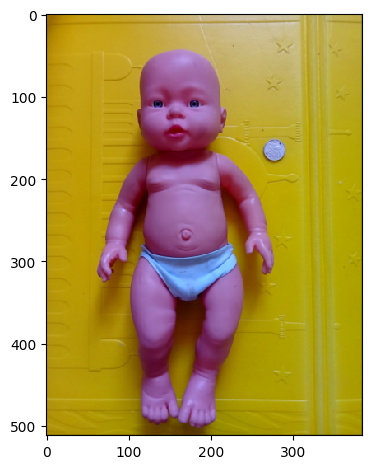

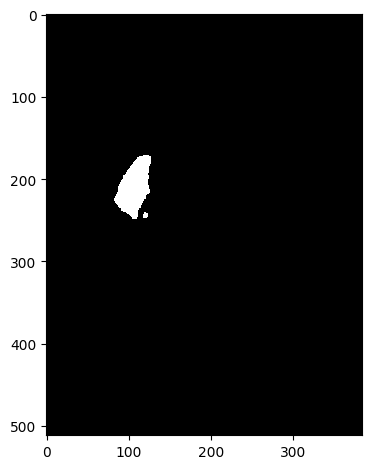

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


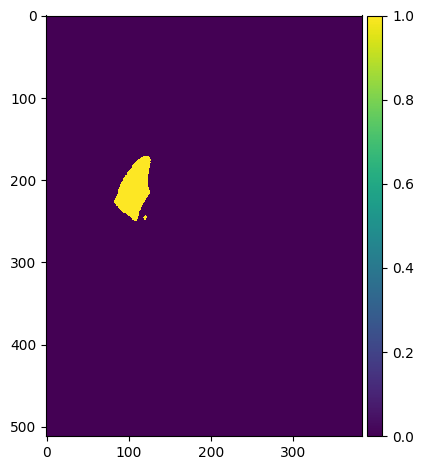

In [138]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples

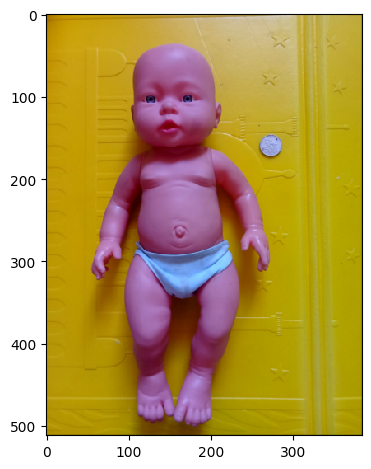

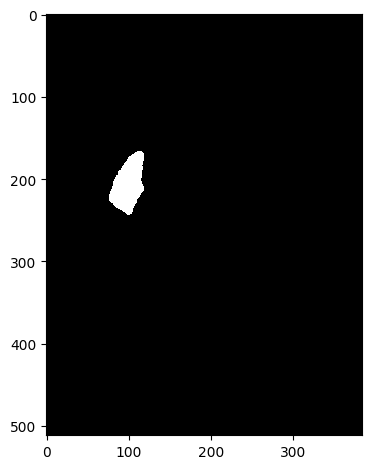

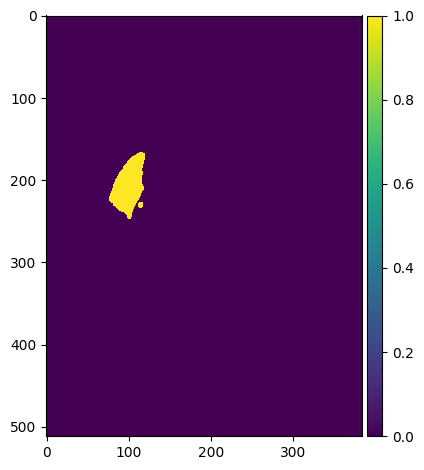

In [139]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Perform Prediction from Image Test

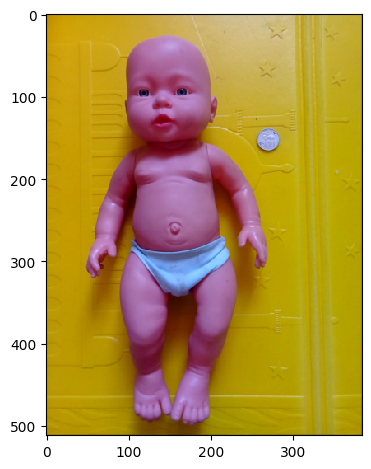

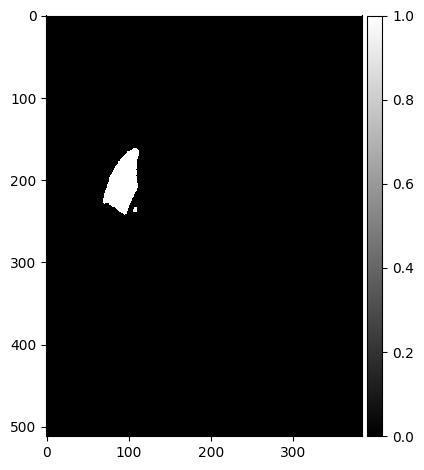

In [140]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()

# Saving Model

In [141]:
model.save('model_upper_arm.keras')


# ==== Main Code Ends Here ===

In [ ]:
loaded_model = tf.keras.models.load_model('D:\\BANGKIT\\Capstone Project\\GITHUB\\model_head.keras', safe_mode=False)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
preds_test = loaded_model.predict(X_test, verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


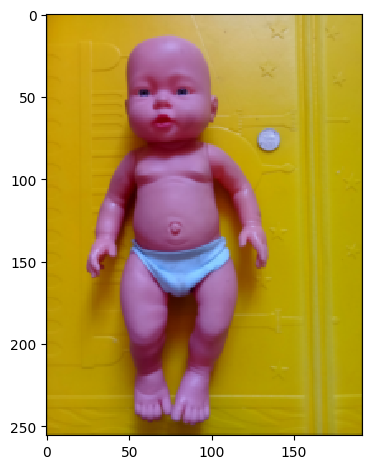

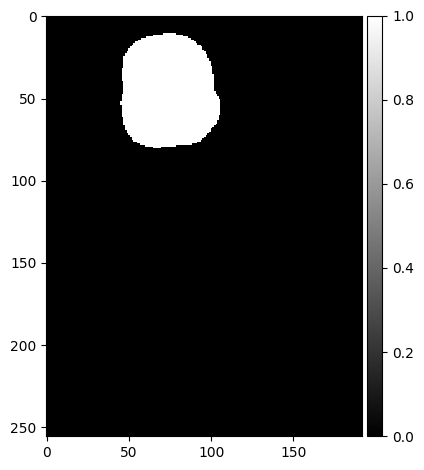

In [ ]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()

imshow(np.squeeze(preds_test_t[ix]), cmap='gray')
plt.show()